In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Домашка №1
# Усложненная
### Эта домашка нужна для лучшего понимания, но она будет сложнее из-за использования классов и, возможно, пока непривычной форме с классами.
Абстракции в этой домашке будут очень полезны для понимания того, что происходит в торче. Эта домашка прокачает вас гораздо сильнее, но и выполнить ее будет труднее. Вам нужно будет описать несколько слоев: `Linear`, `ReLU`, `BCELoss`.  Реализация `Sigmoid` уже есть в `our_library.layers`. Реализовав слои выше вы сможете сделать n-слойную нейронную сеть с любым количеством слоев. Это получается за счет того, что вы описали всю необходимую логику:
- Как нужно обработать входные данные и передать их дальше;
- Принять градиент с последующего слоя, сделать `backward` для текущего слоя и передать градиент предыдущему слою;
- Как обновить веса, если в слоев есть обучаемые веса.

Присылайте свои недоделанные сложные домашки, пусть они не пойдут совсем в стол. Я или ассистенты посмотрят, мы обсудим и доделаем.  
Поверьте, эта домашка стоит того, чтобы ее сделать!

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 1 и 7.

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

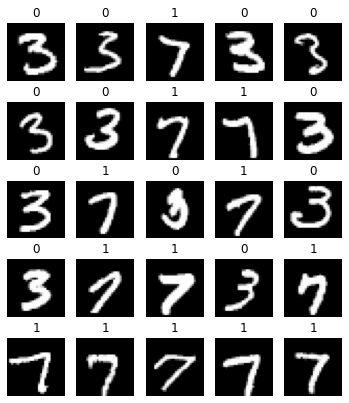

In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [7]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [8]:
x.shape

torch.Size([128, 1, 28, 28])

In [9]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [10]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [11]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [12]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [13]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [14]:
y

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0])

# Итерация по эпохам

In [15]:
# количество эпох - полных проходов по датасету
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будет
        # только демонстрация
        
        time.sleep(0.01)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Небольшие пояснения по numpy

In [16]:
# таким образом мы создаем матрицу 64 на 512 с рандомными значениями
x = np.random.rand(64, 512)
x

array([[0.74423458, 0.94330834, 0.93569631, ..., 0.52000163, 0.90070261,
        0.35512361],
       [0.41448436, 0.27341706, 0.46142633, ..., 0.68094999, 0.35575703,
        0.80338098],
       [0.4204895 , 0.62700456, 0.58650054, ..., 0.74707981, 0.55404167,
        0.71060311],
       ...,
       [0.24194786, 0.6666262 , 0.08592397, ..., 0.83652781, 0.08916666,
        0.86706406],
       [0.1351608 , 0.29231284, 0.11680497, ..., 0.2155453 , 0.79488618,
        0.03653916],
       [0.16042   , 0.54125218, 0.86596042, ..., 0.09779543, 0.01134724,
        0.59558389]])

In [17]:
# большинство функций применяются к каждому элементу массива
# здесь мы каждый элемент массива возвели в квадрат и прибавили к получившемуся значению логарифм элемента матрицы 
x ** 2 + np.log(x)

array([[ 0.2584861 ,  0.83146855,  0.80906328, ..., -0.38352165,
         0.70668504, -0.90917657],
       [-0.70892274, -1.22200006, -0.56051862, ...,  0.07942649,
        -0.9069442 ,  0.42649475],
       [-0.68952436, -0.07366675, -0.1895988 , ...,  0.26654498,
        -0.2835532 ,  0.16331555],
       ...,
       [-1.36049425,  0.03886467, -2.44690947, ...,  0.52128327,
        -2.40929738,  0.60915768],
       [-1.98302163, -1.14448388, -2.13360626, ..., -1.48812442,
         0.40228769, -3.30803556],
       [-1.80422534, -0.32091606,  0.60597138, ..., -2.31531349,
        -4.47865213, -0.16349287]])

In [18]:
y = np.random.rand(512, 1024)
# скалярное произведение
res = np.dot(x, y)

In [19]:
res

array([[141.06020832, 142.84876322, 135.54342274, ..., 141.5131059 ,
        132.13459365, 137.73944867],
       [130.96607758, 131.7186688 , 125.97611947, ..., 131.48829271,
        122.41744006, 122.80611859],
       [134.22102153, 135.16369425, 129.32970063, ..., 134.51551276,
        130.26192007, 129.75592219],
       ...,
       [138.86640075, 137.08760905, 132.1836028 , ..., 133.16956784,
        129.40489684, 132.58458871],
       [137.37913248, 130.6806966 , 125.97340256, ..., 131.90765765,
        126.98358851, 129.58436389],
       [134.8592326 , 133.8873969 , 128.28280268, ..., 129.63385643,
        127.77113597, 130.46413816]])

In [20]:
res.shape == (x.shape[0], y.shape[1])

True

# Импортируем нашу библиотеку
В ней реализованы некоторые полезные методы, в модуле `layers` есть реализация сигмоиды. Остальное вам смотреть необязательно, это некоторые дополнения, упрощающие вам жизнь.

In [21]:
from our_library import layers, wrapper, tools

## Реализуйте слои:
- Linear - линейная трансформация (не забудьте, что у нас в этом слое как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файла layers

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, 1)

## Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом) для примера

In [22]:
from typing import *

# Пример c сигмоидой
В `our_library.layers` также это есть

In [23]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):
        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """

        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_step):

        pass

# Тестирование

In [24]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [25]:
sigmoid_layer = Sigmoid()
forward_result = sigmoid_layer.forward(x)
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [26]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward_result)

In [27]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward_result)

# Линейный слой

In [28]:
class Linear:

    def __init__(self, in_features, out_features):
        
        # инициализируем веса
        self.weight = np.random.rand(in_features, out_features) * 0.01
        self.bias = np.random.rand(1, out_features) * 0.01
        
        self.x = None
        
        # сохраняем градиент для весов
        self._grad_weight = None
        self._grad_bias = None
        
        
    def forward(self, x: np.array):
        if x.shape[1] != self.weight.shape[0]:
            raise Exception(f"The number of features must be equal to {self.weight.shape[0]} "
                            "- it is represented by the number of rows in a matrix. "
                            f"Matrix of shape {x.shape} was passed instead")
        self.x = np.copy(x)
        output = np.dot(self.x, self.weight)
        
        return output

    
    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """
        # Given Z = W * X + b
        
        ### Почему мы подаём назад не ```grad @ np.transpose(X)```?
        # Ведь производная берётся по W (так как мы корректируем матрицу весов).
        # А значит мы берём производную dL/dW. Для производной по линейной функции dZ/dW
        # коэффициентами величины W будут выступать значения фичей X. И на следующий слой
        # должен передавать градиент, помноженный на X. 
        # Где я ошибаюсь?
        dLdW = np.dot(grad, np.transpose(self.weight))
        
        # dLdb = grad * dZdb = grad * 1
        
        self._grad_bias = np.dot(np.ones((1, grad.shape[0])), grad)
        
        self._grad_weight = np.dot(np.transpose(self.x), grad) # (4, 2) @ (2, 3)
        return dLdW

    
    def step(self, learning_rate):
        self.weight = self.weight - learning_rate * self._grad_weight
        self.bias = self.bias - learning_rate * self._grad_bias


# Тестирование

In [29]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ],
                          [0.73044998, 0.18287682, 0.41246361]])

correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165],
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [30]:
linear = Linear(in_features=4,
                out_features=3)

In [31]:
# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weight = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [32]:
forward = linear.forward(x)
backward = linear.backward(previous_grad)

In [33]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [34]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

In [35]:
# значения должны быть близкими
assert np.allclose(linear._grad_weight, correct_grad_weight)

In [36]:
# значения должны быть близкими
assert np.allclose(linear._grad_bias, correct_grad_bias)

# ReLU

In [37]:
class ReLU:

    def __init__(self):        
        self.x = None

    def forward(self, x):
        self.x = np.copy(x)
        return self.x * (self.x > 0)
        
    def backward(self, prev_grad):
        t = prev_grad * (self.x > 0)
        return prev_grad * (self.x > 0)
    
    def step(self, learning_rate):
        pass

# Тестирование

In [38]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [39]:
relu = ReLU()

In [40]:
forward = relu.forward(x)
backward = relu.backward(previous_grad)

In [41]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [42]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

# BCE test

### Не забудьте добавить np.expand_dims(y, 1) в forward

In [43]:
class BCELoss:

    def __init__(self):
        self.y = None
        self.x = None

    def forward(self, x, y):
        y = np.expand_dims(y, 1)
        self.x = np.copy(x) # prediction
        self.y = np.copy(y) # label 
        return np.average(-(y * np.log(x) + (1 - y) * np.log(1 - x)))

    def backward(self):
        b = ( (1 - self.y ) / (1 - self.x) ) - (self.y / self.x)
        return b / self.y.shape[0] # усредняем лосс

    def step(self, learning_rate):
        pass

# Тестирование

In [44]:
x = np.array([[0.76242307],
              [0.0908412 ],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

correct_forward_result = 0.24384403491500606

correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [45]:
loss = BCELoss()

In [46]:
forward = loss.forward(x, y)
backward = loss.backward()

In [47]:
backward

array([[-0.32790194],
       [ 0.27497946],
       [-0.41544356],
       [ 0.27656947]])

In [48]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [49]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: обновление весов можно сделать циклом
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward, то есть последний слой нашей сети
- TIP 5: forward и backward ничего не должны отдавать, в них должны быть расчитаны градиенты для каждого слоя
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

In [56]:
class NeuralNetwork:

    def __init__(self, modules):

        # список слоев
        self.modules = modules
        
        self.prediction = None

    def forward(self, x):
        for module in self.modules:
            x = module.forward(x)
        self.prediction = np.copy(x)
        return self.prediction

    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """
        for module in self.modules[::-1]:
            grad = module.backward(grad)
        
        

    def step(self, learning_rate):
        for module in self.modules[::-1]:
            module.step(learning_rate)

## Реализуйте обертку над моделью

In [57]:
class MNISTWrapper(wrapper.Wrapper):

    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели, передавая туда значение градиента по функции потерь
        5. Обновление весов с помощью step
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """
        #1
        self.model.forward(x)
        #2
        loss = self.loss.forward(self.model.prediction, y)
        #3
        bce_loss_grad = self.loss.backward()
        #4
        self.model.backward(bce_loss_grad)
        #5
        self.model.step(learning_rate)
        
        return (loss, self.model.prediction)
        
        

In [73]:
# задайте гиперпараметры
learning_rate = 0.01
epochs = 10

# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = NeuralNetwork(modules=[
    Linear(784, 550),
    Linear(550, 450),
    ReLU(),
    Linear(450, 250),
    Linear(250, 1),
    Sigmoid()
])

loss = BCELoss()

In [74]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)


## Обучение модели

In [76]:
neural_network.prediction

In [78]:
classifier.train(train_loader, test_loader, epochs=epochs)


Epoch 1:   6%|▌         | 6/97 [00:00<00:03, 28.35it/s, loss=0.456, metric=0.914]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.69705733e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.54819891e-02]
 [4.73290826e-01]
 [4.87769252e-04]
 [1.50251757e-04]
 [6.44101134e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.24463321e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.32607898e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.61733770e-03]
 [5.00000000e-01]
 [1.32155344e-06]
 [2.46112096e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.67853870e-02]
 [4.49272377e-01]
 [5.00000000e-01]
 [4.34860506e-01]
 [1.57373373e-02]
 [5.00000000e-01]
 [2.04472132e-04]
 [5.00000000e-01]
 [1.08668801e-04]
 [3.51065702e-08]
 [3.15158576e-04]
 [5.00000000e-01]
 [9.12138990e-02]
 [3.35476118e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.72827094e-02]
 [6.05287513e-02]
 [9.


Epoch 1:  10%|█         | 10/97 [00:00<00:04, 18.93it/s, loss=0.448, metric=0.91]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.17943711e-05]
 [5.00000000e-01]
 [1.27334381e-03]
 [1.47145834e-04]
 [1.61513952e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.76929511e-03]
 [7.00738751e-03]
 [2.02907768e-03]
 [6.22385380e-08]
 [4.25306343e-04]
 [7.26516357e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.10711604e-05]
 [5.00000000e-01]
 [4.26943397e-05]
 [2.72428638e-01]
 [9.88476268e-03]
 [9.43877404e-03]
 [5.00000000e-01]
 [6.83606510e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.79166657e-04]
 [6.58183285e-07]
 [9.75204928e-04]
 [1.22762230e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.55814613e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.13070375e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.15533425e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.70400414e-03]
 [3.23093208e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.


Epoch 1:  14%|█▍        | 14/97 [00:00<00:04, 18.89it/s, loss=0.44, metric=0.916] 

TOOLS
[[4.03618637e-01]
 [7.72305722e-03]
 [1.39561048e-01]
 [1.95436306e-03]
 [4.32359492e-01]
 [1.35022735e-01]
 [7.81282493e-06]
 [1.19958520e-05]
 [5.00000000e-01]
 [1.46164857e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.39572049e-02]
 [5.00000000e-01]
 [1.53818247e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.18863162e-04]
 [1.02966205e-03]
 [5.00000000e-01]
 [1.28693834e-02]
 [5.00000000e-01]
 [6.80806524e-04]
 [2.66089715e-06]
 [5.00000000e-01]
 [3.58875220e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.52936565e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.85085898e-03]
 [8.34228907e-03]
 [1.97999660e-02]
 [1.23107955e-03]
 [1.12693348e-01]
 [5.00000000e-01]
 [1.17441672e-02]
 [9.92099793e-03]
 [6.70824107e-02]
 [6.55644844e-05]
 [5.00000000e-01]
 [5.89421999e-04]
 [1.52823443e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.68034518e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.99855040e-02]
 [5.00000000e-01]
 [5.


Epoch 1:  19%|█▊        | 18/97 [00:00<00:04, 17.90it/s, loss=0.441, metric=0.913]

TOOLS
[[2.71929492e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.31847995e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.76612411e-05]
 [4.25817631e-01]
 [2.40308981e-02]
 [5.00000000e-01]
 [3.52937718e-01]
 [8.71583371e-05]
 [5.00000000e-01]
 [1.81718695e-03]
 [5.00000000e-01]
 [9.18852052e-03]
 [6.77157369e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.55285948e-04]
 [7.44707093e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.74851675e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.54645841e-07]
 [5.00000000e-01]
 [2.51201306e-05]
 [5.74123757e-03]
 [5.00000000e-01]
 [3.78199788e-04]
 [9.53808391e-02]
 [5.00000000e-01]
 [8.08927806e-03]
 [7.82806348e-03]
 [8.79067106e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.26913821e-03]
 [5.26346975e-03]
 [5.00000000e-01]
 [5.26078924e-04]
 [4.46279275e-06]
 [5.12283795e-05]
 [7.40224822e-04]
 [6.72186998e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.86873685e-02]
 [2.


Epoch 1:  23%|██▎       | 22/97 [00:01<00:04, 17.74it/s, loss=0.439, metric=0.914]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [2.19457698e-01]
 [7.58701152e-02]
 [5.00000000e-01]
 [8.16616108e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.92524097e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.65593307e-03]
 [5.00000000e-01]
 [2.26664106e-01]
 [1.07447092e-03]
 [9.09739253e-02]
 [5.00000000e-01]
 [6.58662802e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.24013600e-03]
 [3.55765173e-05]
 [3.22394042e-01]
 [6.59488465e-04]
 [5.61614551e-03]
 [5.00000000e-01]
 [7.05526475e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.46075609e-03]
 [1.42814996e-02]
 [5.00000000e-01]
 [1.84922225e-07]
 [5.00000000e-01]
 [5.95089330e-02]
 [5.00000000e-01]
 [5.06696433e-05]
 [1.95187580e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 1:  29%|██▉       | 28/97 [00:01<00:03, 21.61it/s, loss=0.448, metric=0.912]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.69228551e-06]
 [5.00000000e-01]
 [1.51055845e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.23421786e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.29390242e-04]
 [5.00000000e-01]
 [8.44998055e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.81124638e-04]
 [4.19100125e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.26783787e-04]
 [2.99392292e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.23909442e-03]
 [5.00000000e-01]
 [2.02103705e-05]
 [5.00000000e-01]
 [1.82746003e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.70121771e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.39936611e-04]
 [8.44577039e-03]
 [5.00000000e-01]
 [3.41913043e-01]
 [3.83144527e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.45642522e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.23952854e-07]
 [5.00000000e-01]
 [7.


Epoch 1:  33%|███▎      | 32/97 [00:01<00:02, 21.77it/s, loss=0.445, metric=0.91]

TOOLS
[[5.00000000e-01]
 [6.75124518e-06]
 [2.86609828e-01]
 [6.83992561e-04]
 [5.00000000e-01]
 [7.08568307e-05]
 [3.06234329e-03]
 [1.38804260e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.63700436e-04]
 [5.00000000e-01]
 [3.25357648e-04]
 [5.00000000e-01]
 [6.89808109e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.77790030e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.20465137e-01]
 [2.12534600e-03]
 [5.00000000e-01]
 [2.29900385e-06]
 [6.03901289e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.81172161e-02]
 [4.92326558e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.34849253e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.44336922e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.23370179e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.89603490e-06]
 [5.00000000e-01]
 [8.50452791e-06]
 [6.12314465e-03]
 [1.40732291e-01]
 [3.18953802e-01]
 [5.00000000e-01]
 [2.10912819e-05]
 [7.27379681e-04]
 [5.00000000e-01]
 [1.55437656e-01]
 [1.05668757e-04]
 [5.


Epoch 1:  38%|███▊      | 37/97 [00:01<00:02, 20.42it/s, loss=0.445, metric=0.911]

TOOLS
[[6.20931902e-06]
 [5.00000000e-01]
 [7.75710733e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.32103379e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.24507721e-03]
 [2.56144330e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.01965977e-05]
 [5.00000000e-01]
 [3.00433573e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.85091092e-05]
 [1.44358846e-01]
 [2.02904068e-02]
 [8.35028279e-05]
 [4.91196773e-02]
 [3.12644584e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.39917848e-03]
 [5.00000000e-01]
 [5.54358434e-03]
 [5.29870612e-04]
 [5.33032531e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.58103174e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.40549196e-03]
 [4.92043126e-03]
 [5.00000000e-01]
 [1.12954242e-02]
 [5.00000000e-01]
 [1.42340748e-01]
 [5.00000000e-01]
 [2.21769922e-06]
 [1.40557929e-03]
 [5.08735811e-05]
 [1.


Epoch 1:  43%|████▎     | 42/97 [00:02<00:02, 21.55it/s, loss=0.446, metric=0.909]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [2.24237679e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.73815803e-02]
 [2.02702507e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.10641777e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.44553761e-02]
 [5.00000000e-01]
 [2.70003854e-01]
 [2.85979220e-04]
 [5.96164238e-04]
 [2.71091116e-01]
 [3.38108803e-02]
 [5.00000000e-01]
 [5.90313333e-03]
 [7.84397001e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.05046538e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.11582563e-05]
 [5.72169694e-05]
 [2.55963379e-04]
 [5.00000000e-01]
 [4.67824755e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.08200884e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 1:  47%|████▋     | 46/97 [00:02<00:02, 19.99it/s, loss=0.445, metric=0.911]


TOOLS
[[8.05864492e-05]
 [1.75032536e-01]
 [5.00000000e-01]
 [1.39042010e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.09577556e-05]
 [5.00000000e-01]
 [4.65128590e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.98378036e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.78259095e-02]
 [4.30693527e-04]
 [5.00000000e-01]
 [3.22434774e-01]
 [1.18233569e-02]
 [2.39508795e-04]
 [5.00000000e-01]
 [4.55023552e-04]
 [5.00000000e-01]
 [1.33519589e-05]
 [3.26313771e-03]
 [5.28445669e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.66988161e-03]
 [7.90173970e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.93173287e-02]
 [1.28105861e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.16360375e-04]
 [5.00000000e-01]
 [1.33781010e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1


Epoch 1:  53%|█████▎    | 51/97 [00:02<00:02, 21.44it/s, loss=0.443, metric=0.911]


TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.69337118e-07]
 [1.21053713e-01]
 [3.05387702e-03]
 [2.38166009e-01]
 [5.00000000e-01]
 [3.23922359e-03]
 [9.62084133e-02]
 [9.68596507e-04]
 [2.25437814e-04]
 [6.88646236e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.10021161e-02]
 [5.00000000e-01]
 [3.61031806e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.01855270e-02]
 [2.95185262e-06]
 [5.00000000e-01]
 [3.23281159e-02]
 [1.12094950e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.74124834e-01]
 [5.00000000e-01]
 [2.30944458e-02]
 [5.00000000e-01]
 [5.89383063e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.25321269e-02]
 [5.00000000e-01]
 [8.68084014e-04]
 [5.00000000e-01]
 [1.51137659e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.60428430e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.03369127e-06]
 [5.

Epoch 1:  59%|█████▉    | 57/97 [00:02<00:01, 22.38it/s, loss=0.444, metric=0.91] 

TOOLS
[[5.00000000e-01]
 [4.99569462e-01]
 [1.43702657e-05]
 [5.00000000e-01]
 [1.23947467e-06]
 [5.00000000e-01]
 [1.90820577e-06]
 [3.07375758e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.21707160e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.76049176e-02]
 [2.63708822e-03]
 [1.68999354e-04]
 [5.00000000e-01]
 [1.90622105e-05]
 [1.09126414e-04]
 [8.00767156e-04]
 [2.47764323e-06]
 [5.00000000e-01]
 [2.91527607e-03]
 [5.79744172e-02]
 [7.75815305e-03]
 [1.35441595e-03]
 [2.27266619e-03]
 [5.00000000e-01]
 [7.59766394e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.50263636e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.44951229e-05]
 [5.00000000e-01]
 [2.30970802e-01]
 [5.00000000e-01]
 [1.54541419e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.57977776e-01]
 [5.00000000e-01]
 [5.70404486e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.50809733e-05]
 [7.19595946e-02]
 [7.35716243e-06]
 [6.23376474e-06]
 [5.00000000e-01]
 [9.


Epoch 1:  64%|██████▍   | 62/97 [00:02<00:01, 23.09it/s, loss=0.445, metric=0.911]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.97397759e-06]
 [5.67483835e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.26938426e-07]
 [1.55532959e-04]
 [6.29156051e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.17144498e-02]
 [5.00000000e-01]
 [5.71650161e-05]
 [1.29213716e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.99987634e-01]
 [5.00000000e-01]
 [2.32119893e-02]
 [7.40504098e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.91231455e-03]
 [2.40777049e-01]
 [5.00000000e-01]
 [1.32574492e-07]
 [5.00000000e-01]
 [1.36513348e-06]
 [5.00000000e-01]
 [5.04208056e-02]
 [3.66110904e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.63477839e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.35924028e-01]
 [5.00000000e-01]
 [2.74603734e-03]
 [5.00000000e-01]
 [2.12873940e-05]
 [1.90922717e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 1:  69%|██████▉   | 67/97 [00:03<00:01, 22.12it/s, loss=0.442, metric=0.91]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.15037591e-03]
 [5.00000000e-01]
 [1.47751484e-03]
 [5.00000000e-01]
 [1.96970467e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.63337710e-06]
 [4.60324997e-05]
 [1.45674438e-05]
 [1.01357621e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.76530687e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.81814956e-03]
 [5.00000000e-01]
 [2.00935813e-05]
 [5.17715128e-02]
 [2.35551923e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.17124298e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.42743970e-05]
 [3.52983177e-01]
 [3.19341737e-02]
 [5.00000000e-01]
 [2.15582040e-05]
 [5.00000000e-01]
 [1.51537487e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.75099269e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.31075757e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.32232965e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.17517844e-07]
 [5.00000000e-01]
 [3.37336891e-02]
 [5.


Epoch 1:  74%|███████▍  | 72/97 [00:03<00:01, 20.97it/s, loss=0.445, metric=0.911]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.79093201e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.09071387e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.63801673e-02]
 [3.97585788e-01]
 [5.00000000e-01]
 [2.20360445e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.55035831e-04]
 [2.78590491e-01]
 [5.00000000e-01]
 [5.50934033e-04]
 [4.97413635e-05]
 [3.54504134e-01]
 [2.72045387e-04]
 [6.02106084e-02]
 [6.42314144e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.12927657e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.52846933e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.12097528e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.83050326e-05]
 [2.69082189e-05]
 [4.64481149e-06]
 [5.00000000e-01]
 [6.84190529e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.67534638e-05]
 [3.42370031e-01]
 [5.00000000e-01]
 [3.12101826e-01]
 [5.


Epoch 1:  79%|███████▉  | 77/97 [00:03<00:00, 22.97it/s, loss=0.446, metric=0.911]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.35104417e-02]
 [4.36066201e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.69265789e-06]
 [3.46520166e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.93046107e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.91709196e-03]
 [5.00000000e-01]
 [2.33968375e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.12836445e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.37981906e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.68593719e-02]
 [3.07605004e-03]
 [1.76538262e-07]
 [2.47125578e-03]
 [2.33038526e-02]
 [2.74000005e-02]
 [5.00000000e-01]
 [1.50281444e-07]
 [5.26861081e-04]
 [3.30448015e-06]
 [1.31809220e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.07987960e-04]
 [5.00000000e-01]
 [2.17079368e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.59771379e-01]
 [5.


Epoch 1:  85%|████████▍ | 82/97 [00:03<00:00, 24.57it/s, loss=0.444, metric=0.911]

[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.95510550e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.60350957e-04]
 [6.50177570e-03]
 [5.00000000e-01]
 [2.45175500e-06]
 [3.74406334e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.78776096e-06]
 [5.00000000e-01]
 [4.22694671e-05]
 [5.00000000e-01]
 [9.25480430e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.99360693e-01]
 [9.36864222e-04]
 [1.86103299e-03]
 [2.46604049e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.28822988e-02]
 [9.16579077e-03]
 [3.02686235e-03]
 [1.21344756e-05]
 [2.98661281e-01]
 [5.00000000e-01]
 [5.57709017e-02]
 [1.07003784e-02]
 [7.31816848e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.34754121e-04]
 [5.00000000e-01]
 [1.12994127e-05]
 [2.51095935e-05]
 [5.46164170e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.75127474e-01]
 [6.03143828e-05]
 [1.97668104e-03]
 [5.00000000e-01]
 [1.97836000e-06]
 [5.00000000e-01]
 [5.000000


Epoch 1:  90%|████████▉ | 87/97 [00:04<00:00, 23.13it/s, loss=0.445, metric=0.911]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.74549907e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.69964762e-03]
 [5.00000000e-01]
 [9.97914964e-03]
 [5.00000000e-01]
 [1.15504071e-04]
 [6.28889518e-05]
 [4.91381355e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.43138746e-03]
 [5.00000000e-01]
 [9.87353982e-02]
 [2.74624687e-03]
 [5.00000000e-01]
 [1.88872355e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.24417708e-01]
 [6.06578346e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.80167057e-02]
 [2.02500160e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.12238743e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.10719653e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 1:  95%|█████████▍| 92/97 [00:04<00:00, 22.83it/s, loss=0.445, metric=0.912]

TOOLS
[[9.26730743e-04]
 [5.00000000e-01]
 [4.53790018e-07]
 [7.54630715e-02]
 [5.74184969e-03]
 [5.00000000e-01]
 [6.29859005e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.22365899e-03]
 [1.61850132e-07]
 [5.25518984e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.68948724e-03]
 [1.53650402e-04]
 [5.00000000e-01]
 [1.05344138e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.34837951e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.49314050e-01]
 [5.00000000e-01]
 [1.91366042e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.22883140e-05]
 [5.00000000e-01]
 [1.63741206e-03]
 [1.23311627e-01]
 [1.08478890e-04]
 [5.00000000e-01]
 [4.42948863e-06]
 [5.00000000e-01]
 [1.34558842e-03]
 [2.59418119e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.87851987e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.


Epoch 1: 100%|██████████| 97/97 [00:04<00:00, 23.53it/s, loss=0.445, metric=0.912]

TOOLS
[[1.98574591e-02]
 [3.59360270e-05]
 [5.00000000e-01]
 [1.78551687e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.69565377e-04]
 [5.00000000e-01]
 [2.28395503e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.05223369e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.46583889e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.94563742e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.80833315e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.05585442e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.37844148e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.68178417e-01]
 [2.78383591e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.62098051e-05]
 [5.00000000e-01]
 [6.05976302e-03]
 [5.00000000e-01]
 [3.12979464e-05]
 [1.17323987e-01]
 [1.35463174e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.76969012e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.73390070e-02]
 [5.00000000e-01]
 [1.01527009e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.52145134e-03]
 [5.

Epoch 1: 100%|██████████| 97/97 [00:04<00:00, 19.95it/s, loss=0.445, metric=0.912]

Epoch 2:   2%|▏         | 2/97 [00:00<00:03, 29.42it/s, loss=0.448, metric=0.883]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.65727921e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.25692620e-03]
 [5.00000000e-01]
 [1.37093100e-03]
 [5.00000000e-01]
 [1.58134603e-03]
 [1.19026839e-03]
 [2.73761542e-04]
 [5.00000000e-01]
 [6.89153604e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.46240732e-04]
 [5.00000000e-01]
 [5.01650988e-05]
 [5.00000000e-01]
 [3.10952871e-02]
 [5.18127710e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.48225249e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.11233990e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.39876528e-02]
 [5.26311776e-06]
 [1.04475213e-02]
 [1.96082334e-01]
 [5.00000000e-01]
 [1.22256571e-01]
 [5.00000000e-01]
 [7.99033029e-03]
 [5.00000000e-01]
 [4.93848539e-02]
 [2.56177443e-04]
 [5.00000000e-01]
 [1.40084522e-03]
 [5.00000000e-01]
 [3.25992212e-05]
 [5.00000000e-01]
 [3.38562086e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.54517495e-03]
 [8.


Epoch 2:   7%|▋         | 7/97 [00:00<00:03, 26.66it/s, loss=0.415, metric=0.913]

TOOLS
[[6.22484339e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.19805359e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.54758337e-04]
 [5.00000000e-01]
 [6.06215076e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.17350058e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.15459333e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.17717804e-01]
 [1.77569956e-04]
 [1.19773136e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.61411097e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.14834470e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.33932651e-05]
 [5.00000000e-01]
 [8.40800958e-04]
 [2.05842840e-01]
 [1.33088149e-07]
 [5.33250287e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.40025837e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.43836711e-02]
 [5.00000000e-01]
 [5.


Epoch 2:  12%|█▏        | 12/97 [00:00<00:03, 25.67it/s, loss=0.432, metric=0.909]

TOOLS
[[3.50506779e-01]
 [5.00000000e-01]
 [1.10617645e-05]
 [5.90383815e-03]
 [5.00000000e-01]
 [2.55137466e-02]
 [2.73347016e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.13167959e-04]
 [5.00000000e-01]
 [3.08578549e-04]
 [1.68973338e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.59801482e-07]
 [1.83652614e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.48098874e-05]
 [5.00000000e-01]
 [2.98352319e-02]
 [5.00000000e-01]
 [4.13337382e-01]
 [5.00000000e-01]
 [1.93240198e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.29596350e-01]
 [5.00000000e-01]
 [1.46156759e-01]
 [1.49781502e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.23807155e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.15322945e-01]
 [2.57575954e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.37498993e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.15104965e-05]
 [5.00000000e-01]
 [2.02505623e-02]
 [7.


Epoch 2:  19%|█▊        | 18/97 [00:00<00:03, 25.76it/s, loss=0.434, metric=0.912]

TOOLS
[[1.20223173e-01]
 [5.00000000e-01]
 [6.00169409e-06]
 [5.00000000e-01]
 [2.42736850e-04]
 [5.00000000e-01]
 [4.65245979e-04]
 [3.41709422e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.57254101e-04]
 [5.00000000e-01]
 [9.54002068e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.27429261e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.94914137e-06]
 [8.05428372e-02]
 [7.14573864e-02]
 [5.00000000e-01]
 [7.08947410e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.96922166e-02]
 [3.41997289e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.64273723e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.51298204e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 2:  25%|██▍       | 24/97 [00:00<00:02, 27.10it/s, loss=0.434, metric=0.909]

TOOLS
[[2.01341874e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.16413225e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.71783825e-04]
 [5.00000000e-01]
 [1.08404522e-05]
 [5.00000000e-01]
 [4.91155755e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.14522812e-01]
 [2.49713673e-01]
 [1.42016026e-10]
 [9.40854198e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.37569307e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.51114775e-03]
 [5.00000000e-01]
 [2.83147840e-03]
 [5.66311496e-08]
 [5.00000000e-01]
 [5.52187606e-04]
 [5.00000000e-01]
 [4.41044725e-04]
 [5.00000000e-01]
 [5.34011277e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.24292905e-05]
 [2.42503372e-04]
 [7.94241537e-06]
 [3.06127074e-02]
 [4.15437006e-06]
 [5.00000000e-01]
 [1.25287326e-04]
 [5.00000000e-01]
 [6.89172409e-09]
 [5.00000000e-01]
 [2.14069133e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 2:  30%|██▉       | 29/97 [00:01<00:02, 25.60it/s, loss=0.437, metric=0.908]

TOOLS
[[5.00000000e-01]
 [2.88694542e-05]
 [4.97765618e-02]
 [3.33293915e-03]
 [6.49410966e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.20429620e-05]
 [8.50396982e-04]
 [5.00000000e-01]
 [2.31483056e-04]
 [2.00913822e-05]
 [5.00000000e-01]
 [1.16847420e-03]
 [3.48051965e-06]
 [3.09523235e-07]
 [5.00000000e-01]
 [1.54382985e-02]
 [6.93614258e-02]
 [5.00000000e-01]
 [1.05612205e-06]
 [5.00000000e-01]
 [1.83656706e-01]
 [5.07002758e-02]
 [5.00000000e-01]
 [1.71734126e-01]
 [1.08359260e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.66926039e-04]
 [1.27722462e-04]
 [3.82976884e-04]
 [9.22094440e-06]
 [3.54686793e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.30762017e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.73336354e-04]
 [5.00000000e-01]
 [1.14848861e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.11834925e-01]
 [7.93736863e-05]
 [5.03157461e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 2:  35%|███▌      | 34/97 [00:01<00:02, 22.91it/s, loss=0.44, metric=0.91]  

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.41671183e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.06536341e-05]
 [1.43002407e-01]
 [5.00000000e-01]
 [1.84824052e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.99439249e-02]
 [1.33534993e-05]
 [2.25491775e-04]
 [5.88488474e-03]
 [5.00000000e-01]
 [4.37262502e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.01800145e-01]
 [5.00000000e-01]
 [2.53166248e-04]
 [5.35138551e-06]
 [1.91130582e-06]
 [5.00000000e-01]
 [8.82391943e-03]
 [4.62715514e-06]
 [5.00000000e-01]
 [6.14820527e-04]
 [1.17484336e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.92828565e-04]
 [1.69776956e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.58313734e-02]
 [8.63265443e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.33565853e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.18869760e-04]
 [7.


Epoch 2:  39%|███▉      | 38/97 [00:01<00:02, 22.04it/s, loss=0.441, metric=0.913]

TOOLS
[[1.04339414e-03]
 [3.88774662e-04]
 [2.13962466e-08]
 [5.00000000e-01]
 [2.30814669e-04]
 [5.00000000e-01]
 [1.43380482e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.25529418e-03]
 [3.56038226e-03]
 [5.00000000e-01]
 [8.26854373e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.32435547e-04]
 [5.00000000e-01]
 [3.49642815e-01]
 [5.00000000e-01]
 [1.49010944e-03]
 [2.32446166e-07]
 [5.00000000e-01]
 [3.69707934e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.02705087e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.47750909e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.45061823e-03]
 [7.92964334e-04]
 [3.81795460e-04]
 [1.71323116e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.43851326e-03]
 [3.58194641e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.64639254e-03]
 [8.91504625e-05]
 [5.00000000e-01]
 [2.34859518e-05]
 [5.00000000e-01]
 [5.74960127e-05]
 [4.72669929e-01]
 [5.00000000e-01]
 [1.31749998e-02]
 [5.00000000e-01]
 [8.23173157e-02]
 [5.


Epoch 2:  43%|████▎     | 42/97 [00:01<00:02, 21.39it/s, loss=0.439, metric=0.916]


TOOLS
[[2.98133753e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.83627230e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.54117722e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.80138505e-02]
 [1.52616316e-05]
 [5.00000000e-01]
 [2.14351012e-04]
 [5.85517084e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.02595701e-04]
 [1.58544763e-01]
 [1.67207969e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.05689676e-02]
 [2.89928275e-01]
 [5.00000000e-01]
 [1.15884550e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.32771190e-05]
 [5.00000000e-01]
 [4.93706926e-01]
 [1.93632170e-05]
 [5.00000000e-01]
 [2.07232132e-03]
 [2.65438121e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.48111209e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.01284576e-02]
 [5.00000000e-01]
 [1.16198966e-03]
 [1.87502138e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.88820210e-04]
 [2.70122350e-01]
 [3.63450133e-04]
 [2.79990587e-03]
 [2


Epoch 2:  47%|████▋     | 46/97 [00:02<00:02, 20.10it/s, loss=0.44, metric=0.916] 

TOOLS
[[5.00000000e-01]
 [2.26762809e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.45650299e-02]
 [5.00000000e-01]
 [1.39427990e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.60872786e-02]
 [2.73902842e-01]
 [5.00000000e-01]
 [1.17191197e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.48627478e-02]
 [1.36756111e-03]
 [1.01579861e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.84987407e-02]
 [5.00000000e-01]
 [4.50471053e-03]
 [7.87741112e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.88395624e-05]
 [5.00000000e-01]
 [1.55313065e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.44111099e-02]
 [5.00000000e-01]
 [5.11620644e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.26237185e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.96690926e-03]
 [2.44053279e-08]
 [5.


Epoch 2:  53%|█████▎    | 51/97 [00:02<00:02, 21.20it/s, loss=0.439, metric=0.916]

TOOLS
[[2.79516537e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.30115090e-01]
 [5.00000000e-01]
 [2.21474617e-03]
 [5.00000000e-01]
 [1.56034802e-03]
 [5.00000000e-01]
 [1.29368525e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.84352634e-03]
 [5.00000000e-01]
 [6.58596843e-03]
 [2.91559820e-01]
 [5.00000000e-01]
 [3.09703998e-05]
 [1.92834214e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.48271227e-03]
 [2.39310678e-01]
 [5.00000000e-01]
 [1.90104421e-06]
 [1.28302942e-04]
 [6.22027759e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.35804811e-02]
 [5.00000000e-01]
 [1.55389047e-01]
 [5.00000000e-01]
 [4.19008965e-03]
 [1.50934948e-04]
 [3.63929915e-02]
 [5.00000000e-01]
 [9.44416878e-02]
 [8.44918135e-02]
 [1.80553507e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.23599552e-04]
 [7.66341827e-03]
 [5.00000000e-01]
 [2.91541875e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.37846425e-02]
 [5.


Epoch 2:  59%|█████▉    | 57/97 [00:02<00:01, 23.22it/s, loss=0.437, metric=0.917]

TOOLS
[[2.77745238e-11]
 [1.17205609e-01]
 [5.00000000e-01]
 [5.02115605e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.51198424e-04]
 [5.00000000e-01]
 [5.82137678e-04]
 [5.00000000e-01]
 [1.01864987e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.23926256e-05]
 [3.79378089e-03]
 [5.00000000e-01]
 [1.40283541e-02]
 [5.00000000e-01]
 [7.70072419e-04]
 [8.14530457e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.15753167e-06]
 [1.86391162e-03]
 [5.00000000e-01]
 [1.89581798e-01]
 [4.01837319e-04]
 [1.60147205e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.54255731e-03]
 [5.00000000e-01]
 [2.00818726e-03]
 [6.60884137e-02]
 [2.27014147e-02]
 [6.74828756e-04]
 [5.00000000e-01]
 [2.15963338e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.36469892e-06]
 [5.00000000e-01]
 [4.66479485e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.29807444e-06]
 [5.00000000e-01]
 [3.68005694e-05]
 [1.97962729e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.74358962e-03]
 [2.


Epoch 2:  65%|██████▍   | 63/97 [00:02<00:01, 25.72it/s, loss=0.438, metric=0.917]

TOOLS
[[4.12068799e-04]
 [5.74328750e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.13399076e-04]
 [1.99369228e-03]
 [2.26456786e-05]
 [5.00000000e-01]
 [6.35277680e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.04521043e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.05996359e-01]
 [5.00000000e-01]
 [3.56519638e-05]
 [4.07285134e-03]
 [1.42061817e-04]
 [5.60720507e-07]
 [5.00000000e-01]
 [3.35405179e-06]
 [5.00000000e-01]
 [4.89572503e-02]
 [2.18595805e-02]
 [4.05652169e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.58647786e-04]
 [3.58164358e-02]
 [4.89588264e-03]
 [5.00000000e-01]
 [1.79284461e-04]
 [7.03765709e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.06801731e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.47231952e-04]
 [6.20950935e-03]
 [5.00000000e-01]
 [2.94979293e-04]
 [1.06159289e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 2:  69%|██████▉   | 67/97 [00:02<00:01, 25.66it/s, loss=0.439, metric=0.917]

TOOLS
[[1.55039863e-02]
 [5.00000000e-01]
 [4.65637431e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.69745919e-07]
 [1.88021929e-02]
 [5.00000000e-01]
 [9.35246239e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.33695199e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.76980192e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.62801729e-02]
 [3.38692170e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.52463096e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.18087700e-04]
 [2.65875636e-02]
 [6.


Epoch 2:  73%|███████▎  | 71/97 [00:03<00:01, 21.10it/s, loss=0.439, metric=0.918]

TOOLS
[[5.00000000e-01]
 [1.93134851e-01]
 [1.57242374e-02]
 [3.41590532e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.61584042e-02]
 [5.00000000e-01]
 [1.28048394e-03]
 [1.56685449e-06]
 [5.00000000e-01]
 [1.87254525e-04]
 [1.25260863e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.02383487e-05]
 [2.17885226e-02]
 [5.00000000e-01]
 [2.44003989e-03]
 [5.00000000e-01]
 [1.07771995e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.37230828e-06]
 [1.31549350e-02]
 [1.13097595e-03]
 [5.00000000e-01]
 [4.24610605e-03]
 [5.85474997e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.68707522e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.57888562e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.01637374e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.74845905e-02]
 [5.00000000e-01]
 [1.55788927e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.45601773e-02]
 [5.00000000e-01]
 [1.


Epoch 2:  78%|███████▊  | 76/97 [00:03<00:01, 20.02it/s, loss=0.438, metric=0.919]

TOOLS
[[4.24225138e-05]
 [1.56664635e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.58899864e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.99614671e-02]
 [1.58893149e-03]
 [5.00000000e-01]
 [3.36942365e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.18717552e-07]
 [5.00000000e-01]
 [2.52132354e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.04971257e-06]
 [2.92208202e-06]
 [2.80039771e-01]
 [5.00000000e-01]
 [1.43733709e-01]
 [2.18038153e-04]
 [8.68402215e-04]
 [5.61861543e-04]
 [3.17535263e-02]
 [5.00000000e-01]
 [3.57641864e-07]
 [3.09620491e-06]
 [1.76013109e-01]
 [1.28340616e-06]
 [5.00000000e-01]
 [4.88301616e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.70297609e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.58120268e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.76900655e-06]
 [5.00000000e-01]
 [9.82811602e-03]
 [5.


Epoch 2:  84%|████████▎ | 81/97 [00:03<00:00, 21.56it/s, loss=0.439, metric=0.918]

TOOLS
[[7.83292248e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.67142005e-07]
 [1.63871007e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.54448160e-03]
 [5.00000000e-01]
 [5.04270728e-06]
 [6.50093679e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.23156917e-01]
 [5.00000000e-01]
 [8.82116099e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.98627937e-07]
 [1.50874865e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.09255167e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.79893559e-04]
 [5.00000000e-01]
 [7.25549411e-03]
 [9.68817567e-03]
 [2.43477353e-08]
 [5.00000000e-01]
 [2.06116463e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.19579425e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.45209804e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.06469771e-04]
 [9.99046554e-03]
 [2.


Epoch 2:  88%|████████▊ | 85/97 [00:03<00:00, 19.39it/s, loss=0.438, metric=0.918]

TOOLS
[[1.56113654e-05]
 [5.00000000e-01]
 [3.89025820e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.84387236e-06]
 [5.00000000e-01]
 [7.60408343e-02]
 [4.37790594e-04]
 [5.00000000e-01]
 [2.11871380e-04]
 [5.00000000e-01]
 [1.97203262e-01]
 [9.39272990e-02]
 [5.00000000e-01]
 [7.61476752e-03]
 [1.04544009e-02]
 [5.00000000e-01]
 [1.44958775e-03]
 [1.60614688e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.76095030e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.02028651e-06]
 [5.00000000e-01]
 [1.28894988e-02]
 [7.57487097e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.74558063e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.08311556e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.29273694e-07]
 [7.94651861e-07]
 [9.07731583e-06]
 [3.00987689e-06]
 [9.88955005e-04]
 [5.69943035e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.75615114e-03]
 [6.25660936e-04]
 [3.42389838e-05]
 [1.29338260e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 2:  92%|█████████▏| 89/97 [00:04<00:00, 18.24it/s, loss=0.439, metric=0.918]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [4.01684999e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.39369760e-04]
 [5.00000000e-01]
 [2.54086979e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.03430893e-04]
 [1.16398513e-03]
 [4.79080616e-04]
 [1.10974433e-03]
 [5.47810630e-04]
 [5.00000000e-01]
 [3.92493346e-04]
 [5.00000000e-01]
 [1.84348469e-01]
 [5.00000000e-01]
 [3.09260077e-03]
 [9.77521082e-02]
 [5.00000000e-01]
 [3.36662188e-05]
 [9.07522656e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.31126490e-01]
 [1.56931944e-01]
 [5.00000000e-01]
 [2.52062719e-05]
 [5.00000000e-01]
 [1.59115649e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.59448121e-02]
 [5.00000000e-01]
 [3.75080987e-01]
 [3.23452511e-06]
 [5.88350106e-02]
 [5.00000000e-01]
 [2.68028701e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.85989276e-01]
 [5.00000000e-01]
 [2.10893642e-02]
 [5.13487751e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 2:  95%|█████████▍| 92/97 [00:04<00:00, 16.50it/s, loss=0.438, metric=0.918]

TOOLS
[[2.37565640e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.11212603e-02]
 [7.38624422e-06]
 [1.07652627e-07]
 [5.00000000e-01]
 [5.37797005e-07]
 [7.17352130e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.17751585e-04]
 [1.81470464e-01]
 [3.62595403e-02]
 [2.86432444e-03]
 [1.09577585e-04]
 [5.00000000e-01]
 [3.48456926e-02]
 [5.13326105e-06]
 [5.00000000e-01]
 [9.38259325e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.54231283e-04]
 [5.00000000e-01]
 [3.48916526e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.63835322e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.43228041e-07]
 [2.84402495e-02]
 [5.00000000e-01]
 [5.40166108e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.74270453e-05]
 [5.00000000e-01]
 [1.53882896e-06]
 [1.30572247e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.90286187e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.20920769e-02]
 [5.


Epoch 2:  98%|█████████▊| 95/97 [00:04<00:00, 15.95it/s, loss=0.439, metric=0.918]


TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.10050768e-05]
 [1.60053313e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.64774935e-04]
 [5.00000000e-01]
 [3.18813356e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.24749239e-04]
 [1.27520843e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.72748048e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.23390471e-03]
 [5.00000000e-01]
 [8.28005562e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.52084774e-01]
 [5.00000000e-01]
 [4.86059727e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.94625618e-04]
 [1.08197822e-03]
 [4.45468186e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.11786493e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.37931785e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.49113497e-03]
 [3.

Epoch 2: 100%|██████████| 97/97 [00:04<00:00, 16.01it/s, loss=0.439, metric=0.918]

TOOLS
[[3.02108007e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.11712959e-03]
 [5.00000000e-01]
 [4.99975746e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.79443574e-07]
 [4.46976078e-08]
 [5.00000000e-01]
 [2.88061404e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.39654707e-03]
 [1.13431941e-04]
 [5.25446770e-02]
 [6.23482641e-03]
 [5.00000000e-01]
 [1.80481663e-02]
 [8.94210459e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.56780647e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.77595663e-02]
 [4.60831309e-06]
 [5.00000000e-01]
 [3.21552963e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.24577461e-01]
 [9.26947266e-04]
 [5.00000000e-01]
 [3.69764908e-05]
 [5.00000000e-01]
 [1.20492407e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.72336355e-03]
 [2.00501640e-06]
 [5.

Epoch 2: 100%|██████████| 97/97 [00:05<00:00, 19.09it/s, loss=0.439, metric=0.918]

Epoch 3:   3%|▎         | 3/97 [00:00<00:03, 31.33it/s, loss=0.448, metric=0.917]


TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.75023446e-02]
 [5.00000000e-01]
 [6.84554774e-02]
 [1.73204299e-01]
 [5.00000000e-01]
 [1.57812957e-03]
 [3.05380975e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.81061712e-03]
 [1.33064091e-02]
 [4.99850457e-01]
 [5.00000000e-01]
 [3.56471043e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.52403827e-02]
 [1.34531632e-01]
 [3.48616173e-06]
 [5.00000000e-01]
 [3.66801941e-07]
 [5.00000000e-01]
 [2.09604748e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.83967495e-05]
 [5.00000000e-01]
 [1.69590966e-05]
 [5.00000000e-01]
 [1.92627202e-07]
 [1.76144033e-06]
 [5.00000000e-01]
 [2.16336358e-05]
 [1.75545403e-05]
 [5.00000000e-01]
 [5.06866887e-06]
 [1.64740257e-06]
 [5.01427208e-09]
 [3.72084033e-01]
 [4.74428704e-01]
 [5.00000000e-01]
 [5.81356567e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.06254234e-03]
 [5.00000000e-01]
 [6


Epoch 3:   9%|▉         | 9/97 [00:00<00:02, 31.20it/s, loss=0.447, metric=0.924]

TOOLS
[[2.30644477e-01]
 [5.00000000e-01]
 [3.68935229e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.32603724e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.02044453e-01]
 [8.40690647e-05]
 [3.04987677e-04]
 [5.00000000e-01]
 [1.46419763e-02]
 [4.71533576e-02]
 [5.43249733e-03]
 [2.38357572e-03]
 [1.80322649e-03]
 [1.14443594e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.76135089e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.35185357e-04]
 [5.00000000e-01]
 [3.18956135e-03]
 [5.00000000e-01]
 [4.60804869e-02]
 [2.44626339e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.09238661e-05]
 [3.43339110e-05]
 [5.00000000e-01]
 [1.65780187e-02]
 [1.21461109e-03]
 [8.74401103e-06]
 [5.00000000e-01]
 [1.25683037e-03]
 [4.40293594e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 3:  12%|█▏        | 12/97 [00:00<00:04, 17.78it/s, loss=0.434, metric=0.922]

TOOLS
[[1.66762243e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.08147570e-06]
 [2.31926729e-01]
 [3.25324138e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.03962317e-06]
 [3.14174346e-01]
 [2.56278487e-06]
 [3.22038290e-07]
 [5.00000000e-01]
 [6.32150786e-05]
 [5.00000000e-01]
 [8.98767899e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.51066190e-03]
 [5.00000000e-01]
 [2.39625299e-01]
 [8.62948415e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.64281657e-02]
 [2.29418949e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.59528492e-02]
 [1.14224579e-03]
 [5.00000000e-01]
 [2.23045578e-04]
 [4.48898380e-04]
 [6.65174764e-08]
 [1.25831028e-01]
 [5.00000000e-01]
 [3.61465055e-05]
 [4.81812586e-04]
 [3.55169084e-02]
 [9.77728198e-05]
 [5.00000000e-01]
 [2.72677270e-05]
 [3.90516900e-01]
 [5.00000000e-01]
 [6.32572032e-04]
 [1.81287036e-03]
 [6.04990429e-06]
 [5.00000000e-01]
 [1.28945122e-02]
 [5.


Epoch 3:  15%|█▌        | 15/97 [00:00<00:04, 16.57it/s, loss=0.43, metric=0.919] 

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [4.08108772e-05]
 [5.00000000e-01]
 [4.92885395e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.04290523e-01]
 [1.17319800e-05]
 [5.00000000e-01]
 [1.54205367e-05]
 [5.00000000e-01]
 [1.46622850e-03]
 [5.00000000e-01]
 [9.66077707e-07]
 [8.62545436e-05]
 [2.89323305e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.09512198e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.58815085e-06]
 [2.31359541e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.46621736e-05]
 [5.00000000e-01]
 [1.11397501e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.84529760e-01]
 [5.00000000e-01]
 [1.17180696e-01]
 [5.00000000e-01]
 [1.47555687e-05]
 [5.00000000e-01]
 [3.74885474e-05]
 [5.00000000e-01]
 [1.15572767e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.44400169e-07]
 [5.


Epoch 3:  19%|█▊        | 18/97 [00:01<00:05, 14.68it/s, loss=0.439, metric=0.92]

TOOLS
[[1.09784280e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.64693530e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.32865158e-02]
 [5.00000000e-01]
 [8.48487342e-02]
 [2.28197075e-02]
 [5.00000000e-01]
 [9.49982681e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.20736599e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.55830054e-02]
 [1.94720205e-04]
 [7.02827143e-02]
 [4.22728440e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.63532691e-03]
 [5.00000000e-01]
 [4.34833799e-04]
 [4.49195047e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.38841387e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.72519876e-09]
 [2.15660833e-01]
 [5.00000000e-01]
 [3.65391759e-10]
 [5.00000000e-01]
 [1.38018209e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.09957194e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.


Epoch 3:  22%|██▏       | 21/97 [00:01<00:05, 14.11it/s, loss=0.443, metric=0.92]

TOOLS
[[7.90626437e-03]
 [3.33824767e-05]
 [5.00000000e-01]
 [5.70486606e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.76805213e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.26724473e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.37921181e-04]
 [1.66871221e-04]
 [6.83283587e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.44467118e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.07673546e-03]
 [5.00000000e-01]
 [6.17738891e-04]
 [1.81865323e-04]
 [1.57001548e-06]
 [3.83711617e-01]
 [2.92602952e-07]
 [9.87406325e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.31524580e-01]
 [5.00000000e-01]
 [4.58097591e-05]
 [5.82574668e-02]
 [5.00000000e-01]
 [4.65843893e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.60919141e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 3:  25%|██▍       | 24/97 [00:01<00:05, 13.05it/s, loss=0.441, metric=0.919]

TOOLS
[[9.95849817e-04]
 [5.00000000e-01]
 [3.32627547e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.52621448e-04]
 [2.37933321e-04]
 [5.00000000e-01]
 [9.35887103e-04]
 [5.04229522e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.49789211e-02]
 [5.00000000e-01]
 [9.51893832e-02]
 [9.68918734e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.04694883e-03]
 [1.27629195e-01]
 [4.66316413e-01]
 [5.00000000e-01]
 [2.31918283e-02]
 [5.00000000e-01]
 [2.60964518e-04]
 [1.28648956e-01]
 [4.48344060e-03]
 [3.97376897e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.98967840e-02]
 [9.11991131e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.31115002e-05]
 [1.15463582e-03]
 [5.00000000e-01]
 [1.17611250e-03]
 [3.16532967e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.49635035e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.43091266e-06]
 [5.


Epoch 3:  30%|██▉       | 29/97 [00:01<00:04, 15.95it/s, loss=0.442, metric=0.92]

TOOLS
[[2.51607545e-01]
 [7.31353161e-05]
 [5.00000000e-01]
 [1.14267428e-05]
 [2.90800613e-02]
 [5.89531167e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.07713111e-02]
 [4.97076327e-01]
 [7.03275598e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.40724350e-04]
 [5.00000000e-01]
 [5.29039317e-04]
 [5.00000000e-01]
 [4.73458663e-08]
 [2.84025066e-06]
 [5.00000000e-01]
 [4.00086000e-02]
 [5.82970148e-03]
 [5.00000000e-01]
 [2.80022443e-05]
 [5.00000000e-01]
 [6.82267594e-05]
 [5.00000000e-01]
 [2.22689074e-03]
 [5.00000000e-01]
 [2.32524900e-01]
 [5.00000000e-01]
 [6.17149211e-06]
 [5.00000000e-01]
 [5.06450391e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.49035673e-01]
 [6.49026686e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.03978315e-09]
 [5.00000000e-01]
 [2.53518474e-02]
 [2.32564053e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.


Epoch 3:  34%|███▍      | 33/97 [00:01<00:03, 16.60it/s, loss=0.441, metric=0.917]

TOOLS
[[1.09576291e-06]
 [7.93130013e-06]
 [5.68130855e-02]
 [1.51238651e-02]
 [5.00000000e-01]
 [6.24052180e-05]
 [1.61411457e-06]
 [6.15734349e-04]
 [5.00000000e-01]
 [4.05254926e-03]
 [2.64483841e-01]
 [5.00000000e-01]
 [6.28360485e-06]
 [5.00000000e-01]
 [2.47654627e-01]
 [5.00000000e-01]
 [2.33909690e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.81423118e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.89833628e-02]
 [2.33894661e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.54891758e-08]
 [2.90765200e-03]
 [5.00000000e-01]
 [1.04734937e-05]
 [4.76353765e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.81436808e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.47307229e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 3:  38%|███▊      | 37/97 [00:02<00:03, 15.68it/s, loss=0.439, metric=0.919]

TOOLS
[[5.00000000e-01]
 [1.96883476e-05]
 [3.92928009e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.98866585e-09]
 [1.97818594e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.32860958e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.05556915e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.14612083e-01]
 [5.07764388e-03]
 [5.00000000e-01]
 [9.78430988e-09]
 [1.40879827e-04]
 [5.00000000e-01]
 [4.63759894e-05]
 [5.00000000e-01]
 [1.54688506e-02]
 [1.02098095e-02]
 [4.95950507e-05]
 [7.98300045e-02]
 [1.01969005e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.30606822e-01]
 [5.00000000e-01]
 [1.72768577e-07]
 [3.78349207e-04]
 [5.00000000e-01]
 [3.08968172e-03]
 [1.45782667e-08]
 [5.00000000e-01]
 [1.26431460e-07]
 [2.43260704e-02]
 [2.60656058e-03]
 [1.00500610e-02]
 [5.00000000e-01]
 [1.20572476e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.67460396e-09]
 [1.69313071e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.73751532e-02]
 [5.


Epoch 3:  41%|████      | 40/97 [00:02<00:03, 16.00it/s, loss=0.439, metric=0.918]

TOOLS
[[4.14004233e-03]
 [1.24782070e-04]
 [5.00000000e-01]
 [6.59714208e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.96014409e-04]
 [7.76010890e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.94526491e-01]
 [1.13063283e-01]
 [5.00000000e-01]
 [4.65553111e-05]
 [3.14740488e-06]
 [1.82514897e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.65877359e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.47385513e-05]
 [5.96682098e-04]
 [5.01550914e-08]
 [1.22136184e-01]
 [2.75519810e-01]
 [5.00000000e-01]
 [6.40941562e-03]
 [5.00000000e-01]
 [1.48566569e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.96811279e-01]
 [2.45024378e-05]
 [5.00000000e-01]
 [6.84401349e-05]
 [5.00000000e-01]
 [2.17074645e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.22887651e-02]
 [5.00000000e-01]
 [1.63897322e-03]
 [1.49985571e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.70251936e-02]
 [5.00000000e-01]
 [4.


Epoch 3:  44%|████▍     | 43/97 [00:02<00:03, 13.88it/s, loss=0.438, metric=0.918]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.11099524e-01]
 [5.00000000e-01]
 [6.92091818e-03]
 [5.00000000e-01]
 [8.95624860e-08]
 [5.00000000e-01]
 [1.50635225e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.68360519e-03]
 [2.01575804e-01]
 [5.00000000e-01]
 [1.63755117e-07]
 [5.00000000e-01]
 [2.48917369e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.97457699e-03]
 [7.59605492e-06]
 [5.00000000e-01]
 [1.61208645e-02]
 [4.44438278e-06]
 [3.58317673e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.36379311e-10]
 [1.57427062e-06]
 [5.00000000e-01]
 [3.05125095e-02]
 [7.37087167e-05]
 [2.91232493e-06]
 [5.00000000e-01]
 [1.36815583e-03]
 [4.80578775e-04]
 [1.73556121e-04]
 [2.35538253e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.21602595e-08]
 [5.00000000e-01]
 [2.62731480e-07]
 [3.94418680e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.35711093e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.58486681e-02]
 [5.


Epoch 3:  48%|████▊     | 47/97 [00:02<00:03, 14.49it/s, loss=0.439, metric=0.916]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.31500288e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.29272523e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.33390651e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.03003336e-04]
 [2.88662479e-03]
 [5.00000000e-01]
 [1.81511109e-03]
 [2.38742464e-04]
 [3.38576647e-06]
 [1.28419800e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.90553435e-02]
 [2.46683852e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.77346414e-01]
 [5.00000000e-01]
 [7.92768890e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.63201807e-03]
 [5.00000000e-01]
 [1.72797080e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.47800725e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.50201793e-10]
 [1.97105212e-06]
 [5.00000000e-01]
 [5.96273380e-02]
 [5.00000000e-01]
 [5.


Epoch 3:  52%|█████▏    | 50/97 [00:03<00:03, 13.62it/s, loss=0.44, metric=0.917] 

TOOLS
[[5.00000000e-01]
 [5.15469109e-04]
 [1.34701112e-03]
 [2.16351271e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.70800172e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.99612829e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.78262308e-03]
 [1.72948291e-03]
 [5.00000000e-01]
 [1.48860878e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.25654727e-06]
 [5.00000000e-01]
 [1.24526062e-01]
 [5.00000000e-01]
 [1.25257427e-05]
 [5.00000000e-01]
 [8.05927993e-05]
 [5.00000000e-01]
 [1.41254690e-03]
 [5.00000000e-01]
 [7.71001790e-02]
 [5.00000000e-01]
 [1.49150080e-01]
 [1.35496747e-06]
 [3.19544967e-05]
 [5.00000000e-01]
 [9.41893424e-04]
 [1.20600761e-06]
 [5.00000000e-01]
 [1.39876486e-01]
 [1.40125739e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.55035711e-02]
 [5.00000000e-01]
 [4.95154445e-01]
 [3.55966686e-05]
 [5.


Epoch 3:  55%|█████▍    | 53/97 [00:03<00:03, 14.12it/s, loss=0.44, metric=0.917] 

TOOLS
[[5.00000000e-01]
 [1.53668866e-04]
 [2.60262829e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.25404977e-02]
 [2.62876287e-05]
 [5.00000000e-01]
 [1.21433605e-06]
 [1.76587825e-04]
 [5.00000000e-01]
 [1.53214267e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.33182617e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.89868628e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.37679638e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.33877101e-06]
 [5.81705497e-05]
 [1.35136050e-05]
 [3.36723176e-03]
 [6.57170057e-04]
 [5.00000000e-01]
 [1.91626817e-06]
 [5.00000000e-01]
 [2.11259313e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.81773640e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.05196292e-04]
 [5.00000000e-01]
 [3.88531456e-04]
 [1.33293342e-02]
 [8.69265325e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.60385966e-05]
 [5.00000000e-01]
 [9.17394497e-06]
 [5.


Epoch 3:  58%|█████▊    | 56/97 [00:03<00:03, 12.79it/s, loss=0.439, metric=0.917]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.29824213e-02]
 [1.83490604e-01]
 [9.50226639e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.09819176e-03]
 [5.00000000e-01]
 [1.37107644e-01]
 [5.00000000e-01]
 [2.06799387e-04]
 [5.00000000e-01]
 [2.38277875e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.73054236e-01]
 [3.21610250e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.27969641e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.79534780e-03]
 [3.77136686e-04]
 [5.00000000e-01]
 [7.77300803e-05]
 [5.00000000e-01]
 [2.00789452e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.72162666e-03]
 [2.28974930e-04]
 [4.45245873e-08]
 [5.84459600e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.35654079e-01]
 [9.37507843e-03]
 [5.93028495e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.82695967e-04]
 [5.00000000e-01]
 [5.


Epoch 3:  62%|██████▏   | 60/97 [00:03<00:02, 14.35it/s, loss=0.439, metric=0.918]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [3.33718907e-03]
 [7.76651817e-08]
 [5.00000000e-01]
 [4.50100687e-03]
 [1.39378019e-04]
 [9.28148811e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.63630528e-04]
 [5.00000000e-01]
 [1.54480962e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.94635051e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.19183674e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.58942646e-01]
 [5.00000000e-01]
 [8.98850162e-02]
 [2.29003295e-06]
 [1.28501428e-04]
 [1.48496909e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.41104242e-05]
 [6.82337050e-07]
 [5.00000000e-01]
 [9.69664471e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.80830290e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.95857810e-04]
 [2.97875814e-02]
 [5.17848418e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.


Epoch 3:  66%|██████▌   | 64/97 [00:04<00:02, 16.24it/s, loss=0.438, metric=0.918]

TOOLS
[[1.40684436e-06]
 [5.00000000e-01]
 [6.93903525e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.55839570e-04]
 [5.00000000e-01]
 [7.98741403e-05]
 [5.00000000e-01]
 [7.25946470e-03]
 [5.00000000e-01]
 [3.51232760e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.46201994e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.01905869e-04]
 [5.00000000e-01]
 [3.44203961e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.31212906e-04]
 [1.17902497e-03]
 [5.00000000e-01]
 [8.47429658e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.63036877e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.02660124e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.32924325e-01]
 [5.72485792e-05]
 [9.12514487e-04]
 [7.78666273e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.78951326e-05]
 [7.89572616e-04]
 [5.00000000e-01]
 [4.20170206e-01]
 [2.51239713e-02]
 [4.36408625e-01]
 [1.16589884e-02]
 [4.77553659e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 3:  70%|███████   | 68/97 [00:04<00:01, 16.16it/s, loss=0.439, metric=0.918]

TOOLS
[[5.00000000e-01]
 [8.00460727e-03]
 [5.00000000e-01]
 [2.60201715e-01]
 [4.60139446e-03]
 [5.03076551e-02]
 [3.46655493e-06]
 [9.94623460e-05]
 [9.69726768e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.38857108e-06]
 [1.55486584e-01]
 [6.54514523e-05]
 [4.54704034e-03]
 [5.00000000e-01]
 [5.85362200e-03]
 [9.94919201e-02]
 [1.76528452e-01]
 [5.00000000e-01]
 [1.40406660e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.03310547e-03]
 [1.24573622e-03]
 [1.02284072e-03]
 [6.13371809e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.04573522e-04]
 [1.52144244e-01]
 [5.00000000e-01]
 [1.33904670e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.72779139e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.57700249e-02]
 [2.80720180e-01]
 [2.51515434e-01]
 [1.58999435e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.00946324e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.31000946e-03]
 [5.00000000e-01]
 [3.91947295e-06]
 [5.


Epoch 3:  74%|███████▍  | 72/97 [00:04<00:01, 16.45it/s, loss=0.439, metric=0.918]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [8.18544258e-03]
 [2.52491701e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.63034360e-01]
 [5.00000000e-01]
 [3.19439183e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.09049091e-05]
 [5.70711830e-03]
 [1.67555620e-01]
 [1.10278261e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.70743590e-03]
 [1.11642346e-03]
 [2.25341183e-01]
 [3.65217669e-02]
 [5.60639200e-02]
 [3.14738711e-01]
 [5.00000000e-01]
 [3.42389809e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.98353931e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.85959263e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.14458231e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.51986670e-05]
 [8.11378929e-07]
 [5.00000000e-01]
 [1.02417115e-04]
 [2.16107456e-03]
 [5.


Epoch 3:  78%|███████▊  | 76/97 [00:04<00:01, 16.57it/s, loss=0.438, metric=0.919]

TOOLS
[[5.00000000e-01]
 [2.02212463e-06]
 [6.97541290e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.32950089e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.13353083e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.26957623e-03]
 [5.00000000e-01]
 [1.07282836e-04]
 [5.39212313e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.25242429e-04]
 [5.00000000e-01]
 [4.50999718e-07]
 [2.59592133e-03]
 [9.64101260e-04]
 [3.83541544e-03]
 [5.00000000e-01]
 [5.15585565e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.32673473e-04]
 [9.35190982e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.59908790e-03]
 [4.73513360e-02]
 [5.00000000e-01]
 [1.74160471e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.70484774e-05]
 [8.72259306e-04]
 [5.00000000e-01]
 [3.23015513e-06]
 [5.00000000e-01]
 [1.22399419e-03]
 [5.00000000e-01]
 [5.


Epoch 3:  81%|████████▏ | 79/97 [00:05<00:01, 15.35it/s, loss=0.438, metric=0.92] 

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [8.00894471e-03]
 [4.10335019e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.56080044e-05]
 [1.61182694e-02]
 [4.44587598e-01]
 [5.00000000e-01]
 [1.28699547e-02]
 [1.20806712e-05]
 [5.00000000e-01]
 [8.93589865e-06]
 [1.53101061e-06]
 [5.00000000e-01]
 [9.90280742e-03]
 [4.11022214e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.82037564e-05]
 [4.36233699e-08]
 [3.90392576e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.99024490e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.90791980e-01]
 [7.17707891e-04]
 [5.00000000e-01]
 [6.46211614e-04]
 [4.49497265e-06]
 [5.00000000e-01]
 [1.27772084e-04]
 [4.26559830e-07]
 [5.00000000e-01]
 [1.94404463e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.89030049e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.14384989e-05]
 [2.95163757e-06]
 [1.91266363e-05]
 [5.


Epoch 3:  85%|████████▍ | 82/97 [00:05<00:01, 13.99it/s, loss=0.438, metric=0.92]

TOOLS
[[1.19790198e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.55363770e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.85959313e-01]
 [5.00000000e-01]
 [4.26636169e-05]
 [5.00000000e-01]
 [4.93395398e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.83259423e-01]
 [1.50240192e-01]
 [5.00000000e-01]
 [2.26307451e-03]
 [5.00000000e-01]
 [6.14200087e-05]
 [5.00000000e-01]
 [1.78706370e-01]
 [4.33235626e-02]
 [5.00000000e-01]
 [2.34035061e-04]
 [5.00000000e-01]
 [2.04683826e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.62001992e-05]
 [5.00000000e-01]
 [5.43335808e-03]
 [2.84972536e-04]
 [3.41924747e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.12707461e-05]
 [5.89994570e-04]
 [1.25037506e-04]
 [1.03211318e-01]
 [5.00000000e-01]
 [1.68528868e-08]
 [5.00000000e-01]
 [8.60610923e-05]
 [5.


Epoch 3:  89%|████████▊ | 86/97 [00:05<00:00, 16.17it/s, loss=0.435, metric=0.921]


TOOLS
[[5.00000000e-01]
 [1.93978707e-05]
 [5.00000000e-01]
 [1.45902096e-01]
 [5.00000000e-01]
 [1.43273195e-06]
 [5.00000000e-01]
 [1.31668500e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.27022980e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.27851518e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.52983959e-01]
 [5.00000000e-01]
 [2.84297873e-07]
 [4.17073943e-03]
 [2.64470765e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.05806554e-05]
 [2.44888753e-05]
 [3.22613184e-03]
 [2.30606533e-05]
 [5.00000000e-01]
 [1.52464646e-02]
 [7.17437491e-04]
 [5.19018880e-05]
 [1.39801110e-06]
 [5.00000000e-01]
 [1.34026765e-06]
 [2.01505947e-02]
 [1.06925462e-02]
 [5.00000000e-01]
 [1.81385576e-01]
 [1.80970105e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.39965663e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.88181312e-02]
 [5.00000000e-01]
 [6


Epoch 3:  92%|█████████▏| 89/97 [00:05<00:00, 14.85it/s, loss=0.435, metric=0.921]

TOOLS
[[5.00000000e-01]
 [5.81469548e-06]
 [1.00270065e-02]
 [2.41956745e-04]
 [5.00000000e-01]
 [8.38079157e-02]
 [3.43316414e-10]
 [5.00000000e-01]
 [3.94827792e-02]
 [5.00000000e-01]
 [3.29847442e-04]
 [1.60554904e-05]
 [2.40683288e-01]
 [1.84747138e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.03872227e-03]
 [1.11695657e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.78440311e-04]
 [7.88175012e-08]
 [4.25559579e-03]
 [1.38819675e-03]
 [6.93131608e-07]
 [5.00000000e-01]
 [1.01659321e-01]
 [5.00000000e-01]
 [1.39760505e-01]
 [2.45421501e-01]
 [5.00000000e-01]
 [3.70231663e-05]
 [1.65459028e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.32415644e-01]
 [4.98249647e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.40562744e-01]
 [9.22582832e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.04356111e-05]
 [5.


Epoch 3:  96%|█████████▌| 93/97 [00:05<00:00, 15.80it/s, loss=0.435, metric=0.921]

TOOLS
[[7.75404468e-02]
 [5.00000000e-01]
 [2.67871861e-08]
 [1.01314524e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.52419601e-04]
 [5.12151711e-04]
 [5.00000000e-01]
 [2.23431458e-08]
 [1.45348213e-03]
 [5.00000000e-01]
 [4.15549844e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.31526265e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.29733518e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.79370196e-07]
 [5.00000000e-01]
 [3.01273866e-10]
 [1.73530362e-04]
 [4.14110940e-05]
 [1.54407835e-03]
 [5.64287261e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.28876321e-01]
 [5.00000000e-01]
 [4.40444802e-01]
 [5.00000000e-01]
 [1.74902492e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.40121879e-04]
 [5.00000000e-01]
 [2.19138371e-04]
 [5.00000000e-01]
 [9.86472002e-06]
 [5.00000000e-01]
 [4.37055776e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.81582482e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.97640133e-04]
 [4.76224388e-02]
 [3.


Epoch 3: 100%|██████████| 97/97 [00:06<00:00, 17.17it/s, loss=0.434, metric=0.922]

TOOLS
[[8.92319197e-05]
 [1.71735407e-01]
 [7.05304487e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.75675754e-03]
 [5.00000000e-01]
 [1.46233575e-05]
 [3.15091471e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.21902680e-07]
 [2.11903313e-02]
 [5.00000000e-01]
 [8.32302890e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.25649582e-03]
 [5.00000000e-01]
 [5.03107269e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.59629488e-01]
 [5.00000000e-01]
 [4.34050288e-04]
 [5.00000000e-01]
 [2.46009637e-10]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.83021950e-02]
 [1.04041529e-04]
 [1.99293834e-01]
 [5.00000000e-01]
 [6.33246669e-04]
 [5.00000000e-01]
 [2.65670305e-03]
 [5.00000000e-01]
 [3.59673431e-04]
 [3.02672106e-03]
 [5.00000000e-01]
 [2.53000851e-03]
 [3.49179697e-02]
 [5.00000000e-01]
 [1.19844886e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.94454361e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.

Epoch 3: 100%|██████████| 97/97 [00:06<00:00, 14.11it/s, loss=0.434, metric=0.922]

Epoch 4:   2%|▏         | 2/97 [00:00<00:05, 15.88it/s, loss=0.451, metric=0.914]

TOOLS
[[7.89860302e-07]
 [5.00000000e-01]
 [6.93617078e-02]
 [1.63472563e-03]
 [5.00000000e-01]
 [8.86962307e-03]
 [5.00000000e-01]
 [5.38181036e-03]
 [5.00000000e-01]
 [2.86662454e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.45955200e-02]
 [5.00000000e-01]
 [1.65660787e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.77370089e-07]
 [5.75657660e-05]
 [1.20541181e-02]
 [5.00000000e-01]
 [6.23856281e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.52005628e-05]
 [2.48984515e-05]
 [1.06075696e-03]
 [5.00000000e-01]
 [4.44139949e-08]
 [5.00000000e-01]
 [1.02026290e-05]
 [5.00000000e-01]
 [1.01299078e-02]
 [5.00000000e-01]
 [1.93856320e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.33289858e-01]
 [5.00000000e-01]
 [1.71963505e-03]
 [8.25665553e-02]
 [4.99944241e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.16125465e-04]
 [1.48630236e-07]
 [5.00000000e-01]
 [6.00443061e-07]
 [5.


Epoch 4:   5%|▌         | 5/97 [00:00<00:05, 15.55it/s, loss=0.437, metric=0.925]

TOOLS
[[1.17925307e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.31109052e-10]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.12698893e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.07330202e-04]
 [3.60243190e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.50532307e-02]
 [5.79619032e-06]
 [5.00000000e-01]
 [1.59448018e-02]
 [5.00000000e-01]
 [3.39286353e-03]
 [4.83210176e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.22827092e-02]
 [4.58247870e-03]
 [4.74945070e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.30388212e-04]
 [9.92150118e-02]
 [5.00000000e-01]
 [6.67408492e-05]
 [3.76075918e-03]
 [3.19964552e-01]
 [5.61187465e-07]
 [4.77365629e-09]
 [6.64150277e-06]
 [1.00114453e-01]
 [1.96785409e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.53642960e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.83689275e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 4:   8%|▊         | 8/97 [00:00<00:06, 13.76it/s, loss=0.44, metric=0.924] 


TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [1.94649020e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.96741928e-03]
 [5.00000000e-01]
 [5.11836906e-09]
 [5.00000000e-01]
 [3.35298188e-06]
 [2.78114167e-07]
 [8.58277203e-05]
 [5.00000000e-01]
 [5.38541238e-07]
 [3.48623398e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.09154554e-03]
 [4.20386478e-05]
 [5.00000000e-01]
 [3.77124549e-01]
 [6.38455119e-05]
 [3.95840062e-05]
 [5.00000000e-01]
 [4.69625090e-05]
 [3.17151288e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.52154988e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.01591634e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.87457167e-03]
 [5.00000000e-01]
 [8.42852324e-09]
 [1.16897884e-01]
 [4.76182714e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.19923855e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.40294878e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.71373236e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.04396159e-03]
 [5.00000000e-01]
 [5.

Epoch 4:  13%|█▎        | 13/97 [00:00<00:05, 15.46it/s, loss=0.432, metric=0.924]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.58399233e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.34785287e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.42706057e-02]
 [3.65881607e-05]
 [5.00000000e-01]
 [2.51025058e-05]
 [2.22786262e-05]
 [4.23309363e-01]
 [5.00000000e-01]
 [8.98503576e-02]
 [5.00000000e-01]
 [1.26155059e-04]
 [4.10403935e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.25534618e-04]
 [4.78456497e-04]
 [5.00000000e-01]
 [3.76691305e-04]
 [1.13287211e-06]
 [2.80016366e-03]
 [5.00000000e-01]
 [3.70332097e-03]
 [4.78133483e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.41818356e-03]
 [5.00000000e-01]
 [3.36050796e-04]
 [5.00000000e-01]
 [7.77208871e-06]
 [1.61099919e-02]
 [8.13039597e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.91122324e-06]
 [2.22006375e-02]
 [4.74439044e-04]
 [1.90247320e-03]
 [1.24796632e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 4:  18%|█▊        | 17/97 [00:01<00:05, 15.76it/s, loss=0.429, metric=0.92]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.69055061e-02]
 [7.79848557e-07]
 [5.00000000e-01]
 [3.09866121e-06]
 [2.49345755e-02]
 [5.00000000e-01]
 [5.17075553e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.02422148e-04]
 [9.45487583e-02]
 [5.00000000e-01]
 [2.85911237e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.40931614e-02]
 [2.22607704e-04]
 [1.73360118e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.34816475e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.34878044e-03]
 [5.00000000e-01]
 [8.77868899e-02]
 [5.00000000e-01]
 [3.76218964e-04]
 [5.00000000e-01]
 [1.56329397e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.35116648e-01]
 [5.00000000e-01]
 [3.34761125e-07]
 [2.08654897e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.20838951e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.67875320e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.64116820e-04]
 [4.


Epoch 4:  22%|██▏       | 21/97 [00:01<00:04, 16.70it/s, loss=0.428, metric=0.921]

TOOLS
[[5.00000000e-01]
 [6.66193560e-07]
 [5.00000000e-01]
 [3.11561504e-07]
 [1.40588106e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.13664661e-04]
 [8.90634920e-02]
 [3.67276444e-04]
 [5.00000000e-01]
 [1.36528431e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.18437702e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.22658781e-01]
 [5.00000000e-01]
 [2.39251297e-03]
 [1.48785769e-04]
 [5.89511090e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.92485770e-03]
 [5.00000000e-01]
 [2.32689942e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.32302212e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.58720227e-06]
 [3.82133507e-01]
 [5.00000000e-01]
 [5.06385494e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.33261629e-08]
 [9.55837260e-03]
 [9.30902301e-04]
 [5.00000000e-01]
 [1.34875200e-04]
 [5.


Epoch 4:  25%|██▍       | 24/97 [00:01<00:04, 16.00it/s, loss=0.429, metric=0.922]

TOOLS
[[1.70910604e-01]
 [5.00000000e-01]
 [6.08388929e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.23132403e-07]
 [5.63260323e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.15842541e-06]
 [3.12539772e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.09242960e-03]
 [3.60070707e-02]
 [5.00000000e-01]
 [8.43062607e-07]
 [7.59598830e-09]
 [2.83859200e-03]
 [5.00000000e-01]
 [1.01459769e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.01204904e-04]
 [9.66855966e-04]
 [2.68285730e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.03346368e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.27852836e-03]
 [4.08632473e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.70306367e-02]
 [5.00000000e-01]
 [6.22169403e-07]
 [1.03117734e-03]
 [5.00000000e-01]
 [2.62556455e-02]
 [2.55375943e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 4:  29%|██▉       | 28/97 [00:01<00:04, 15.96it/s, loss=0.429, metric=0.924]

TOOLS
[[5.00000000e-01]
 [1.16997256e-05]
 [4.99951466e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.34495741e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.59422176e-01]
 [5.00000000e-01]
 [4.92566502e-03]
 [4.88248667e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.22834593e-02]
 [8.74746942e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.49304763e-01]
 [5.00000000e-01]
 [2.42660790e-04]
 [6.83945032e-02]
 [5.00000000e-01]
 [6.59940390e-05]
 [3.59936487e-03]
 [1.22759876e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.40586095e-01]
 [1.31089163e-01]
 [7.71493836e-07]
 [5.11164220e-03]
 [5.00000000e-01]
 [8.42313167e-06]
 [3.45534304e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.03075383e-03]
 [8.86009243e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.55516257e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.


Epoch 4:  33%|███▎      | 32/97 [00:02<00:04, 16.21it/s, loss=0.428, metric=0.924]

TOOLS
[[4.24191887e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.21752811e-05]
 [5.56619997e-06]
 [3.81483505e-05]
 [2.56611544e-04]
 [5.00000000e-01]
 [7.66936963e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.01827305e-02]
 [5.00000000e-01]
 [8.75581940e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.99695422e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.51361095e-04]
 [5.00000000e-01]
 [6.37054742e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.24848046e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.31268167e-03]
 [5.00000000e-01]
 [1.50867448e-05]
 [5.00000000e-01]
 [1.79682674e-05]
 [3.37517796e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.12221548e-03]
 [1.08736159e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.63568652e-05]
 [5.00000000e-01]
 [1.49455687e-06]
 [5.00000000e-01]
 [5.


Epoch 4:  36%|███▌      | 35/97 [00:02<00:04, 15.30it/s, loss=0.426, metric=0.922]

TOOLS
[[1.14027850e-03]
 [5.00000000e-01]
 [1.99946008e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.64383572e-08]
 [1.18448874e-04]
 [5.00000000e-01]
 [3.11451245e-04]
 [1.95667476e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.60623363e-01]
 [2.37800913e-02]
 [5.00000000e-01]
 [2.51253142e-02]
 [5.00000000e-01]
 [9.92105377e-09]
 [2.00060511e-10]
 [5.00000000e-01]
 [2.42884887e-04]
 [5.00000000e-01]
 [2.03569143e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.46861201e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.77806897e-03]
 [1.93060673e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.00733071e-05]
 [1.68383164e-07]
 [4.79981166e-01]
 [5.00000000e-01]
 [2.16101911e-06]
 [5.41990049e-02]
 [1.27850009e-02]
 [4.42840233e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.19199266e-02]
 [5.00000000e-01]
 [2.98763220e-03]
 [5.00000000e-01]
 [5.13829271e-07]
 [5.00000000e-01]
 [3.99938798e-01]
 [5.00000000e-01]
 [9.


Epoch 4:  40%|████      | 39/97 [00:02<00:03, 15.14it/s, loss=0.424, metric=0.924]

TOOLS
[[3.51533459e-04]
 [1.90069964e-02]
 [2.76267654e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.90106029e-06]
 [8.00147759e-04]
 [5.57170609e-06]
 [9.11850917e-05]
 [2.48948454e-01]
 [5.00000000e-01]
 [2.77254669e-06]
 [5.00000000e-01]
 [2.02867884e-04]
 [5.00000000e-01]
 [1.68183873e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.98046668e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.60256868e-07]
 [5.12122357e-05]
 [4.01741112e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.98110914e-01]
 [1.24428198e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.77694098e-07]
 [7.25880622e-03]
 [5.00000000e-01]
 [8.43951831e-08]
 [1.45229476e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.44210408e-03]
 [5.00000000e-01]
 [4.61087398e-01]
 [5.00000000e-01]
 [5.65650050e-03]
 [2.82420554e-06]
 [1.64774186e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 4:  43%|████▎     | 42/97 [00:02<00:03, 15.30it/s, loss=0.425, metric=0.924]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.85614250e-01]
 [3.35966443e-03]
 [5.00000000e-01]
 [6.76085175e-04]
 [5.00000000e-01]
 [2.04705372e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.35504418e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.93899242e-06]
 [1.43085932e-02]
 [8.09792486e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.37394574e-05]
 [4.16767840e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.53881311e-06]
 [7.04732765e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.34905375e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.48035123e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.47730283e-05]
 [5.00000000e-01]
 [1.51908524e-01]
 [6.03087231e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.15229251e-08]
 [4.09990003e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.78459405e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.84283386e-04]
 [1.75707790e-05]
 [5.00000000e-01]
 [2.26440377e-03]
 [5.00000000e-01]
 [5.


Epoch 4:  46%|████▋     | 45/97 [00:02<00:03, 13.79it/s, loss=0.425, metric=0.925]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.43569243e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.10953472e-03]
 [2.84928527e-03]
 [5.00000000e-01]
 [2.58572276e-09]
 [3.23772499e-03]
 [3.94716753e-03]
 [1.66834199e-03]
 [5.00000000e-01]
 [2.77703629e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.96673246e-05]
 [7.32694312e-03]
 [1.00526631e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.09870213e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.23912776e-07]
 [5.00000000e-01]
 [2.93440005e-03]
 [1.87195694e-05]
 [2.97649713e-08]
 [5.00000000e-01]
 [2.41645780e-05]
 [1.18724366e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.10455847e-02]
 [3.10742928e-01]
 [5.00000000e-01]
 [2.79997303e-06]
 [6.47441723e-06]
 [5.00000000e-01]
 [1.01785752e-01]
 [5.00000000e-01]
 [4.55615453e-07]
 [5.00000000e-01]
 [7.28912647e-06]
 [6.20688307e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.99167434e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 4:  51%|█████     | 49/97 [00:03<00:03, 15.33it/s, loss=0.427, metric=0.925]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.06019162e-07]
 [8.23327275e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.33896466e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.30805770e-06]
 [1.62842715e-11]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.06103934e-01]
 [4.37032799e-05]
 [2.52171275e-04]
 [5.00000000e-01]
 [1.99573824e-03]
 [4.48805864e-01]
 [6.03448431e-06]
 [5.00000000e-01]
 [6.97679662e-04]
 [1.30733925e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.61810458e-07]
 [3.49686205e-02]
 [5.00000000e-01]
 [1.51643041e-02]
 [5.60266358e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.40035351e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.98982055e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.22595575e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.


Epoch 4:  54%|█████▎    | 52/97 [00:03<00:02, 15.19it/s, loss=0.43, metric=0.925] 

TOOLS
[[3.55336718e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.59222749e-02]
 [3.32657745e-02]
 [5.50286820e-03]
 [6.72097234e-06]
 [5.00000000e-01]
 [1.64275006e-04]
 [4.18045858e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.08551105e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.19433535e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.16894156e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.35750604e-04]
 [1.10995089e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.85636330e-01]
 [5.00000000e-01]
 [1.49132545e-03]
 [1.25973211e-01]
 [6.73042081e-04]
 [1.14971675e-05]
 [5.00000000e-01]
 [1.46237596e-04]
 [5.00000000e-01]
 [5.93767363e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.65077537e-07]
 [4.48567698e-09]
 [5.00000000e-01]
 [1.06599658e-08]
 [5.00000000e-01]
 [1.98291326e-03]
 [5.00000000e-01]
 [5.


Epoch 4:  58%|█████▊    | 56/97 [00:03<00:02, 16.32it/s, loss=0.43, metric=0.924] 


TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.99793253e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.64125876e-02]
 [1.35642672e-04]
 [1.90493442e-05]
 [4.01659168e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.09950710e-03]
 [5.00000000e-01]
 [5.95007218e-03]
 [5.00000000e-01]
 [5.28628068e-04]
 [2.00305132e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.68695840e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.45288658e-02]
 [2.26769600e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.01762209e-02]
 [4.55511281e-04]
 [5.44438112e-02]
 [5.00000000e-01]
 [2.15061368e-10]
 [2.65679598e-05]
 [4.25428145e-07]
 [5.00000000e-01]
 [1.96092525e-03]
 [1.15548206e-06]
 [4.87819190e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.51190903e-07]
 [5.00000000e-01]
 [5


Epoch 4:  62%|██████▏   | 60/97 [00:03<00:02, 17.63it/s, loss=0.43, metric=0.924]

TOOLS
[[5.00000000e-01]
 [5.42660530e-04]
 [1.01584790e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.22911835e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.43769072e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.80058281e-02]
 [4.72405944e-02]
 [2.53899205e-02]
 [1.20377411e-01]
 [5.00000000e-01]
 [2.63385235e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.29244696e-03]
 [5.00000000e-01]
 [8.56156614e-10]
 [2.32284823e-05]
 [5.00000000e-01]
 [2.16328395e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.60417587e-02]
 [4.55360095e-04]
 [1.06178464e-02]
 [1.15550680e-09]
 [7.93442035e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.12674021e-03]
 [4.64688930e-07]
 [4.99993878e-01]
 [3.24749542e-02]
 [5.00000000e-01]
 [3.72904880e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.71687950e-02]
 [5.00000000e-01]
 [1.35269272e-02]
 [5.00000000e-01]
 [5.63740614e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 4:  66%|██████▌   | 64/97 [00:04<00:01, 17.19it/s, loss=0.431, metric=0.925]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [4.26379299e-01]
 [5.00000000e-01]
 [9.51652204e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.73971007e-02]
 [8.03959031e-04]
 [3.90065821e-07]
 [9.37201291e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.34225810e-05]
 [5.00000000e-01]
 [1.97310817e-07]
 [5.00000000e-01]
 [3.36115601e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.38199003e-04]
 [1.12873643e-01]
 [4.56625849e-04]
 [5.00000000e-01]
 [1.45697735e-04]
 [5.00000000e-01]
 [1.08140352e-07]
 [2.21255047e-05]
 [4.37022216e-04]
 [3.66402549e-02]
 [5.00000000e-01]
 [2.22487059e-02]
 [2.98277707e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.33491967e-05]
 [5.00000000e-01]
 [1.56071326e-05]
 [7.39646711e-11]
 [5.00000000e-01]
 [2.83694386e-02]
 [5.35635582e-06]
 [2.12139806e-07]
 [6.94302402e-02]
 [2.61294229e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.33704640e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.26336746e-07]
 [1.92498643e-07]
 [5.00000000e-01]
 [1.87038432e-02]
 [5.


Epoch 4:  70%|███████   | 68/97 [00:04<00:01, 17.28it/s, loss=0.43, metric=0.926] 

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [2.40864345e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.51098078e-03]
 [5.00000000e-01]
 [3.19508195e-05]
 [1.30659071e-05]
 [3.52182352e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.78177109e-02]
 [3.66115599e-04]
 [5.00000000e-01]
 [3.46483935e-03]
 [5.00000000e-01]
 [2.61153174e-01]
 [5.23704163e-06]
 [5.00000000e-01]
 [8.53140717e-03]
 [9.61275338e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.32877012e-05]
 [5.00000000e-01]
 [1.98286096e-04]
 [1.73369324e-01]
 [7.04416309e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.62358955e-01]
 [5.00000000e-01]
 [8.43656281e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.43712543e-05]
 [8.62479929e-07]
 [2.20443021e-03]
 [2.78818251e-02]
 [2.06690103e-06]
 [2.75391600e-06]
 [5.00000000e-01]
 [4.57233773e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.34740264e-01]
 [8.06461614e-02]
 [8.21293729e-07]
 [5.00000000e-01]
 [5.


Epoch 4:  74%|███████▍  | 72/97 [00:04<00:01, 16.32it/s, loss=0.429, metric=0.926]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [1.11551894e-06]
 [1.71254556e-03]
 [3.48096359e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.20643028e-04]
 [1.29248377e-02]
 [5.00000000e-01]
 [1.12568640e-05]
 [1.43420295e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.18017670e-05]
 [2.47965097e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.05534139e-07]
 [1.22542685e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.06757234e-06]
 [4.22112813e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.55298150e-02]
 [1.81227778e-04]
 [7.85030316e-04]
 [2.85352052e-01]
 [3.06439139e-04]
 [5.00000000e-01]
 [7.06503542e-07]
 [4.76110705e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.63002797e-05]
 [5.00000000e-01]
 [1.80202550e-03]
 [2.02672711e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.58638166e-03]
 [2.09646743e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.90526744e-07]
 [5.75451181e-05]
 [4.


Epoch 4:  79%|███████▉  | 77/97 [00:04<00:01, 17.47it/s, loss=0.431, metric=0.925]

TOOLS
[[3.10134894e-03]
 [1.07199784e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.81934548e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.38741887e-02]
 [5.00000000e-01]
 [3.52559358e-03]
 [5.00000000e-01]
 [2.18450823e-02]
 [1.57256340e-03]
 [5.00000000e-01]
 [1.25527643e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.15830736e-04]
 [5.00000000e-01]
 [1.21753867e-07]
 [1.24759828e-03]
 [5.00000000e-01]
 [6.41015119e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.24100494e-02]
 [1.34350454e-05]
 [5.00000000e-01]
 [1.52657125e-04]
 [5.00000000e-01]
 [2.32545397e-02]
 [3.21404178e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.86396591e-03]
 [5.00000000e-01]
 [5.45209268e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.40779230e-03]
 [5.00000000e-01]
 [1.89152555e-03]
 [5.74943288e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.00212781e-03]
 [5.00000000e-01]
 [1.31812102e-02]
 [1.49397219e-04]
 [6.


Epoch 4:  82%|████████▏ | 80/97 [00:04<00:00, 17.95it/s, loss=0.432, metric=0.926]

TOOLS
[[9.63765261e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.17109514e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.40066035e-04]
 [5.00000000e-01]
 [9.14926488e-05]
 [5.00000000e-01]
 [3.38422075e-05]
 [8.21254746e-08]
 [5.00000000e-01]
 [1.63557753e-01]
 [5.00000000e-01]
 [2.60434346e-02]
 [5.00000000e-01]
 [5.69067549e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.63763769e-02]
 [2.42032670e-05]
 [5.00000000e-01]
 [8.65086964e-02]
 [5.00000000e-01]
 [2.81736221e-05]
 [5.00000000e-01]
 [5.97589181e-05]
 [2.54568816e-09]
 [6.79448614e-05]
 [1.94885853e-04]
 [6.33684717e-04]
 [5.00000000e-01]
 [2.91044637e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.29286943e-06]
 [6.10464491e-04]
 [3.79222175e-03]
 [3.69193802e-01]
 [5.00000000e-01]
 [6.76145155e-03]
 [3.76271052e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.27105037e-02]
 [8.


Epoch 4:  87%|████████▋ | 84/97 [00:05<00:00, 16.37it/s, loss=0.431, metric=0.926]

TOOLS
[[4.57715479e-06]
 [1.13784870e-04]
 [3.73606884e-04]
 [5.11287194e-02]
 [5.00000000e-01]
 [3.66679708e-02]
 [3.65519267e-02]
 [1.24757898e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.20685054e-01]
 [8.77271176e-03]
 [9.08563553e-04]
 [1.51988814e-03]
 [2.33514274e-02]
 [5.00000000e-01]
 [1.05797668e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.22783084e-03]
 [1.52449533e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.53895962e-03]
 [5.00000000e-01]
 [3.34741735e-02]
 [5.00000000e-01]
 [1.91849530e-05]
 [1.87464521e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.92811473e-03]
 [1.95216977e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.95677312e-04]
 [5.00000000e-01]
 [9.16227675e-05]
 [4.58595435e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.12719072e-02]
 [1.80224205e-01]
 [3.02630909e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.90051382e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 4:  91%|█████████ | 88/97 [00:05<00:00, 17.18it/s, loss=0.431, metric=0.926]

TOOLS
[[5.00000000e-01]
 [8.69556953e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.11058812e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.17951990e-01]
 [5.00000000e-01]
 [8.16281522e-02]
 [5.00000000e-01]
 [3.92197102e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.14453675e-05]
 [5.00000000e-01]
 [1.84352165e-03]
 [7.80004427e-06]
 [4.92046569e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.58940435e-01]
 [5.00000000e-01]
 [2.87923072e-05]
 [2.12943203e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.45445287e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.00705325e-01]
 [1.66244501e-04]
 [2.57239722e-01]
 [4.36807135e-05]
 [5.00000000e-01]
 [6.04100336e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.90899613e-05]
 [1.72505101e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.76985166e-05]
 [5.79062980e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.36376909e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.


Epoch 4:  95%|█████████▍| 92/97 [00:05<00:00, 16.23it/s, loss=0.431, metric=0.926]

TOOLS
[[1.73359795e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.39700792e-03]
 [1.08234815e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.22704922e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.16379664e-06]
 [5.00000000e-01]
 [4.32634088e-02]
 [5.00000000e-01]
 [5.80784203e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.24356203e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.48124978e-03]
 [5.70572769e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.95595419e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.71639128e-06]
 [5.00000000e-01]
 [6.


Epoch 4:  99%|█████████▉| 96/97 [00:05<00:00, 15.91it/s, loss=0.43, metric=0.926]


TOOLS
[[1.88591273e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.45388109e-03]
 [5.00000000e-01]
 [8.52229149e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.67420050e-02]
 [5.00000000e-01]
 [8.67783391e-06]
 [5.00000000e-01]
 [2.33839055e-06]
 [4.23466985e-05]
 [3.18421798e-01]
 [5.00000000e-01]
 [3.14614972e-06]
 [5.00000000e-01]
 [3.00472468e-02]
 [1.18278853e-04]
 [5.00000000e-01]
 [1.78792702e-03]
 [5.00000000e-01]
 [5.94590924e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.27210618e-05]
 [5.00000000e-01]
 [2.06164220e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.02302759e-04]
 [2.39279937e-02]
 [6.01889731e-02]
 [5.00000000e-01]
 [1.72101552e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.44199330e-03]
 [5.00000000e-01]
 [1.79337802e-05]
 [5.00000000e-01]
 [1.22974105e-02]
 [5.00000000e-01]
 [1.28845074e-02]
 [5.69201333e-05]
 [5.

Epoch 4: 100%|██████████| 97/97 [00:06<00:00, 15.91it/s, loss=0.43, metric=0.926]

TOOLS
[[8.81228354e-04]
 [5.00000000e-01]
 [9.36573733e-05]
 [1.27914217e-03]
 [6.53206402e-02]
 [2.90836518e-07]
 [1.95802913e-07]
 [3.17321765e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.52128301e-01]
 [4.76763278e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.05490261e-04]
 [5.00000000e-01]
 [2.10077241e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.55753689e-05]
 [4.88556386e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.28820340e-09]
 [4.23279647e-04]
 [5.00000000e-01]
 [7.09665851e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.24167213e-02]
 [1.69985890e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.84271803e-02]
 [5.00000000e-01]
 [3.75600607e-05]
 [4.25074284e-05]
 [5.00000000e-01]
 [1.28260760e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.56477631e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.92977706e-02]
 [9.97957529e-08]
 [2.98893522e-06]
 [1.11489644e-02]
 [2.94849524e-09]
 [5.

Epoch 4: 100%|██████████| 97/97 [00:06<00:00, 14.87it/s, loss=0.43, metric=0.926]

Epoch 5:   1%|          | 1/97 [00:00<00:06, 13.84it/s, loss=0.429, metric=0.938]


TOOLS
[[5.37625874e-04]
 [5.00000000e-01]
 [2.43610880e-06]
 [5.45947352e-05]
 [1.08853126e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.15066994e-05]
 [7.69778895e-04]
 [3.81486579e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.88287652e-04]
 [5.00000000e-01]
 [1.80398312e-01]
 [5.00000000e-01]
 [1.42297264e-06]
 [8.34084324e-05]
 [8.18813944e-07]
 [5.00000000e-01]
 [3.83726812e-07]
 [5.00000000e-01]
 [1.41833747e-06]
 [5.00000000e-01]
 [5.14461973e-08]
 [5.00000000e-01]
 [1.44309704e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.32918849e-05]
 [6.65741712e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.96448194e-08]
 [9.58281510e-07]
 [5.00000000e-01]
 [1.02837568e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.38295440e-04]
 [1.52733229e-06]
 [5.00000000e-01]
 [9.66485901e-04]
 [5.00000000e-01]
 [2.06161333e-04]
 [5.00000000e-01]
 [1.04349893e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.29694551e-06]
 [1.54973703e-06]
 [4.56820533e-07]
 [1.

Epoch 5:   6%|▌         | 6/97 [00:00<00:05, 17.08it/s, loss=0.421, metric=0.941]

TOOLS
[[5.56046534e-03]
 [5.00000000e-01]
 [1.11402841e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.78995997e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.61428142e-05]
 [3.37128206e-02]
 [3.87128303e-01]
 [5.00000000e-01]
 [3.62890925e-06]
 [5.00000000e-01]
 [5.73561624e-03]
 [2.26695950e-04]
 [5.00000000e-01]
 [3.19473744e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.11488210e-02]
 [2.87658491e-03]
 [5.00000000e-01]
 [6.41930063e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.56072151e-04]
 [1.95497955e-05]
 [2.86446552e-07]
 [2.41295041e-01]
 [5.00000000e-01]
 [2.11912021e-02]
 [5.00000000e-01]
 [7.04494202e-04]
 [1.50180514e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.51132796e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.21310055e-02]
 [3.38601986e-04]
 [5.00000000e-01]
 [4.59610887e-05]
 [1.26260886e-06]
 [4.64596202e-04]
 [5.00000000e-01]
 [1.77464478e-04]
 [1.71146567e-06]
 [2.11658437e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.12990296e-06]
 [1.


Epoch 5:  10%|█         | 10/97 [00:00<00:05, 16.25it/s, loss=0.418, metric=0.931]

TOOLS
[[4.23000015e-02]
 [4.62058572e-07]
 [5.00000000e-01]
 [2.08879699e-01]
 [3.71755848e-06]
 [5.00000000e-01]
 [6.38474500e-05]
 [2.44584966e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.13918164e-02]
 [5.00000000e-01]
 [3.28279889e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.96813080e-10]
 [7.61081625e-03]
 [5.00000000e-01]
 [1.07044657e-06]
 [2.31443476e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.07464476e-02]
 [7.26371837e-06]
 [3.40260771e-02]
 [5.00000000e-01]
 [3.68373105e-03]
 [2.53883281e-01]
 [5.00000000e-01]
 [9.70607546e-10]
 [7.53072469e-04]
 [2.40147112e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.41607053e-01]
 [9.18323301e-02]
 [5.00000000e-01]
 [4.19492256e-07]
 [2.56123594e-04]
 [5.00000000e-01]
 [5.45429038e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.59879174e-06]
 [5.00000000e-01]
 [4.95754421e-05]
 [5.00000000e-01]
 [5.21306294e-06]
 [1.


Epoch 5:  15%|█▌        | 15/97 [00:00<00:04, 17.21it/s, loss=0.418, metric=0.931]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.91695654e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.01106860e-04]
 [5.00000000e-01]
 [9.02758549e-02]
 [6.86955263e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.42766185e-05]
 [1.99016591e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.52526880e-02]
 [3.80349467e-03]
 [5.00000000e-01]
 [1.20074511e-05]
 [5.53873074e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.35423868e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.85335313e-02]
 [5.00000000e-01]
 [2.10028480e-04]
 [5.00000000e-01]
 [3.23471089e-06]
 [6.56759646e-06]
 [5.00000000e-01]
 [7.60497160e-02]
 [5.00000000e-01]
 [3.30920812e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.49768467e-06]
 [5.00000000e-01]
 [1.58411291e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.75671244e-08]
 [4.80046383e-01]
 [6.43920737e-05]
 [7.59140561e-03]
 [5.00000000e-01]
 [1.32924859e-06]
 [3.89400594e-03]
 [5.


Epoch 5:  20%|█▉        | 19/97 [00:01<00:04, 17.90it/s, loss=0.423, metric=0.931]

TOOLS
[[5.00000000e-01]
 [4.23943344e-03]
 [4.97012860e-07]
 [5.00000000e-01]
 [4.81444859e-01]
 [7.11046829e-02]
 [5.00000000e-01]
 [3.93552292e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.02939592e-01]
 [1.60221568e-03]
 [4.35183671e-03]
 [7.91081936e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.89625877e-05]
 [5.00000000e-01]
 [1.74377328e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.04181293e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.75147135e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.93224723e-08]
 [5.00000000e-01]
 [4.13750476e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.57878560e-03]
 [5.00000000e-01]
 [6.41354201e-02]
 [3.75979927e-04]
 [5.00000000e-01]
 [2.90485162e-05]
 [5.00000000e-01]
 [3.23110758e-01]
 [4.86227193e-08]
 [2.75255957e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 5:  24%|██▎       | 23/97 [00:01<00:03, 18.60it/s, loss=0.433, metric=0.93]

TOOLS
[[5.00000000e-01]
 [4.46728864e-05]
 [1.24602649e-02]
 [6.78865574e-04]
 [1.27396797e-08]
 [1.89975520e-03]
 [5.00000000e-01]
 [2.06939208e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.75337185e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.54051208e-02]
 [2.35181242e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.60547586e-08]
 [2.56778896e-04]
 [1.68966615e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.86368972e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.13025253e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.37698405e-02]
 [3.10037128e-03]
 [4.48998393e-05]
 [5.00000000e-01]
 [1.81129344e-05]
 [5.00000000e-01]
 [3.64769609e-05]
 [1.90013910e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.26385663e-01]
 [2.31173362e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 5:  27%|██▋       | 26/97 [00:01<00:03, 18.92it/s, loss=0.431, metric=0.929]

TOOLS
[[1.52754754e-02]
 [1.45023359e-03]
 [5.00000000e-01]
 [3.38092872e-02]
 [7.17537651e-08]
 [9.40567787e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.65141659e-06]
 [1.59923807e-02]
 [2.04122869e-03]
 [1.48287017e-04]
 [5.00000000e-01]
 [1.03938909e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.42100795e-02]
 [4.50788157e-05]
 [1.07152217e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.97490386e-06]
 [5.00000000e-01]
 [2.28790342e-01]
 [3.21963064e-01]
 [5.00000000e-01]
 [9.87840593e-02]
 [3.83845300e-03]
 [4.86952951e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.10324824e-04]
 [4.80081495e-04]
 [1.64924581e-03]
 [5.00000000e-01]
 [4.99010258e-01]
 [2.08103941e-02]
 [5.00000000e-01]
 [5.61853683e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.16482194e-02]
 [9.01093436e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.49553209e-04]
 [5.


Epoch 5:  30%|██▉       | 29/97 [00:01<00:04, 14.41it/s, loss=0.429, metric=0.929]

TOOLS
[[5.00000000e-01]
 [3.39858374e-04]
 [8.20345125e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.41877931e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.44995345e-05]
 [5.00000000e-01]
 [2.47044895e-03]
 [5.00000000e-01]
 [4.12664004e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.07943700e-04]
 [7.85236799e-06]
 [4.33133447e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.23629502e-05]
 [3.88459437e-04]
 [1.30604097e-06]
 [4.63548608e-08]
 [4.36150926e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.98413439e-05]
 [3.97107017e-03]
 [2.11038792e-01]
 [7.70677251e-07]
 [3.89281990e-03]
 [8.70256022e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.14786504e-03]
 [6.03101614e-02]
 [7.98100424e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.21871451e-01]
 [5.00000000e-01]
 [3.44805219e-09]
 [5.00000000e-01]
 [2.67076683e-06]
 [4.96133400e-05]
 [5.00000000e-01]
 [3.03127872e-03]
 [3.


Epoch 5:  34%|███▍      | 33/97 [00:01<00:04, 15.56it/s, loss=0.429, metric=0.926]

TOOLS
[[7.16810838e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.46224098e-04]
 [8.05276303e-04]
 [5.00000000e-01]
 [1.85386519e-06]
 [5.00000000e-01]
 [8.86497345e-03]
 [5.00000000e-01]
 [3.46900186e-01]
 [5.00000000e-01]
 [2.15675498e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.23123987e-05]
 [2.47476416e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.99997406e-01]
 [2.76510874e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.90831469e-01]
 [5.00000000e-01]
 [6.22182185e-05]
 [5.00000000e-01]
 [1.96976578e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.24645288e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.15353373e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.87120546e-02]
 [3.25477270e-08]
 [2.36167405e-01]
 [1.88572883e-11]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.66049532e-02]
 [5.89835012e-07]
 [5.00000000e-01]
 [1.21663902e-04]
 [1.45529447e-03]
 [5.


Epoch 5:  38%|███▊      | 37/97 [00:02<00:03, 15.72it/s, loss=0.43, metric=0.925] 

TOOLS
[[1.45044228e-06]
 [5.00000000e-01]
 [4.05626016e-06]
 [5.00000000e-01]
 [1.00809743e-03]
 [5.00000000e-01]
 [6.78513546e-04]
 [4.36575095e-03]
 [1.39328808e-06]
 [5.00000000e-01]
 [6.76822132e-04]
 [5.00000000e-01]
 [4.38264950e-02]
 [5.00000000e-01]
 [2.06996385e-03]
 [2.81195912e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.17631193e-03]
 [5.00000000e-01]
 [2.97495760e-03]
 [5.00000000e-01]
 [1.05734585e-05]
 [2.24615637e-05]
 [1.19702029e-06]
 [6.83706784e-04]
 [1.37739144e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.91126830e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.50216991e-02]
 [2.01727230e-01]
 [5.00000000e-01]
 [3.96179187e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.33079408e-08]
 [8.28194874e-07]
 [5.00000000e-01]
 [1.31362556e-08]
 [5.


Epoch 5:  42%|████▏     | 41/97 [00:02<00:03, 17.29it/s, loss=0.428, metric=0.925]

TOOLS
[[2.38632930e-01]
 [4.51573158e-01]
 [2.03983949e-04]
 [6.36634206e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.47550827e-06]
 [5.00000000e-01]
 [2.61852419e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.05675793e-06]
 [3.41352025e-06]
 [4.98219334e-04]
 [5.00000000e-01]
 [2.85425642e-06]
 [5.00000000e-01]
 [3.26577753e-01]
 [8.96003740e-02]
 [5.00000000e-01]
 [2.93345366e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.84679557e-06]
 [6.91704657e-02]
 [7.59136898e-06]
 [2.55111030e-06]
 [5.00000000e-01]
 [1.11731339e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.03733753e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.35938011e-03]
 [3.79277278e-06]
 [5.00000000e-01]
 [9.35823504e-03]
 [7.65493635e-03]
 [9.89837988e-05]
 [8.48720533e-05]
 [1.25422728e-03]
 [1.66922958e-08]
 [6.96958696e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.


Epoch 5:  46%|████▋     | 45/97 [00:02<00:03, 16.46it/s, loss=0.428, metric=0.927]


TOOLS
[[1.31163518e-05]
 [3.82684971e-05]
 [6.09842680e-04]
 [4.23116215e-07]
 [4.93272152e-04]
 [5.00000000e-01]
 [3.56754632e-05]
 [5.00000000e-01]
 [8.66813082e-03]
 [1.57845539e-04]
 [5.00000000e-01]
 [1.00944126e-05]
 [5.00000000e-01]
 [1.90246055e-11]
 [4.31506990e-01]
 [5.00000000e-01]
 [3.75505646e-07]
 [5.00000000e-01]
 [2.25873406e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.94559214e-01]
 [5.00000000e-01]
 [3.86745587e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.80671774e-05]
 [5.00000000e-01]
 [2.54757607e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.88650187e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.59071735e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.00722691e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.55094549e-05]
 [2.73568208e-10]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.56020813e-03]
 [5.00000000e-01]
 [2.77910534e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.76586730e-03]
 [5.00000000e-01]
 [8.21036321e-05]
 [5.00000000e-01]
 [5.

Epoch 5:  49%|████▉     | 48/97 [00:02<00:02, 16.80it/s, loss=0.428, metric=0.926]

TOOLS
[[4.91264715e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.07911079e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.35158353e-02]
 [5.00000000e-01]
 [6.76139353e-06]
 [3.04504422e-03]
 [1.38377425e-03]
 [5.00000000e-01]
 [3.25147878e-01]
 [5.00000000e-01]
 [1.43598092e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.35036933e-06]
 [5.57374695e-03]
 [1.71387545e-03]
 [5.00000000e-01]
 [2.44967744e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.40165713e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.55006384e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.31772951e-07]
 [6.30575492e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.46819023e-03]
 [8.05845752e-09]
 [1.41377325e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.22178327e-01]
 [2.51773110e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.


Epoch 5:  53%|█████▎    | 51/97 [00:03<00:02, 16.27it/s, loss=0.429, metric=0.926]

TOOLS
[[2.77180791e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.53815943e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.30495857e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.11311162e-06]
 [4.29105570e-02]
 [1.82665010e-01]
 [2.95967627e-03]
 [5.00000000e-01]
 [4.93130372e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.73063162e-05]
 [1.49078072e-01]
 [5.00000000e-01]
 [1.71416413e-03]
 [1.12587012e-01]
 [5.00000000e-01]
 [7.39381422e-04]
 [5.00000000e-01]
 [7.48061740e-04]
 [2.14597074e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.17055998e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.94933911e-02]
 [5.00000000e-01]
 [1.90531144e-09]
 [3.78269021e-01]
 [2.34557586e-02]
 [7.22718116e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.22925678e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.19962311e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 5:  56%|█████▌    | 54/97 [00:03<00:03, 14.08it/s, loss=0.431, metric=0.925]

TOOLS
[[1.67168501e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.80207327e-06]
 [9.12292998e-09]
 [3.98145060e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.14522839e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.04031767e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.44279104e-01]
 [5.00000000e-01]
 [7.32249901e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.06867986e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.20640731e-05]
 [1.08336758e-02]
 [6.79937221e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.21331129e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.99467248e-02]
 [5.00000000e-01]
 [9.39618935e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.99043185e-04]
 [1.56119347e-06]
 [5.00000000e-01]
 [2.35938832e-01]
 [4.27457444e-04]
 [1.23509814e-06]
 [1.04588537e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.78108722e-04]
 [5.00000000e-01]
 [1.51671810e-04]
 [5.00000000e-01]
 [3.


Epoch 5:  60%|█████▉    | 58/97 [00:03<00:02, 13.97it/s, loss=0.429, metric=0.927]

TOOLS
[[1.78745773e-08]
 [5.00000000e-01]
 [8.51160906e-02]
 [5.00000000e-01]
 [1.52864489e-05]
 [1.55377799e-04]
 [5.00000000e-01]
 [2.87323558e-05]
 [1.99876069e-01]
 [5.55678571e-06]
 [1.40043819e-05]
 [7.36091820e-06]
 [5.00000000e-01]
 [1.26824115e-03]
 [1.99363438e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.04234729e-03]
 [2.86746901e-04]
 [2.94821368e-05]
 [5.00000000e-01]
 [1.95806608e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.01844778e-05]
 [9.61449980e-03]
 [3.46693899e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.58106663e-03]
 [6.20687734e-06]
 [5.00000000e-01]
 [2.40757064e-08]
 [5.00000000e-01]
 [1.27336913e-07]
 [3.08042320e-02]
 [7.47104024e-04]
 [6.81340708e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.09164794e-07]
 [2.24758960e-02]
 [3.67572764e-04]
 [1.15488800e-05]
 [2.80351604e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.28638172e-02]
 [1.13765685e-04]
 [1.38093593e-03]
 [4.51463758e-05]
 [2.


Epoch 5:  64%|██████▍   | 62/97 [00:03<00:02, 15.27it/s, loss=0.429, metric=0.927]

TOOLS
[[1.74015007e-04]
 [3.79751029e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.97395335e-03]
 [5.00000000e-01]
 [1.12128151e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.90794379e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.15004323e-03]
 [1.32197088e-06]
 [1.13999475e-03]
 [5.00000000e-01]
 [4.18067178e-02]
 [2.66299494e-02]
 [1.61871788e-01]
 [5.00000000e-01]
 [2.10016329e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.69940845e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.96180082e-02]
 [3.58188572e-03]
 [1.49535566e-02]
 [1.58674507e-04]
 [1.32052168e-02]
 [5.00000000e-01]
 [2.62298782e-07]
 [6.42877021e-05]
 [5.00000000e-01]
 [3.03648423e-07]
 [1.26937209e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.14431122e-04]
 [1.00671779e-03]
 [2.61921227e-04]
 [6.40131824e-02]
 [4.19416828e-03]
 [5.00000000e-01]
 [3.


Epoch 5:  69%|██████▉   | 67/97 [00:03<00:01, 19.03it/s, loss=0.43, metric=0.928] 


TOOLS
[[1.13632126e-07]
 [5.00000000e-01]
 [2.55740084e-06]
 [5.00000000e-01]
 [1.73031952e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.42375199e-02]
 [5.00000000e-01]
 [5.30301827e-02]
 [9.52899201e-04]
 [1.61944951e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.97247332e-03]
 [5.00000000e-01]
 [7.43248486e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.19905299e-02]
 [5.00000000e-01]
 [2.77674083e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.12420439e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.27687536e-03]
 [7.94111299e-05]
 [5.00000000e-01]
 [4.13714699e-02]
 [5.00000000e-01]
 [2.02118574e-01]
 [5.00000000e-01]
 [1.24167671e-02]
 [1.60198272e-04]
 [5.00000000e-01]
 [1.51275144e-03]
 [5.00000000e-01]
 [4.44393090e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.19934715e-06]
 [5.00000000e-01]
 [5.08114775e-06]
 [1.79942809e-02]
 [1.69443858e-08]
 [5.

Epoch 5:  73%|███████▎  | 71/97 [00:04<00:01, 16.94it/s, loss=0.43, metric=0.929]

TOOLS
[[3.27042858e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.29906362e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.45754886e-03]
 [5.00000000e-01]
 [1.04393292e-08]
 [5.00000000e-01]
 [9.48000647e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.03574305e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.19970778e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.44100459e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.27078602e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.61551850e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.45288793e-03]
 [1.27883423e-05]
 [5.00000000e-01]
 [1.40592108e-07]
 [2.67884984e-07]
 [1.02461863e-03]
 [1.30047295e-02]
 [8.59893192e-06]
 [2.14452137e-02]
 [5.00000000e-01]
 [1.78301234e-03]
 [1.35281074e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.61926527e-04]
 [5.


Epoch 5:  77%|███████▋  | 75/97 [00:04<00:01, 15.80it/s, loss=0.429, metric=0.929]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [1.03855321e-04]
 [5.00000000e-01]
 [3.62457859e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.43950474e-05]
 [5.00000000e-01]
 [7.22789669e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.19531275e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.61047553e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.62642000e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.64524435e-05]
 [5.00000000e-01]
 [6.12050171e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.71914102e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.84306605e-06]
 [4.26709644e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00596661e-05]
 [5.00000000e-01]
 [1.15828456e-02]
 [5.00000000e-01]
 [7.58134221e-06]
 [5.33140371e-02]
 [5.00000000e-01]
 [2.02217670e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.47713906e-05]
 [1.60809996e-06]
 [1.70959027e-05]
 [7.75379177e-09]
 [5.00000000e-01]
 [6.


Epoch 5:  81%|████████▏ | 79/97 [00:04<00:01, 16.74it/s, loss=0.428, metric=0.93] 

TOOLS
[[1.97799474e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.83875022e-03]
 [5.00000000e-01]
 [2.74359224e-05]
 [4.97321519e-06]
 [5.00000000e-01]
 [7.45999523e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.95766269e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.34221047e-05]
 [5.00000000e-01]
 [9.51345105e-06]
 [1.33597648e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.99913413e-03]
 [5.00000000e-01]
 [2.61491679e-06]
 [5.00000000e-01]
 [2.08180454e-04]
 [1.90490362e-09]
 [7.85986497e-07]
 [5.00000000e-01]
 [3.29987866e-04]
 [2.86621222e-06]
 [9.48879935e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.14641728e-05]
 [1.48100362e-06]
 [1.21064663e-02]
 [1.42894862e-02]
 [5.00000000e-01]
 [1.20965347e-03]
 [8.37754875e-07]
 [5.00000000e-01]
 [3.13103817e-07]
 [5.00000000e-01]
 [9.61170971e-07]
 [5.13290400e-03]
 [3.68420442e-01]
 [4.46870008e-08]
 [5.00000000e-01]
 [5.


Epoch 5:  86%|████████▌ | 83/97 [00:05<00:00, 16.23it/s, loss=0.427, metric=0.929]

TOOLS
[[4.99815322e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.98506631e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.71066203e-05]
 [5.00000000e-01]
 [1.51817367e-04]
 [4.84597443e-04]
 [1.00476471e-04]
 [1.02775253e-03]
 [1.11817727e-04]
 [6.31493545e-07]
 [6.66228833e-06]
 [2.29371591e-03]
 [5.50012435e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.99361323e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.01520067e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.99355430e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.18074181e-02]
 [1.85630798e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.15219534e-04]
 [4.37530558e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.61472549e-07]
 [6.47560244e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.38447452e-08]
 [2.25393307e-04]
 [2.51598948e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.59079625e-05]
 [3.01230385e-03]
 [8.


Epoch 5:  89%|████████▊ | 86/97 [00:05<00:00, 14.98it/s, loss=0.427, metric=0.929]

TOOLS
[[5.00000000e-01]
 [1.88249450e-03]
 [5.00000000e-01]
 [2.61579723e-01]
 [5.34619197e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.92676332e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.20123393e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.04172568e-01]
 [5.00000000e-01]
 [4.40402848e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.77501600e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.20401613e-05]
 [2.06681564e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.70231614e-03]
 [2.45785862e-05]
 [8.81111723e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.52216306e-05]
 [5.00000000e-01]
 [4.01301255e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.79104397e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.04359347e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.03443154e-03]
 [5.00000000e-01]
 [5.


Epoch 5:  94%|█████████▍| 91/97 [00:05<00:00, 17.21it/s, loss=0.428, metric=0.929]

TOOLS
[[5.00000000e-01]
 [4.29313423e-03]
 [1.03281540e-04]
 [5.00000000e-01]
 [8.59480715e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.73907445e-05]
 [2.93695788e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.74062516e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.36771224e-05]
 [1.19646882e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.48710523e-08]
 [5.00000000e-01]
 [2.21225120e-01]
 [2.77876541e-05]
 [5.00000000e-01]
 [1.60353041e-07]
 [3.29499950e-01]
 [1.25240552e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.43730598e-01]
 [5.00000000e-01]
 [3.29171591e-04]
 [5.00000000e-01]
 [9.81178505e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.45685769e-04]
 [5.00000000e-01]
 [4.09561861e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.28238954e-06]
 [2.74070815e-10]
 [5.00000000e-01]
 [1.18648781e-04]
 [1.69133236e-02]
 [5.00000000e-01]
 [5.


Epoch 5:  99%|█████████▉| 96/97 [00:05<00:00, 20.13it/s, loss=0.427, metric=0.929]

TOOLS
[[2.91468379e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.88771968e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.52005655e-08]
 [4.99700202e-01]
 [3.17114497e-09]
 [5.00000000e-01]
 [1.20921347e-03]
 [5.00000000e-01]
 [2.56099039e-01]
 [5.00000000e-01]
 [1.63378515e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.04780483e-07]
 [3.16004439e-03]
 [1.26163392e-01]
 [2.04420323e-01]
 [5.00000000e-01]
 [4.64857853e-06]
 [3.75491150e-08]
 [5.00000000e-01]
 [5.89131850e-06]
 [1.30041226e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.46693348e-02]
 [4.18987671e-05]
 [1.32958374e-05]
 [1.76387357e-04]
 [2.89062600e-03]
 [5.00000000e-01]
 [2.24658229e-04]
 [6.98245094e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.10239266e-05]
 [5.00000000e-01]
 [9.27564737e-03]
 [1.24065219e-01]
 [1.85382963e-02]
 [1.48833205e-06]
 [3.30388559e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.


Epoch 5: 100%|██████████| 97/97 [00:05<00:00, 20.13it/s, loss=0.426, metric=0.929]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.30107051e-02]
 [1.90224137e-05]
 [5.00000000e-01]
 [2.00539097e-07]
 [8.45260446e-02]
 [7.65244382e-06]
 [4.43152912e-01]
 [5.00000000e-01]
 [8.70478285e-06]
 [1.13545834e-05]
 [3.31838481e-04]
 [1.06655302e-01]
 [2.49960156e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.56369295e-02]
 [6.58087112e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.96345164e-02]
 [5.00000000e-01]
 [9.27915181e-07]
 [1.18679740e-02]
 [3.91844622e-08]
 [9.56859629e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.00169567e-01]
 [5.00000000e-01]
 [5.26955661e-06]
 [1.02683991e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.65855316e-04]
 [4.73027402e-05]
 [2.69914638e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.32440610e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.47951509e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.68763313e-03]
 [5.00000000e-01]
 [5.

Epoch 5: 100%|██████████| 97/97 [00:06<00:00, 15.79it/s, loss=0.426, metric=0.929]

Epoch 6:   4%|▍         | 4/97 [00:00<00:03, 28.92it/s, loss=0.462, metric=0.93] 

TOOLS
[[3.79203727e-05]
 [5.58698358e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.61518627e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.29384914e-07]
 [5.00000000e-01]
 [2.12608433e-05]
 [5.00000000e-01]
 [7.31425078e-06]
 [5.00000000e-01]
 [1.66529127e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.51091668e-03]
 [3.40505078e-06]
 [1.71767350e-01]
 [5.00000000e-01]
 [2.58017933e-05]
 [5.00000000e-01]
 [1.48257992e-06]
 [1.01910517e-05]
 [5.00000000e-01]
 [6.07607990e-03]
 [2.23458754e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.40093971e-05]
 [4.36136553e-03]
 [4.39223613e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.20455474e-07]
 [2.68998308e-01]
 [2.40660698e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.53200513e-07]
 [3.99308142e-07]
 [1.20722517e-03]
 [5.00000000e-01]
 [1.56455236e-02]
 [5.00000000e-01]
 [5.54281368e-09]
 [5.00000000e-01]
 [3.64225281e-06]
 [5.00000000e-01]
 [3.99413868e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 6:   8%|▊         | 8/97 [00:00<00:04, 21.38it/s, loss=0.433, metric=0.938]

TOOLS
[[5.00000000e-01]
 [9.65026950e-04]
 [5.00000000e-01]
 [1.72213583e-04]
 [3.75395381e-06]
 [5.00000000e-01]
 [1.11160762e-03]
 [5.00000000e-01]
 [1.08038763e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.99789992e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.95872187e-06]
 [3.15951429e-01]
 [1.62169840e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.47319847e-07]
 [3.51477273e-01]
 [5.00000000e-01]
 [2.64247523e-05]
 [5.00000000e-01]
 [1.56351457e-08]
 [5.00000000e-01]
 [9.49051299e-04]
 [5.16677193e-05]
 [5.00000000e-01]
 [6.59803773e-04]
 [1.22943205e-04]
 [5.24807587e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.55416452e-07]
 [6.02437559e-05]
 [1.58455917e-02]
 [5.54779775e-10]
 [7.47718368e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.40350452e-03]
 [1.00439113e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.08263176e-07]
 [4.20940350e-04]
 [7.57316215e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.16650905e-04]
 [5.


Epoch 6:  13%|█▎        | 13/97 [00:00<00:04, 20.71it/s, loss=0.429, metric=0.931]

TOOLS
[[5.32902866e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.41186620e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.09922004e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.30999767e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.07446745e-02]
 [6.34998424e-05]
 [5.26535576e-04]
 [3.27828003e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.81202598e-01]
 [5.00000000e-01]
 [2.27957586e-08]
 [2.16383985e-06]
 [5.20969222e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.96245484e-03]
 [6.89873978e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.88315227e-05]
 [1.77936428e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.78205942e-06]
 [2.14741820e-04]
 [5.00000000e-01]
 [8.18925667e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.92004445e-01]
 [5.00000000e-01]
 [1.19820011e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 6:  21%|██        | 20/97 [00:00<00:03, 23.18it/s, loss=0.434, metric=0.927]

TOOLS
[[5.00000000e-01]
 [3.28577545e-06]
 [2.05624277e-04]
 [3.72480359e-03]
 [3.16990678e-03]
 [3.42920084e-04]
 [8.60370553e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.24322797e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.50722362e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.39742331e-02]
 [8.12753245e-03]
 [5.00000000e-01]
 [2.93804026e-02]
 [4.71925429e-05]
 [3.02608124e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.53542963e-04]
 [5.00000000e-01]
 [2.51792824e-04]
 [9.15490884e-05]
 [2.70448325e-06]
 [8.19933629e-04]
 [5.00000000e-01]
 [2.67985592e-03]
 [5.00000000e-01]
 [8.14517675e-06]
 [2.64533615e-04]
 [5.00000000e-01]
 [1.76676485e-06]
 [5.00000000e-01]
 [3.09792361e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.83092014e-02]
 [2.03263160e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.59887906e-03]
 [5.00000000e-01]
 [3.10189822e-05]
 [5.


Epoch 6:  26%|██▌       | 25/97 [00:01<00:02, 25.27it/s, loss=0.431, metric=0.931]

TOOLS
[[4.96836666e-05]
 [5.00000000e-01]
 [2.05327805e-07]
 [5.00000000e-01]
 [2.21648400e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.17917404e-05]
 [8.16202012e-05]
 [5.00000000e-01]
 [2.68910661e-03]
 [1.11601426e-03]
 [1.09765236e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00816049e-04]
 [5.00000000e-01]
 [5.44607049e-04]
 [2.62845454e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.56024537e-04]
 [9.11950249e-02]
 [5.00000000e-01]
 [8.37948916e-08]
 [5.00000000e-01]
 [2.71556430e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.74466568e-03]
 [8.50068447e-07]
 [1.34061950e-03]
 [4.77019288e-04]
 [7.46705833e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.07782575e-01]
 [7.76838260e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.88629618e-03]
 [5.00000000e-01]
 [5.


Epoch 6:  31%|███       | 30/97 [00:01<00:02, 25.05it/s, loss=0.428, metric=0.93] 

TOOLS
[[4.27436926e-04]
 [1.32134131e-02]
 [4.40721659e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.81866899e-07]
 [5.00000000e-01]
 [1.71650504e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.42622223e-02]
 [9.37749591e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.70575779e-05]
 [2.13188037e-04]
 [4.61415231e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.32892788e-06]
 [8.99941068e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.02906183e-03]
 [4.21427977e-01]
 [2.14827911e-04]
 [5.00000000e-01]
 [1.27174784e-01]
 [7.30766213e-07]
 [4.05993342e-03]
 [2.86433807e-01]
 [5.00000000e-01]
 [1.02542353e-03]
 [1.68365717e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.58836420e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.19750933e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.48465378e-08]
 [3.60976404e-07]
 [7.49432981e-06]
 [5.


Epoch 6:  35%|███▌      | 34/97 [00:01<00:02, 24.36it/s, loss=0.426, metric=0.932]

TOOLS
[[2.34621246e-01]
 [1.12871233e-01]
 [9.51466918e-07]
 [1.31582522e-01]
 [1.58328405e-06]
 [4.30295072e-03]
 [3.94380982e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.19873697e-07]
 [5.00000000e-01]
 [4.80964051e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.79132669e-04]
 [2.20940490e-01]
 [5.00000000e-01]
 [2.52820206e-04]
 [7.96524337e-02]
 [1.73725493e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.67639669e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.68485064e-05]
 [5.00000000e-01]
 [2.38989874e-07]
 [5.90918281e-10]
 [9.34393134e-02]
 [6.05865109e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.06410060e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.49854589e-03]
 [5.00000000e-01]
 [5.42704565e-08]
 [2.44297907e-05]
 [4.37283927e-07]
 [2.66540678e-03]
 [5.00000000e-01]
 [4.67505622e-01]
 [2.00579613e-04]
 [1.26320190e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.32081955e-01]
 [6.62966650e-05]
 [1.72241532e-03]
 [2.


Epoch 6:  40%|████      | 39/97 [00:01<00:02, 22.02it/s, loss=0.424, metric=0.933]


TOOLS
[[8.33180469e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.41470033e-04]
 [2.02311181e-03]
 [4.12269840e-05]
 [5.00000000e-01]
 [5.33073568e-11]
 [1.78281224e-06]
 [4.90490917e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.18466901e-03]
 [5.00000000e-01]
 [1.36153328e-04]
 [1.95985122e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.23704250e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.18645899e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.69241148e-03]
 [4.19288251e-09]
 [1.31343217e-04]
 [2.58217947e-03]
 [7.19328793e-03]
 [1.60899987e-05]
 [3.74702470e-01]
 [1.54973730e-02]
 [9.91631728e-05]
 [5.85269584e-03]
 [5.00000000e-01]
 [1.01457040e-07]
 [5.07472047e-07]
 [2.50819503e-01]
 [7.33101516e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.39781790e-04]
 [5.00000000e-01]
 [1.26970783e-01]
 [9.36487995e-06]
 [6.72206477e-04]
 [4.68137619e-04]
 [2.09923894e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.48377378e-06]
 [5


Epoch 6:  44%|████▍     | 43/97 [00:01<00:02, 20.49it/s, loss=0.422, metric=0.932]

TOOLS
[[5.00000000e-01]
 [6.85803819e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.20107883e-04]
 [5.00000000e-01]
 [1.51882607e-05]
 [4.82222942e-04]
 [5.00000000e-01]
 [1.94334210e-04]
 [2.16792063e-04]
 [4.84084705e-08]
 [5.00000000e-01]
 [7.51172670e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.61326612e-03]
 [5.00000000e-01]
 [5.35949331e-08]
 [2.52071165e-01]
 [5.00000000e-01]
 [2.14448784e-03]
 [1.46182119e-06]
 [5.00000000e-01]
 [4.67876083e-07]
 [5.00000000e-01]
 [4.87869934e-05]
 [7.10953858e-05]
 [1.41880933e-05]
 [3.18828688e-06]
 [5.00000000e-01]
 [1.76855403e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.87871556e-01]
 [5.06927955e-03]
 [2.11745937e-05]
 [5.00000000e-01]
 [2.17312629e-07]
 [5.00000000e-01]
 [3.80948817e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.68595938e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 6:  49%|████▉     | 48/97 [00:02<00:02, 21.27it/s, loss=0.424, metric=0.933]

TOOLS
[[5.00000000e-01]
 [1.87066840e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.01506521e-02]
 [5.00000000e-01]
 [6.70475723e-07]
 [1.11288560e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.52619466e-08]
 [5.00000000e-01]
 [1.02364848e-01]
 [1.76484328e-02]
 [1.03417518e-08]
 [5.00000000e-01]
 [1.43419907e-01]
 [5.00000000e-01]
 [7.10654922e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.72879369e-04]
 [1.28910585e-01]
 [5.00000000e-01]
 [2.40027925e-05]
 [4.32426240e-01]
 [5.00000000e-01]
 [9.12165650e-06]
 [3.04831989e-03]
 [5.00000000e-01]
 [7.94246818e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.97695795e-02]
 [6.05419193e-08]
 [7.45095568e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.10117843e-01]
 [7.42647302e-04]
 [5.00000000e-01]
 [4.26716754e-02]
 [3.76375486e-04]
 [4.75155777e-09]
 [1.74801168e-02]
 [5.00000000e-01]
 [6.05005338e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.34111164e-05]
 [2.83583426e-01]
 [5.


Epoch 6:  56%|█████▌    | 54/97 [00:02<00:02, 21.46it/s, loss=0.426, metric=0.932]

TOOLS
[[2.91998951e-03]
 [3.83357534e-01]
 [8.97383176e-05]
 [3.09314206e-02]
 [3.67935882e-03]
 [5.00000000e-01]
 [1.64280171e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.08450480e-05]
 [5.00000000e-01]
 [2.93431300e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.97686323e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.57758094e-01]
 [5.00000000e-01]
 [4.59842305e-04]
 [1.34197718e-05]
 [2.48615367e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.36794672e-01]
 [2.00738568e-01]
 [5.00000000e-01]
 [7.99512747e-02]
 [5.00000000e-01]
 [5.79756898e-03]
 [5.00000000e-01]
 [1.02284188e-04]
 [5.00000000e-01]
 [5.40470083e-04]
 [2.13976580e-03]
 [1.02559797e-03]
 [1.47690892e-06]
 [2.19134227e-03]
 [5.00000000e-01]
 [9.37003625e-05]
 [5.00000000e-01]
 [1.54154103e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 6:  61%|██████    | 59/97 [00:02<00:01, 23.67it/s, loss=0.425, metric=0.931]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [1.40998431e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.65714775e-05]
 [5.00000000e-01]
 [2.18747384e-04]
 [2.75140962e-02]
 [2.58653573e-01]
 [2.30924055e-05]
 [5.00000000e-01]
 [2.23991768e-03]
 [3.95384535e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.25219615e-04]
 [5.00000000e-01]
 [1.44155956e-07]
 [5.00000000e-01]
 [7.81264549e-04]
 [2.45910117e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.28717192e-01]
 [1.04753968e-05]
 [5.00000000e-01]
 [4.41089034e-05]
 [5.00000000e-01]
 [1.12418521e-02]
 [2.34769549e-03]
 [5.00000000e-01]
 [1.74029662e-02]
 [1.67866738e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.50169953e-08]
 [9.42421189e-07]
 [6.00685851e-07]
 [3.70563279e-07]
 [9.69810059e-06]
 [5.12834979e-06]
 [1.75822517e-02]
 [2.52110166e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 6:  66%|██████▌   | 64/97 [00:02<00:01, 23.61it/s, loss=0.423, metric=0.933]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.32482027e-05]
 [1.55144740e-02]
 [1.63748466e-02]
 [3.91443967e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.26425563e-01]
 [5.00000000e-01]
 [1.22396617e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.85153746e-03]
 [5.00000000e-01]
 [2.61833097e-02]
 [1.85660299e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.23159219e-01]
 [4.77822095e-07]
 [1.13758427e-03]
 [7.77247686e-02]
 [4.25260580e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.14381121e-09]
 [2.66715057e-05]
 [5.00000000e-01]
 [6.91496886e-06]
 [4.46068261e-02]
 [7.01798048e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.57973485e-05]
 [2.09137654e-04]
 [2.32372006e-05]
 [5.76131099e-03]
 [1.07366817e-04]
 [5.73561400e-06]
 [4.36835420e-05]
 [6.27412534e-03]
 [9.25870243e-02]
 [4.68684163e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 6:  71%|███████   | 69/97 [00:02<00:01, 24.90it/s, loss=0.424, metric=0.932]

TOOLS
[[1.45208035e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.33355531e-08]
 [9.33656136e-06]
 [5.00000000e-01]
 [3.20030434e-05]
 [1.97264163e-01]
 [5.00000000e-01]
 [5.84339338e-02]
 [3.90428997e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.15333955e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.23617366e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.45275365e-04]
 [1.69399363e-04]
 [1.69296587e-07]
 [2.40780519e-01]
 [4.45688784e-03]
 [5.00000000e-01]
 [7.96087898e-07]
 [5.00000000e-01]
 [8.72342891e-02]
 [4.14887833e-01]
 [5.00000000e-01]
 [1.88573186e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.74386855e-04]
 [5.00000000e-01]
 [5.28660489e-06]
 [4.83026072e-03]
 [1.15904523e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.87850155e-01]
 [5.00000000e-01]
 [1.40022216e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 6:  77%|███████▋  | 75/97 [00:03<00:00, 25.16it/s, loss=0.426, metric=0.932]

TOOLS
[[1.45256698e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.70826796e-02]
 [7.15300987e-02]
 [5.00000000e-01]
 [1.72049826e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.84093759e-01]
 [5.00000000e-01]
 [2.04890017e-03]
 [5.00000000e-01]
 [2.08360924e-05]
 [5.00000000e-01]
 [3.37511080e-04]
 [8.98671966e-06]
 [5.00000000e-01]
 [2.27699937e-04]
 [5.00000000e-01]
 [1.34216328e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.92538035e-03]
 [3.10459892e-04]
 [9.53133257e-05]
 [5.00000000e-01]
 [1.82330509e-04]
 [6.03299962e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.88885374e-03]
 [3.50613333e-03]
 [2.86524677e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.95700857e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.87290278e-04]
 [2.92413890e-06]
 [1.54616419e-08]
 [8.05585830e-05]
 [5.00000000e-01]
 [1.52611818e-07]
 [1.


Epoch 6:  84%|████████▎ | 81/97 [00:03<00:00, 27.23it/s, loss=0.426, metric=0.932]

TOOLS
[[3.96384033e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.24141765e-02]
 [3.51237994e-02]
 [8.10752272e-07]
 [5.00000000e-01]
 [3.56943077e-04]
 [5.00000000e-01]
 [9.66796111e-05]
 [1.79354556e-04]
 [2.43313841e-10]
 [1.69225181e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.46632520e-03]
 [5.00000000e-01]
 [1.04711030e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.14990347e-03]
 [5.00000000e-01]
 [5.53779227e-02]
 [5.00000000e-01]
 [4.16444637e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.13781270e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.02788032e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.99427414e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.68228904e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.34441975e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 6:  90%|████████▉ | 87/97 [00:03<00:00, 27.55it/s, loss=0.425, metric=0.932]

TOOLS
[[5.00000000e-01]
 [5.57107494e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.23865879e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.33139951e-04]
 [5.00000000e-01]
 [1.26763394e-05]
 [5.00000000e-01]
 [3.27520472e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.07325522e-07]
 [5.00000000e-01]
 [7.01143070e-03]
 [5.00000000e-01]
 [2.22407371e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.63050798e-03]
 [1.17447065e-04]
 [2.69815345e-03]
 [1.55785648e-06]
 [5.00000000e-01]
 [3.22524318e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.77002213e-02]
 [5.00000000e-01]
 [4.02697117e-01]
 [5.00000000e-01]
 [2.23256171e-03]
 [5.00000000e-01]
 [2.57483954e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.77041757e-02]
 [5.00000000e-01]
 [3.10501337e-02]
 [1.29236963e-01]
 [1.67051551e-07]
 [5.00000000e-01]
 [3.00385110e-04]
 [6.46668939e-03]
 [5.00000000e-01]
 [4.94620542e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 6:  95%|█████████▍| 92/97 [00:03<00:00, 23.99it/s, loss=0.425, metric=0.933]

TOOLS
[[5.62545035e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.26385977e-01]
 [5.00000000e-01]
 [1.43041824e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.55333775e-01]
 [1.38569887e-01]
 [4.05605578e-05]
 [5.26231800e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.31217941e-03]
 [5.00000000e-01]
 [1.71619464e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.60434045e-02]
 [1.91537795e-06]
 [5.00000000e-01]
 [9.31747051e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.63518267e-07]
 [5.00000000e-01]
 [4.87823894e-03]
 [1.71698672e-06]
 [5.00000000e-01]
 [2.53372025e-05]
 [2.72379148e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.66237841e-01]
 [5.00000000e-01]
 [3.91139902e-05]
 [3.94241079e-03]
 [5.00000000e-01]
 [1.41398656e-07]
 [1.12573132e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.55601636e-06]
 [9.18715580e-04]
 [5.00000000e-01]
 [3.55435074e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 6: 100%|██████████| 97/97 [00:04<00:00, 24.99it/s, loss=0.423, metric=0.933]

TOOLS
[[5.00000000e-01]
 [7.09885456e-08]
 [2.63632820e-03]
 [5.00000000e-01]
 [9.15031743e-07]
 [5.00000000e-01]
 [1.28043115e-06]
 [4.54242699e-04]
 [5.00000000e-01]
 [1.66818823e-03]
 [4.96427395e-01]
 [5.00000000e-01]
 [7.82616307e-07]
 [5.00000000e-01]
 [8.26697820e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.00179360e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.77358565e-04]
 [5.00000000e-01]
 [1.08523739e-05]
 [1.91527615e-03]
 [5.00000000e-01]
 [3.89775273e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.11331960e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.10675642e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.28657352e-02]
 [1.41423799e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.01009816e-06]
 [5.00000000e-01]
 [1.31726094e-06]
 [5.00000000e-01]
 [2.32124859e-06]
 [5.00000000e-01]
 [9.85616134e-03]
 [1.62306105e-04]
 [5.

Epoch 6: 100%|██████████| 97/97 [00:04<00:00, 22.18it/s, loss=0.423, metric=0.933]

Epoch 7:   2%|▏         | 2/97 [00:00<00:03, 26.54it/s, loss=0.414, metric=0.953]


[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.85253559e-02]
 [5.00000000e-01]
 [2.63240872e-02]
 [8.74491841e-02]
 [5.00000000e-01]
 [2.63297097e-04]
 [4.65344308e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.20576525e-04]
 [2.16066150e-03]
 [2.15482931e-01]
 [5.00000000e-01]
 [1.40045225e-01]
 [4.18911892e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.15897263e-03]
 [4.14901792e-02]
 [4.95065995e-07]
 [5.00000000e-01]
 [2.67647173e-08]
 [5.00000000e-01]
 [2.84618874e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.30418701e-06]
 [5.00000000e-01]
 [2.06653797e-06]
 [5.00000000e-01]
 [1.49246095e-08]
 [2.97502830e-07]
 [5.00000000e-01]
 [2.52641345e-06]
 [4.96217413e-06]
 [5.00000000e-01]
 [5.55106372e-07]
 [1.41977076e-07]
 [3.64007626e-10]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.42198529e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.87716417e-04]
 [5.00000000e-01]
 [4.83869


Epoch 7:   7%|▋         | 7/97 [00:00<00:04, 21.56it/s, loss=0.403, metric=0.941]

TOOLS
[[7.01606405e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.23941928e-01]
 [5.70803656e-05]
 [5.00000000e-01]
 [1.49816744e-02]
 [5.66837728e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.01957412e-03]
 [2.00921897e-03]
 [3.87652432e-06]
 [1.05630417e-07]
 [5.00000000e-01]
 [1.70124799e-03]
 [5.00000000e-01]
 [1.55555220e-03]
 [1.59061772e-09]
 [5.00000000e-01]
 [3.92302817e-05]
 [5.74168778e-04]
 [5.00000000e-01]
 [1.07247669e-04]
 [3.80719029e-03]
 [1.50437704e-05]
 [5.00000000e-01]
 [5.09863223e-05]
 [2.43877670e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.01552637e-05]
 [5.00000000e-01]
 [3.92728697e-02]
 [5.00000000e-01]
 [2.15424194e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.02237871e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.07207321e-03]
 [5.00000000e-01]
 [1.89614814e-05]
 [5.00000000e-01]
 [2.51620325e-05]
 [3.53278269e-02]
 [5.26264378e-06]
 [2.


Epoch 7:  13%|█▎        | 13/97 [00:00<00:04, 20.97it/s, loss=0.404, metric=0.941]

TOOLS
[[5.00000000e-01]
 [3.50160575e-06]
 [8.17810516e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.07103598e-05]
 [1.80428974e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.22318188e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.99775207e-07]
 [5.00000000e-01]
 [4.95242728e-03]
 [3.28703186e-06]
 [5.00000000e-01]
 [2.06704767e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.36948457e-04]
 [5.48551179e-03]
 [5.00000000e-01]
 [1.57906250e-01]
 [1.83917229e-04]
 [3.71601045e-06]
 [5.62451266e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.20201145e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.07260619e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.72083016e-06]
 [5.00000000e-01]
 [4.47533994e-04]
 [2.93360600e-03]
 [5.00000000e-01]
 [1.03909721e-04]
 [5.00000000e-01]
 [5.


Epoch 7:  19%|█▊        | 18/97 [00:00<00:03, 23.21it/s, loss=0.411, metric=0.941]

TOOLS
[[1.31403586e-03]
 [5.00000000e-01]
 [2.47330719e-01]
 [5.00000000e-01]
 [1.65034328e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.28773963e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.23107492e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.40691406e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.09492307e-04]
 [1.07243389e-05]
 [4.04546987e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.71969568e-03]
 [2.33880624e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.70135487e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.22157255e-01]
 [5.00000000e-01]
 [7.34481401e-03]
 [5.00000000e-01]
 [1.04527378e-02]
 [5.00000000e-01]
 [1.54951477e-04]
 [5.00000000e-01]
 [2.67596393e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.66243966e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.40819727e-06]
 [5.


Epoch 7:  23%|██▎       | 22/97 [00:00<00:03, 22.67it/s, loss=0.415, metric=0.938]

TOOLS
[[1.91355389e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.00008310e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.15572690e-07]
 [6.62934559e-03]
 [1.39716851e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.08327999e-04]
 [4.99983094e-01]
 [4.91689179e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.84910912e-09]
 [5.00000000e-01]
 [8.33344162e-06]
 [7.26742308e-05]
 [1.38952439e-08]
 [5.00000000e-01]
 [3.27256618e-07]
 [5.03929119e-06]
 [3.11947491e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.59521241e-03]
 [3.27638654e-06]
 [1.97591304e-04]
 [5.00000000e-01]
 [5.69801844e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.53377700e-07]
 [5.00000000e-01]
 [2.16600110e-04]
 [1.94739599e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.90556656e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.70711812e-03]
 [5.00000000e-01]
 [3.


Epoch 7:  27%|██▋       | 26/97 [00:01<00:03, 20.51it/s, loss=0.422, metric=0.937]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.97379905e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.48633134e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.16560824e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.67854697e-04]
 [4.59621267e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.26448385e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.60678750e-06]
 [5.00000000e-01]
 [3.63954143e-01]
 [3.06470364e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.05142360e-11]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.54662124e-06]
 [5.00000000e-01]
 [7.81913105e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.62962999e-03]
 [1.07645974e-10]
 [8.27599477e-03]
 [6.11169102e-02]
 [5.00000000e-01]
 [1.32226087e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.16920323e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 7:  34%|███▍      | 33/97 [00:01<00:02, 24.11it/s, loss=0.431, metric=0.937]

TOOLS
[[5.00000000e-01]
 [3.04524634e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.81952351e-06]
 [5.00000000e-01]
 [1.87285548e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.33636709e-02]
 [8.28626382e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.76278349e-07]
 [3.68989754e-06]
 [7.26114188e-06]
 [5.00000000e-01]
 [5.06700744e-06]
 [5.00000000e-01]
 [1.25892623e-01]
 [1.29510644e-03]
 [5.00000000e-01]
 [7.23317975e-05]
 [5.00000000e-01]
 [4.68623895e-07]
 [5.79427313e-08]
 [3.96945462e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.06828393e-01]
 [1.67588878e-08]
 [6.46373692e-10]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.80929252e-04]
 [6.39729485e-02]
 [1.80207161e-06]
 [3.21157118e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.15140291e-04]
 [5.00000000e-01]
 [5.31590144e-07]
 [6.43600957e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.40727642e-03]
 [5.00000000e-01]
 [5.


Epoch 7:  40%|████      | 39/97 [00:01<00:02, 25.35it/s, loss=0.426, metric=0.94] 

TOOLS
[[6.80616570e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.76528546e-02]
 [1.39701888e-03]
 [1.50150658e-01]
 [5.00000000e-01]
 [2.06098927e-01]
 [3.34510740e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.28716849e-07]
 [5.00000000e-01]
 [6.45224606e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.86123824e-03]
 [5.00000000e-01]
 [9.92500310e-05]
 [8.77096262e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.88049123e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.98250401e-03]
 [4.98639133e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.95946452e-06]
 [1.92330981e-06]
 [5.00000000e-01]
 [2.23738200e-05]
 [1.27923376e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.29673812e-04]
 [8.70873492e-03]
 [1.55584200e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.09095424e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.49508678e-07]
 [5.00000000e-01]
 [3.68607951e-11]
 [5.05230424e-04]
 [3.


Epoch 7:  45%|████▌     | 44/97 [00:01<00:02, 25.50it/s, loss=0.424, metric=0.939]


TOOLS
[[5.70959988e-04]
 [5.00000000e-01]
 [1.42925536e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.08132154e-06]
 [5.00000000e-01]
 [1.52898990e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.83131912e-04]
 [7.79859895e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.71335652e-03]
 [7.37902455e-05]
 [2.81800337e-02]
 [5.23853532e-02]
 [1.24492545e-04]
 [1.41331675e-04]
 [1.33877384e-03]
 [3.38570627e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.37937694e-05]
 [5.00000000e-01]
 [1.23506301e-02]
 [5.00000000e-01]
 [6.67293172e-06]
 [2.08604566e-05]
 [4.86485350e-05]
 [1.21549013e-04]
 [1.77124839e-04]
 [2.78329577e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.24950799e-03]
 [8.36680064e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.06179274e-07]
 [1.33594407e-07]
 [1.12440312e-01]
 [8.61864328e-04]
 [9.93420428e-03]
 [5.00000000e-01]
 [1.08718585e-05]
 [5.00000000e-01]
 [2.

Epoch 7:  52%|█████▏    | 50/97 [00:02<00:01, 25.20it/s, loss=0.422, metric=0.939]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.75396476e-02]
 [3.39916068e-03]
 [5.00000000e-01]
 [1.62378940e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.47183959e-03]
 [1.83401523e-07]
 [5.00000000e-01]
 [5.12857137e-04]
 [5.00000000e-01]
 [3.00318842e-04]
 [3.65225986e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.19962401e-05]
 [5.00000000e-01]
 [1.63967424e-02]
 [7.81770038e-05]
 [1.69792331e-01]
 [2.18374451e-05]
 [6.64692178e-02]
 [1.44367222e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.26454681e-03]
 [1.72169613e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.17793027e-01]
 [1.60572994e-05]
 [4.71802322e-02]
 [1.95543740e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.05193662e-02]
 [1.18367140e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.36829893e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.84425746e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 7:  58%|█████▊    | 56/97 [00:02<00:01, 25.42it/s, loss=0.421, metric=0.938]


[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.38696614e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.84016139e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.50568221e-05]
 [3.15915310e-06]
 [2.52015423e-06]
 [2.93844325e-06]
 [5.00000000e-01]
 [6.51218070e-08]
 [5.00000000e-01]
 [2.25616500e-08]
 [1.73355575e-03]
 [1.44713337e-03]
 [4.74566133e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.12032578e-01]
 [1.03910108e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.33411857e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.10559489e-03]
 [8.13677938e-03]
 [5.00000000e-01]
 [2.74539204e-05]
 [1.23973464e-02]
 [1.48344876e-02]
 [5.00000000e-01]
 [1.26873970e-03]
 [4.76026217e-05]
 [5.00000000e-01]
 [3.68444682e-01]
 [5.00000000e-01]
 [9.22067083e-09]
 [1.55507064e-06]
 [5.00000000e-01]
 [1.14704354e-01]
 [3.78598284e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.20052154e-02]
 [5.00000


Epoch 7:  63%|██████▎   | 61/97 [00:02<00:01, 24.07it/s, loss=0.422, metric=0.937]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.45249822e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.37937600e-05]
 [5.00000000e-01]
 [1.13517103e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.35959369e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.71268612e-02]
 [8.69266019e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.69793401e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.94802711e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.10959836e-03]
 [5.36189176e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.36742390e-06]
 [1.07691939e-01]
 [5.05969194e-03]
 [5.00000000e-01]
 [1.40925343e-05]
 [1.61755989e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.58613740e-01]
 [2.12240662e-05]
 [2.07887894e-02]
 [5.00000000e-01]
 [1.


Epoch 7:  67%|██████▋   | 65/97 [00:02<00:01, 20.83it/s, loss=0.42, metric=0.938]

TOOLS
[[2.73572719e-06]
 [5.00505425e-05]
 [3.81959114e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.90298487e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.05219067e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.16787085e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.79784589e-05]
 [2.88660581e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.43589780e-06]
 [1.21882039e-01]
 [1.91009347e-01]
 [5.00000000e-01]
 [6.76402269e-06]
 [1.12682292e-08]
 [1.92295241e-05]
 [1.18107269e-02]
 [9.29258585e-03]
 [9.45251845e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.45577373e-06]
 [1.75489772e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00032718e-04]
 [1.59231047e-04]
 [1.14927483e-04]
 [5.00000000e-01]
 [3.70613539e-02]
 [5.00000000e-01]
 [3.


Epoch 7:  70%|███████   | 68/97 [00:03<00:01, 18.07it/s, loss=0.422, metric=0.937]

TOOLS
[[3.64774901e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.99971444e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.12914788e-04]
 [5.00000000e-01]
 [4.44448958e-06]
 [2.79187356e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.58728163e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.07327756e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.06139088e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.23307476e-07]
 [1.25411883e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.09915234e-05]
 [2.00647275e-05]
 [1.45232164e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.12476235e-09]
 [5.00000000e-01]
 [1.09920733e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.71939237e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.28175384e-04]
 [5.00000000e-01]
 [6.65646148e-03]
 [1.42057412e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.59069624e-10]
 [5.00000000e-01]
 [3.13588017e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.10384576e-04]
 [5.00000000e-01]
 [5.


Epoch 7:  73%|███████▎  | 71/97 [00:03<00:01, 15.41it/s, loss=0.422, metric=0.937]

TOOLS
[[1.96719049e-04]
 [2.40520292e-06]
 [5.00000000e-01]
 [9.05917356e-02]
 [2.44771912e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.46915734e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.18514210e-07]
 [1.02206847e-03]
 [2.78356874e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.65110656e-11]
 [3.45309819e-03]
 [5.00000000e-01]
 [5.37816425e-02]
 [5.00000000e-01]
 [1.81536230e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.36913850e-03]
 [3.11603381e-03]
 [1.22622511e-07]
 [1.33180864e-06]
 [5.00000000e-01]
 [1.57922632e-07]
 [3.05954118e-03]
 [5.00000000e-01]
 [7.04261913e-08]
 [9.06291547e-05]
 [3.19283921e-06]
 [1.89787078e-06]
 [2.17752603e-02]
 [5.00000000e-01]
 [3.01866478e-03]
 [7.68380212e-05]
 [5.00000000e-01]
 [2.24901713e-05]
 [7.89724352e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.57539080e-04]
 [5.00000000e-01]
 [1.01204811e-03]
 [5.00000000e-01]
 [6.67048703e-05]
 [4.84394050e-01]
 [5.


Epoch 7:  76%|███████▋  | 74/97 [00:03<00:01, 13.32it/s, loss=0.422, metric=0.937]

TOOLS
[[2.25280552e-05]
 [2.90634336e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.73781104e-05]
 [1.22708810e-05]
 [6.51227955e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.76781977e-04]
 [5.00000000e-01]
 [2.34195424e-08]
 [5.00000000e-01]
 [4.61564302e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.97893281e-01]
 [3.39103188e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.09768439e-05]
 [1.97272802e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.06869848e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.46880930e-07]
 [5.00000000e-01]
 [1.69896392e-10]
 [1.79805476e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.66454687e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.50372775e-01]
 [8.06469531e-03]
 [2.38070474e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.18375809e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.11031537e-05]
 [4.50373457e-05]
 [1.


Epoch 7:  79%|███████▉  | 77/97 [00:03<00:01, 13.60it/s, loss=0.422, metric=0.936]

TOOLS
[[5.00000000e-01]
 [6.92561985e-04]
 [6.22742022e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.85637456e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.38707393e-03]
 [5.00000000e-01]
 [8.33019569e-04]
 [5.00000000e-01]
 [2.08056310e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.36018766e-08]
 [4.83959660e-04]
 [5.09557856e-04]
 [4.59945399e-03]
 [5.00000000e-01]
 [6.22070328e-03]
 [5.00000000e-01]
 [2.29800877e-02]
 [5.00000000e-01]
 [4.54928379e-09]
 [5.00000000e-01]
 [1.70348557e-03]
 [3.40695608e-06]
 [5.00000000e-01]
 [1.78609823e-03]
 [8.88047372e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.43272311e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.98625798e-03]
 [5.00000000e-01]
 [6.76158662e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.51446694e-04]
 [5.00000000e-01]
 [2.93003305e-01]
 [5.00000000e-01]
 [5.


Epoch 7:  84%|████████▎ | 81/97 [00:03<00:01, 14.62it/s, loss=0.421, metric=0.937]

[[5.00000000e-01]
 [5.00000000e-01]
 [1.09534325e-02]
 [3.42415928e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.05840250e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.21913072e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.46753516e-05]
 [5.45369159e-05]
 [1.48949714e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.42939395e-06]
 [4.60699792e-02]
 [5.00000000e-01]
 [1.06570496e-08]
 [1.08066541e-04]
 [1.85035360e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.96881574e-04]
 [5.00000000e-01]
 [1.62932322e-07]
 [5.00000000e-01]
 [3.31327039e-05]
 [5.71413558e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.15629852e-03]
 [5.00000000e-01]
 [1.25308184e-07]
 [5.00000000e-01]
 [4.79623161e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.72143803e-04]
 [6.20276099e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.93271109e-06]
 [4.97905798e-02]
 [8.63715725e-09]
 [5.00000000e-01]
 [5.000000


Epoch 7:  88%|████████▊ | 85/97 [00:04<00:00, 15.77it/s, loss=0.421, metric=0.936]

TOOLS
[[8.76488738e-06]
 [5.00000000e-01]
 [4.03810287e-10]
 [5.66681942e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.21151360e-02]
 [8.54299256e-09]
 [1.20420443e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.47345362e-06]
 [5.00000000e-01]
 [4.85830031e-10]
 [1.17017662e-02]
 [4.63568100e-01]
 [8.34631993e-06]
 [5.00000000e-01]
 [2.55543180e-04]
 [1.34252720e-01]
 [5.00000000e-01]
 [1.91249498e-04]
 [2.67312154e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.69065476e-07]
 [6.10678608e-02]
 [5.00000000e-01]
 [1.89273058e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.32985141e-09]
 [8.49441188e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.81316275e-08]
 [9.53688708e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 7:  90%|████████▉ | 87/97 [00:04<00:00, 15.71it/s, loss=0.42, metric=0.936]

TOOLS
[[5.00000000e-01]
 [8.53451978e-07]
 [6.22058299e-05]
 [4.69268823e-04]
 [5.54555616e-04]
 [2.33270094e-05]
 [3.95253063e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.71594385e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.06886762e-05]
 [5.73426081e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.03959599e-06]
 [8.10096822e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.59613633e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.05459459e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.47525901e-02]
 [4.06741021e-03]
 [3.61901322e-07]
 [5.00000000e-01]
 [1.36390052e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.36748382e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.22438202e-05]
 [5.00000000e-01]
 [1.62137641e-07]
 [1.59701494e-05]
 [1.26990800e-05]
 [6.07660906e-05]
 [5.00000000e-01]
 [2.


Epoch 7:  94%|█████████▍| 91/97 [00:04<00:00, 14.20it/s, loss=0.42, metric=0.937]

TOOLS
[[2.56493874e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.22813481e-04]
 [9.20078708e-03]
 [2.37299766e-08]
 [4.01532282e-01]
 [1.23621522e-04]
 [6.25533561e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.57487046e-04]
 [4.61164462e-04]
 [9.34860361e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.24454966e-02]
 [5.00000000e-01]
 [3.07091732e-04]
 [1.55411962e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.96539350e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.64344133e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.85873773e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.04823909e-03]
 [2.89433190e-04]
 [5.00000000e-01]
 [2.61152973e-01]
 [5.00000000e-01]
 [1.18941252e-06]
 [2.67204012e-04]
 [5.00000000e-01]
 [1.98270361e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 7:  99%|█████████▉| 96/97 [00:04<00:00, 16.66it/s, loss=0.42, metric=0.936]

TOOLS
[[6.54424033e-05]
 [5.00000000e-01]
 [5.24483933e-06]
 [7.43354760e-07]
 [5.00000000e-01]
 [9.96687725e-05]
 [5.00000000e-01]
 [2.07907030e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.67870810e-04]
 [5.00000000e-01]
 [1.09069799e-08]
 [4.25487512e-03]
 [5.00000000e-01]
 [1.16322513e-03]
 [5.00000000e-01]
 [1.58284672e-07]
 [1.76791939e-05]
 [5.00000000e-01]
 [1.84590484e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.37889784e-05]
 [5.00000000e-01]
 [2.90814476e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.88562038e-01]
 [1.91356445e-04]
 [4.99593336e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.56726205e-02]
 [1.01779596e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.63735462e-04]
 [2.10367176e-05]
 [9.25648458e-05]
 [1.37705310e-04]
 [2.49034074e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.62490038e-01]
 [8.64381507e-02]
 [1.


Epoch 7: 100%|██████████| 97/97 [00:04<00:00, 16.66it/s, loss=0.42, metric=0.936]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.54151363e-07]
 [1.14142854e-07]
 [3.59784783e-03]
 [1.55528255e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.15406189e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.20825569e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.01867703e-04]
 [1.22877464e-04]
 [8.15056307e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.14729912e-01]
 [9.75913609e-07]
 [3.72615008e-03]
 [5.00000000e-01]
 [8.14926821e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.05644444e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.05336172e-03]
 [2.29213685e-08]
 [8.04793326e-06]
 [1.99149609e-03]
 [2.75996373e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.41389901e-03]
 [5.89844889e-04]
 [2.90853811e-01]
 [4.88975631e-06]
 [1.01451693e-03]
 [5.00000000e-01]
 [3.97692693e-05]
 [5.00000000e-01]
 [5.

Epoch 7: 100%|██████████| 97/97 [00:05<00:00, 17.69it/s, loss=0.42, metric=0.936]

Epoch 8:   1%|          | 1/97 [00:00<00:05, 16.36it/s, loss=0.385, metric=0.969]

TOOLS
[[5.13403500e-04]
 [5.00000000e-01]
 [2.46107423e-06]
 [6.45142542e-05]
 [1.13674631e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.31127523e-05]
 [7.93329034e-04]
 [4.02632902e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.66580232e-04]
 [5.00000000e-01]
 [2.17978616e-01]
 [5.00000000e-01]
 [9.09122689e-07]
 [1.08412420e-04]
 [6.57962377e-07]
 [5.00000000e-01]
 [4.52056199e-07]
 [5.00000000e-01]
 [1.57643471e-06]
 [5.00000000e-01]
 [4.10181148e-08]
 [5.00000000e-01]
 [1.44246247e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.60859482e-05]
 [5.47239906e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.44168070e-08]
 [7.42386362e-07]
 [5.00000000e-01]
 [9.84713455e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.13602827e-04]
 [1.58372202e-06]
 [5.00000000e-01]
 [5.36799488e-04]
 [5.00000000e-01]
 [1.27077729e-04]
 [5.00000000e-01]
 [7.45217326e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.62543692e-07]
 [1.55681128e-06]
 [3.92139780e-07]
 [1.


Epoch 8:   5%|▌         | 5/97 [00:00<00:05, 17.47it/s, loss=0.416, metric=0.948]

TOOLS
[[6.03056268e-07]
 [5.00000000e-01]
 [1.02209198e-05]
 [1.34976112e-04]
 [5.00000000e-01]
 [3.01699640e-03]
 [6.30790852e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.53547990e-04]
 [7.82722916e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.77545394e-06]
 [8.77235950e-03]
 [5.00000000e-01]
 [2.32576633e-04]
 [1.21852054e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.53378349e-03]
 [3.42486004e-03]
 [4.02754337e-04]
 [7.33571244e-03]
 [4.46305616e-03]
 [9.47253843e-04]
 [5.00000000e-01]
 [3.44912979e-05]
 [5.00000000e-01]
 [1.85548670e-04]
 [6.58072327e-05]
 [1.55348889e-02]
 [2.03333954e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.29432070e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.64737214e-08]
 [9.97959502e-02]
 [1.01851969e-05]
 [1.65082573e-02]
 [3.98906469e-03]
 [4.93578477e-03]
 [5.00000000e-01]
 [2.10544489e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.72015376e-06]
 [5.


Epoch 8:   8%|▊         | 8/97 [00:00<00:05, 17.33it/s, loss=0.424, metric=0.942]

TOOLS
[[1.20084089e-03]
 [1.27088070e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.97310687e-04]
 [4.42806096e-04]
 [5.00000000e-01]
 [5.67864639e-05]
 [5.00000000e-01]
 [3.85869591e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.95594747e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.37834636e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.23377280e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.49791105e-01]
 [3.51109296e-03]
 [2.33202775e-06]
 [5.00000000e-01]
 [6.95394419e-03]
 [2.88313504e-04]
 [7.28288934e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.68149882e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.76022740e-06]
 [3.57210076e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.03926410e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.17673892e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 8:  11%|█▏        | 11/97 [00:00<00:05, 16.65it/s, loss=0.423, metric=0.945]


[[1.48860997e-03]
 [1.42421788e-05]
 [2.33414543e-01]
 [6.54859018e-05]
 [9.39911552e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.11088011e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.13984773e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.32627865e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.75742225e-04]
 [1.62494044e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.39369135e-03]
 [5.00000000e-01]
 [3.91160392e-07]
 [1.68040892e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.10961610e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.93657421e-06]
 [4.59586636e-02]
 [5.00000000e-01]
 [2.70773379e-05]
 [4.11627439e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.53570733e-03]
 [5.30564930e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000


Epoch 8:  14%|█▍        | 14/97 [00:00<00:05, 14.00it/s, loss=0.414, metric=0.942]

TOOLS
[[2.54774205e-02]
 [5.00000000e-01]
 [7.48169945e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.87270625e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.58496692e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.29919337e-09]
 [3.85930190e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.49074241e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.02397633e-05]
 [5.00000000e-01]
 [4.93092521e-04]
 [9.68825493e-03]
 [1.00508937e-07]
 [5.00000000e-01]
 [3.09994803e-01]
 [2.41230263e-02]
 [5.00000000e-01]
 [1.45706820e-01]
 [2.54573853e-02]
 [1.39155700e-06]
 [4.88857951e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.07993722e-03]
 [7.86865185e-02]
 [5.00000000e-01]
 [2.03152446e-08]
 [5.38402895e-02]
 [8.49382541e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.47513754e-05]
 [9.37181076e-07]
 [4.02339925e-05]
 [6.29957856e-03]
 [3.61333886e-06]
 [4.81273447e-01]
 [5.00000000e-01]
 [6.73962053e-08]
 [3.


Epoch 8:  19%|█▊        | 18/97 [00:01<00:05, 15.03it/s, loss=0.417, metric=0.941]

TOOLS
[[5.00000000e-01]
 [1.10641888e-07]
 [4.65517105e-02]
 [8.37720696e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.97815151e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.11198074e-02]
 [1.17524263e-04]
 [1.27207693e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.50607492e-10]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.93345744e-04]
 [1.61622775e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.23405199e-05]
 [9.18049457e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.73729863e-07]
 [7.18839775e-08]
 [3.11328048e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.30681763e-10]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.96753075e-04]
 [5.00000000e-01]
 [3.17912817e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.57202696e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.75783558e-03]
 [2.21627666e-04]
 [3.91603133e-08]
 [1.


Epoch 8:  22%|██▏       | 21/97 [00:01<00:05, 14.71it/s, loss=0.413, metric=0.94] 

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.89053580e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.87202182e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.05222264e-06]
 [5.00000000e-01]
 [2.71680213e-07]
 [5.00000000e-01]
 [2.90783520e-04]
 [2.34248611e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.51894852e-03]
 [5.00000000e-01]
 [1.13897519e-02]
 [7.08221096e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.60753051e-05]
 [5.51114414e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.93820180e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.69007710e-03]
 [5.00000000e-01]
 [3.71108856e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.38821913e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.93270007e-06]
 [5.00000000e-01]
 [5.96878330e-05]
 [4.87834945e-02]
 [1.34340954e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 8:  26%|██▌       | 25/97 [00:01<00:04, 15.70it/s, loss=0.417, metric=0.94] 


[[5.00000000e-01]
 [1.39805733e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.73921351e-01]
 [5.00000000e-01]
 [3.88205222e-01]
 [1.32164249e-03]
 [1.05248853e-01]
 [5.00000000e-01]
 [1.73280460e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.38379960e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.45369430e-01]
 [5.18366850e-02]
 [5.00000000e-01]
 [8.46325103e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.41388841e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.76002164e-06]
 [5.00000000e-01]
 [9.20806234e-02]
 [5.01644352e-09]
 [1.63175848e-08]
 [9.02937193e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.79219336e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.76884030e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.67241665e-03]
 [8.84638833e-05]
 [1.32462


Epoch 8:  30%|██▉       | 29/97 [00:01<00:04, 15.58it/s, loss=0.419, metric=0.94] 

TOOLS
[[2.53032993e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.96762138e-01]
 [6.42334410e-04]
 [5.00000000e-01]
 [7.42921557e-07]
 [6.43359879e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.73275045e-04]
 [1.94173745e-04]
 [5.00000000e-01]
 [1.65377337e-03]
 [3.22412223e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.39883241e-04]
 [1.22408662e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.83482345e-04]
 [4.20396387e-03]
 [5.00000000e-01]
 [3.19838246e-01]
 [1.76482379e-04]
 [5.00000000e-01]
 [6.48308689e-04]
 [3.57080427e-01]
 [1.43691588e-07]
 [5.00000000e-01]
 [3.40854494e-06]
 [2.86490258e-02]
 [5.00000000e-01]
 [3.92984883e-07]
 [9.10453129e-06]
 [5.00000000e-01]
 [3.70173308e-04]
 [4.47895538e-03]
 [5.00000000e-01]
 [8.67704074e-03]
 [1.51732197e-07]
 [5.00000000e-01]
 [1.01105917e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.17991958e-05]
 [5.00000000e-01]
 [4.44498115e-05]
 [5.00000000e-01]
 [1.38367485e-02]
 [2.


Epoch 8:  34%|███▍      | 33/97 [00:02<00:04, 15.99it/s, loss=0.418, metric=0.939]

TOOLS
[[2.74202449e-05]
 [5.00000000e-01]
 [1.81218849e-05]
 [2.19894904e-04]
 [5.00000000e-01]
 [8.98076419e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.06158647e-05]
 [5.00000000e-01]
 [1.43677475e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.22131553e-08]
 [8.09215473e-07]
 [5.00000000e-01]
 [1.69998205e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.01539302e-06]
 [3.69513146e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.75954995e-01]
 [5.00000000e-01]
 [6.70305491e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.39486215e-06]
 [8.79504561e-05]
 [7.21939030e-05]
 [1.32128899e-01]
 [5.00000000e-01]
 [3.65007267e-06]
 [5.00000000e-01]
 [3.26676685e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 8:  37%|███▋      | 36/97 [00:02<00:03, 15.61it/s, loss=0.416, metric=0.939]


TOOLS
[[8.95924695e-05]
 [2.40025472e-02]
 [6.47153360e-05]
 [5.00000000e-01]
 [4.54561282e-02]
 [3.59637387e-07]
 [1.51877605e-04]
 [5.00000000e-01]
 [1.23761337e-03]
 [4.45401499e-05]
 [5.00000000e-01]
 [8.89694178e-04]
 [2.91576371e-05]
 [5.00000000e-01]
 [7.49742307e-05]
 [2.63470227e-06]
 [1.49358163e-06]
 [1.16722738e-01]
 [5.00000000e-01]
 [6.77421236e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.47891179e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.30257095e-04]
 [5.00000000e-01]
 [4.47080343e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.44491186e-10]
 [5.00000000e-01]
 [8.57988061e-05]
 [5.00000000e-01]
 [3.16103263e-01]
 [4.99050747e-01]
 [7.95626156e-04]
 [4.67474110e-04]
 [1.52518092e-01]
 [5.00000000e-01]
 [1.30795594e-07]
 [3.79734234e-01]
 [2.78286620e-06]
 [1.92749015e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.20030795e-03]
 [6.31612603e-02]
 [3.58674705e-04]
 [5.00000000e-01]
 [2.11672827e-05]
 [5.00000000e-01]
 [1.72228391e-05]
 [6.01882326e-10]
 [5.

Epoch 8:  42%|████▏     | 41/97 [00:02<00:03, 15.43it/s, loss=0.417, metric=0.941]

TOOLS
[[3.05108249e-06]
 [5.00000000e-01]
 [2.65878666e-04]
 [1.36521106e-04]
 [1.64808188e-05]
 [5.00000000e-01]
 [1.68157121e-03]
 [1.45266622e-01]
 [2.47095321e-02]
 [5.00000000e-01]
 [8.30046659e-06]
 [2.16493078e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.74413211e-01]
 [5.00000000e-01]
 [6.87193903e-06]
 [1.04148667e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.09958385e-03]
 [7.83362259e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.55016698e-04]
 [7.40459951e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.87268718e-03]
 [5.00000000e-01]
 [3.22146794e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.06949991e-04]
 [1.66209962e-03]
 [5.00000000e-01]
 [7.06303712e-08]
 [5.14594794e-04]
 [1.59346744e-05]
 [5.00000000e-01]
 [4.09533058e-03]
 [5.00000000e-01]
 [1.34222933e-01]
 [5.


Epoch 8:  46%|████▋     | 45/97 [00:02<00:03, 15.89it/s, loss=0.419, metric=0.939]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [2.64529715e-04]
 [1.63623634e-05]
 [1.95278457e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.34319755e-01]
 [3.89817807e-02]
 [4.73847750e-04]
 [7.59388802e-04]
 [5.00000000e-01]
 [1.72847870e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.43573831e-06]
 [1.40192991e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.60489658e-03]
 [5.00000000e-01]
 [3.91506218e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.26003061e-03]
 [2.53500569e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.54320435e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.82704582e-04]
 [3.66609480e-01]
 [5.00000000e-01]
 [2.59168988e-05]
 [5.00000000e-01]
 [3.90731346e-04]
 [3.17367702e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.54533473e-01]
 [5.00000000e-01]
 [4.43322439e-06]
 [5.00000000e-01]
 [5.


Epoch 8:  49%|████▉     | 48/97 [00:03<00:03, 14.88it/s, loss=0.419, metric=0.939]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [4.36587399e-05]
 [5.00000000e-01]
 [7.68069933e-04]
 [1.51868286e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.97519332e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.39060480e-05]
 [8.30575018e-03]
 [8.16109718e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.83278921e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.03279519e-07]
 [5.00000000e-01]
 [7.64883718e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.46914579e-01]
 [5.00000000e-01]
 [1.18528001e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.65706433e-05]
 [7.86210610e-04]
 [6.20379111e-04]
 [5.00000000e-01]
 [9.51421476e-04]
 [5.00000000e-01]
 [1.30044507e-06]
 [1.54719687e-03]
 [5.00000000e-01]
 [6.24528598e-07]
 [5.95467308e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.90638064e-03]
 [5.00000000e-01]
 [4.17136286e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.35166151e-08]
 [1.94290710e-01]
 [1.


Epoch 8:  55%|█████▍    | 53/97 [00:03<00:02, 16.31it/s, loss=0.419, metric=0.939]

TOOLS
[[2.83880341e-06]
 [1.56657337e-02]
 [5.71783550e-04]
 [5.00000000e-01]
 [1.53926467e-05]
 [2.53796903e-05]
 [1.93845783e-03]
 [5.00000000e-01]
 [3.90899425e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.08818651e-05]
 [3.92629954e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.38249729e-02]
 [1.03965737e-03]
 [5.00000000e-01]
 [4.57817208e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.96682786e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.38568151e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.61107635e-05]
 [5.00000000e-01]
 [7.09717813e-02]
 [4.84001146e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.65602358e-01]
 [5.00000000e-01]
 [1.05128102e-03]
 [5.00000000e-01]
 [3.96248159e-05]
 [5.00000000e-01]
 [1.73380794e-03]
 [6.21738197e-04]
 [1.02603623e-06]
 [3.89063084e-06]
 [5.00000000e-01]
 [3.21308533e-02]
 [5.00000000e-01]
 [2.02693366e-05]
 [5.00000000e-01]
 [5.


Epoch 8:  58%|█████▊    | 56/97 [00:03<00:02, 13.87it/s, loss=0.419, metric=0.939]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [3.64648823e-03]
 [7.55683307e-03]
 [2.80812584e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.11947493e-05]
 [4.99957862e-01]
 [5.00000000e-01]
 [1.41909370e-05]
 [7.62881977e-04]
 [1.25348051e-04]
 [5.00000000e-01]
 [1.65108428e-04]
 [6.09049172e-04]
 [5.00000000e-01]
 [3.24743818e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.10189293e-02]
 [1.36117287e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.17678309e-11]
 [3.37239232e-06]
 [5.00000000e-01]
 [2.01697569e-04]
 [9.36354568e-03]
 [5.00000000e-01]
 [1.11143480e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.01424078e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.05070046e-03]
 [5.00000000e-01]
 [3.44614171e-02]
 [2.46310485e-05]
 [1.75230071e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.81794037e-04]
 [1.61642427e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.31877217e-01]
 [5.00000000e-01]
 [6.37935735e-07]
 [5.47762626e-04]
 [5.00000000e-01]
 [5.


Epoch 8:  62%|██████▏   | 60/97 [00:03<00:02, 14.71it/s, loss=0.418, metric=0.939]


TOOLS
[[2.09468714e-09]
 [3.83901916e-01]
 [5.00000000e-01]
 [3.90325282e-05]
 [1.09917035e-04]
 [1.08816924e-08]
 [5.00000000e-01]
 [6.97938926e-08]
 [1.06737981e-06]
 [2.17432889e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.98912118e-01]
 [7.82529433e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.88736755e-07]
 [5.00000000e-01]
 [4.43517068e-04]
 [3.03283383e-06]
 [2.95541804e-03]
 [5.00000000e-01]
 [6.81017906e-05]
 [5.96326995e-02]
 [7.75403396e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.82356478e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.08270343e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.80462118e-05]
 [7.49913183e-03]
 [3.83996371e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.59850673e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.12874209e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.26248434e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.09587256e-01]
 [5.

Epoch 8:  65%|██████▍   | 63/97 [00:04<00:02, 15.79it/s, loss=0.418, metric=0.939]


TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [1.96303387e-04]
 [5.94887814e-07]
 [5.00000000e-01]
 [2.13682876e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.70377599e-06]
 [6.13606132e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.08269605e-05]
 [1.45278785e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.59497444e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.65160966e-04]
 [7.46024784e-07]
 [1.54929193e-08]
 [5.00000000e-01]
 [3.14911973e-07]
 [9.99828920e-06]
 [5.00000000e-01]
 [5.28542691e-02]
 [5.00000000e-01]
 [2.31353525e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.43558655e-03]
 [7.90554824e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.02240980e-03]
 [5.00000000e-01]
 [5.91719582e-06]
 [3.44855376e-01]
 [5.00000000e-01]
 [4.89907471e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.31068850e-09]
 [2.

Epoch 8:  68%|██████▊   | 66/97 [00:04<00:02, 13.44it/s, loss=0.418, metric=0.939]


TOOLS
[[6.06909927e-03]
 [5.00000000e-01]
 [1.35045978e-01]
 [5.00000000e-01]
 [6.77250204e-06]
 [5.00000000e-01]
 [4.00958955e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.51100599e-05]
 [1.59040651e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.44800452e-02]
 [3.81947917e-04]
 [5.00000000e-01]
 [5.48183546e-06]
 [1.36344519e-01]
 [5.74035379e-07]
 [4.49403864e-01]
 [5.00000000e-01]
 [4.72495885e-06]
 [1.93780873e-03]
 [4.36605781e-06]
 [6.80865739e-05]
 [2.96456204e-02]
 [1.27714303e-06]
 [2.24691623e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.99656709e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.16153529e-03]
 [9.67020860e-05]
 [5.00000000e-01]
 [6.09893319e-07]
 [5.00000000e-01]
 [8.27181387e-06]
 [1.76216154e-06]
 [5.77549164e-04]
 [5.00000000e-01]
 [1.35822675e-03]
 [4.15590214e-08]
 [1.52317876e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.56836991e-03]
 [5.00000000e-01]
 [3.33094527e-01]
 [3.91715331e-07]
 [5.

Epoch 8:  72%|███████▏  | 70/97 [00:04<00:02, 12.23it/s, loss=0.418, metric=0.939]

TOOLS
[[9.14578650e-10]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.46438847e-05]
 [3.81240271e-03]
 [7.11358309e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.97819834e-04]
 [2.98015207e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.34420180e-05]
 [8.49102698e-04]
 [1.48308491e-02]
 [1.26758717e-02]
 [5.00000000e-01]
 [1.97684185e-01]
 [5.00000000e-01]
 [1.23270323e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.03584883e-04]
 [5.00000000e-01]
 [1.45211118e-09]
 [3.65412922e-03]
 [5.00000000e-01]
 [2.87871168e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.73658192e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.26121825e-09]
 [5.00000000e-01]
 [2.38092755e-10]
 [3.96152366e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.04090395e-01]
 [5.00000000e-01]
 [5.


Epoch 8:  76%|███████▋  | 74/97 [00:04<00:01, 14.38it/s, loss=0.419, metric=0.938]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [2.00199906e-05]
 [6.71834091e-05]
 [1.24371581e-02]
 [1.72728678e-01]
 [1.12540739e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.42328119e-04]
 [1.00299862e-06]
 [5.00000000e-01]
 [3.96990318e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.19337025e-01]
 [4.70074565e-03]
 [4.54315597e-11]
 [5.00000000e-01]
 [2.39064326e-08]
 [5.00000000e-01]
 [2.07527315e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.35998067e-02]
 [5.00000000e-01]
 [4.04708012e-01]
 [5.00000000e-01]
 [1.78820416e-06]
 [5.00000000e-01]
 [2.22657394e-02]
 [5.00000000e-01]
 [6.15867272e-05]
 [2.18291187e-04]
 [8.93712345e-02]
 [3.24193108e-07]
 [5.00000000e-01]
 [2.43906341e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.87881217e-06]
 [5.00000000e-01]
 [2.51091379e-11]
 [1.15344308e-02]
 [9.


Epoch 8:  79%|███████▉  | 77/97 [00:05<00:01, 14.11it/s, loss=0.418, metric=0.939]

TOOLS
[[1.44814671e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.54150442e-03]
 [5.00000000e-01]
 [8.47640775e-04]
 [3.51889572e-11]
 [3.53935517e-01]
 [1.87013761e-03]
 [5.00000000e-01]
 [1.03574097e-06]
 [5.83448667e-05]
 [3.71658248e-01]
 [1.40458937e-09]
 [5.00000000e-01]
 [1.24886458e-02]
 [1.68195079e-01]
 [8.37560068e-07]
 [1.26698944e-05]
 [5.48945377e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.98012907e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.57858111e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.96086597e-09]
 [5.00000000e-01]
 [9.89012210e-06]
 [3.26484386e-03]
 [5.00000000e-01]
 [7.08682568e-06]
 [9.30792953e-03]
 [8.97853007e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.59381210e-05]
 [2.58701371e-03]
 [4.69047933e-03]
 [2.21499614e-05]
 [1.45800241e-03]
 [5.00000000e-01]
 [6.72343703e-02]
 [1.68986911e-04]
 [5.00000000e-01]
 [4.71799430e-02]
 [3.10200314e-05]
 [5.00000000e-01]
 [1.39930448e-08]
 [5.


Epoch 8:  82%|████████▏ | 80/97 [00:05<00:01, 13.72it/s, loss=0.419, metric=0.938]


TOOLS
[[5.00000000e-01]
 [1.43215971e-04]
 [5.00000000e-01]
 [2.97815460e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.74457190e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.75571182e-04]
 [1.01847656e-04]
 [2.64930731e-07]
 [5.00000000e-01]
 [4.49201943e-09]
 [5.00000000e-01]
 [1.55951764e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.69445561e-01]
 [2.79530063e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.90408512e-04]
 [4.42891022e-03]
 [5.00000000e-01]
 [1.85522219e-02]
 [5.00000000e-01]
 [2.40515028e-07]
 [3.12060390e-01]
 [1.26851088e-06]
 [5.00000000e-01]
 [5.32410287e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.53347416e-06]
 [1.85545681e-06]
 [6.47392784e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.

Epoch 8:  86%|████████▌ | 83/97 [00:05<00:01, 12.48it/s, loss=0.419, metric=0.938]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.86336788e-06]
 [5.00000000e-01]
 [1.28768033e-01]
 [5.00000000e-01]
 [3.36173820e-05]
 [1.00031793e-02]
 [1.36489911e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.14067181e-07]
 [5.00000000e-01]
 [3.52985404e-01]
 [7.97297584e-06]
 [5.00000000e-01]
 [3.63616357e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.97806980e-05]
 [5.00000000e-01]
 [9.03725594e-08]
 [5.00000000e-01]
 [6.51538579e-04]
 [3.35296394e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.22541297e-02]
 [5.00000000e-01]
 [9.18399343e-07]
 [5.00000000e-01]
 [1.69405979e-08]
 [5.00000000e-01]
 [8.99775843e-05]
 [6.34156174e-05]
 [1.42689376e-06]
 [1.66704207e-06]
 [5.00000000e-01]
 [1.68078572e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.59919919e-06]
 [1.02173519e-05]
 [5.


Epoch 8:  90%|████████▉ | 87/97 [00:05<00:00, 14.01it/s, loss=0.418, metric=0.938]

TOOLS
[[3.66712266e-02]
 [5.00000000e-01]
 [9.46627595e-02]
 [1.28513329e-01]
 [4.13643030e-06]
 [8.10337756e-03]
 [5.00000000e-01]
 [3.97733854e-02]
 [4.17763447e-06]
 [1.22312449e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.35060403e-04]
 [2.93175578e-04]
 [2.56455691e-06]
 [4.39431349e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.22218200e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.76116078e-06]
 [2.01418029e-07]
 [5.00000000e-01]
 [2.61155333e-09]
 [5.00000000e-01]
 [8.78834127e-07]
 [2.43139443e-06]
 [3.96024807e-07]
 [1.96743766e-03]
 [5.00000000e-01]
 [5.40302399e-04]
 [3.74046350e-05]
 [1.83506479e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.22008448e-07]
 [5.00000000e-01]
 [4.99933582e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.48273682e-03]
 [1.85299832e-04]
 [3.04074912e-07]
 [1.90359064e-03]
 [7.34070655e-05]
 [4.87904575e-10]
 [4.88277189e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.51940502e-03]
 [1.


Epoch 8:  94%|█████████▍| 91/97 [00:06<00:00, 16.11it/s, loss=0.419, metric=0.938]

TOOLS
[[1.61506109e-09]
 [1.70939397e-06]
 [1.18201153e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.81223396e-07]
 [5.00000000e-01]
 [5.26794123e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.00181558e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.11064980e-02]
 [8.15136207e-05]
 [2.31225289e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.73632556e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.59787155e-07]
 [5.08835245e-04]
 [5.00000000e-01]
 [2.07420812e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.82539756e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.18098062e-04]
 [2.73077965e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.86123801e-03]
 [7.86452873e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.63010731e-04]
 [4.29447293e-09]
 [5.53242453e-07]
 [1.77171471e-03]
 [2.75958130e-01]
 [2.45316493e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 8:  99%|█████████▉| 96/97 [00:06<00:00, 17.88it/s, loss=0.417, metric=0.938]

TOOLS
[[5.00000000e-01]
 [4.13855138e-06]
 [1.61857565e-07]
 [1.10769786e-07]
 [7.20900519e-04]
 [1.30726433e-03]
 [5.00000000e-01]
 [1.62356523e-06]
 [5.00000000e-01]
 [5.48711592e-04]
 [5.00000000e-01]
 [3.49866903e-06]
 [5.00000000e-01]
 [1.91898438e-01]
 [2.61328981e-03]
 [1.54906690e-01]
 [4.15986195e-07]
 [3.30876240e-03]
 [4.84068124e-02]
 [5.00000000e-01]
 [1.20688711e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.34098375e-04]
 [1.31333362e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.19881382e-05]
 [5.00000000e-01]
 [4.89200044e-03]
 [8.93973419e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.12733864e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.90264619e-02]
 [5.00000000e-01]
 [4.05329251e-03]
 [1.40888793e-09]
 [2.86921137e-05]
 [9.31965427e-03]
 [5.00000000e-01]
 [1.82570755e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.05259093e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.36540904e-01]
 [1.11300517e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.


Epoch 8: 100%|██████████| 97/97 [00:06<00:00, 19.28it/s, loss=0.417, metric=0.938]


[[4.43072182e-02]
 [4.03190503e-01]
 [8.27539574e-03]
 [7.54166713e-02]
 [1.28943212e-02]
 [5.00000000e-01]
 [1.29067743e-02]
 [6.07204749e-08]
 [2.49927585e-02]
 [5.00000000e-01]
 [8.71930776e-09]
 [3.85235782e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.64123235e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.53255936e-07]
 [8.38191353e-03]
 [5.00000000e-01]
 [2.01213112e-02]
 [4.70738874e-08]
 [1.16449709e-07]
 [5.00000000e-01]
 [3.68068911e-05]
 [1.13184277e-03]
 [4.05368595e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.07770041e-08]
 [3.04063376e-02]
 [5.00000000e-01]
 [3.11359455e-01]
 [6.43447042e-02]
 [5.00000000e-01]
 [4.67445219e-03]
 [3.32308391e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.61982252e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.32145399e-05]
 [5.00000000e-01]
 [8.01707255e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.67121008e-03]
 [5.00000000e-01]
 [5.00000

Epoch 8: 100%|██████████| 97/97 [00:07<00:00, 13.81it/s, loss=0.417, metric=0.938]

Epoch 9:   0%|          | 0/97 [00:00<?, ?it/s]

TOOLS
[[8.01871119e-05]
 [7.51869986e-05]
 [2.32340850e-06]
 [7.38386399e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.91119710e-06]
 [3.65581530e-02]
 [5.00000000e-01]
 [1.48883089e-04]
 [1.63250178e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.10179675e-07]
 [5.00000000e-01]
 [7.71442439e-02]
 [5.00000000e-01]
 [5.04414821e-03]
 [5.00000000e-01]
 [1.99015003e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.85082198e-03]
 [5.00000000e-01]
 [2.37501959e-03]
 [5.42571516e-04]
 [5.00000000e-01]
 [1.12650116e-01]
 [1.48136290e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.96942921e-03]
 [3.32042625e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.44714075e-02]
 [3.75519030e-02]
 [5.00000000e-01]
 [2.01275880e-03]
 [5.00000000e-01]
 [1.26027079e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.14415784e-03]
 [1.51111829e-01]
 [2.36662477e-03]
 [1.91117257e-06]
 [5.00000000e-01]
 [1.53015248e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 9:   2%|▏         | 2/97 [00:00<00:09, 10.33it/s, loss=0.434, metric=0.953]

TOOLS
[[5.00000000e-01]
 [1.44876091e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.33261656e-05]
 [6.27300443e-02]
 [5.26473475e-07]
 [3.16204260e-06]
 [2.55551124e-04]
 [3.06907036e-07]
 [5.00000000e-01]
 [1.07674171e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.54254703e-03]
 [7.83332359e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.16390281e-01]
 [5.00876331e-03]
 [5.55657700e-03]
 [7.19377938e-04]
 [5.00000000e-01]
 [9.09260839e-03]
 [5.00000000e-01]
 [7.18452407e-06]
 [1.20544177e-08]
 [1.63388929e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.55639658e-01]
 [5.00000000e-01]
 [2.50955152e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.94706142e-07]
 [1.26598749e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.66559300e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.88872014e-07]
 [3.31817448e-08]
 [5.


Epoch 9:   5%|▌         | 5/97 [00:00<00:08, 10.30it/s, loss=0.426, metric=0.945]


TOOLS
[[2.21344988e-05]
 [5.43214524e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.01660561e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.05927616e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.97038524e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.65090145e-01]
 [3.99150395e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.41576443e-02]
 [1.22772125e-01]
 [3.01027056e-02]
 [2.12546215e-02]
 [1.06166732e-03]
 [5.00000000e-01]
 [1.38085075e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.18654558e-04]
 [5.00000000e-01]
 [7.21419270e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.47395367e-02]
 [1.72876400e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.08038148e-05]
 [5.00000000e-01]
 [9.07158478e-04]
 [2.65281493e-01]
 [7.53373743e-02]
 [3.05801801e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.52651093e-08]
 [7.85902770e-03]
 [5.00000000e-01]
 [1.87317075e-02]
 [2.85300086e-01]
 [5.

Epoch 9:   8%|▊         | 8/97 [00:00<00:09,  9.76it/s, loss=0.414, metric=0.942]

TOOLS
[[5.00000000e-01]
 [4.23171746e-10]
 [1.18230980e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.73349957e-09]
 [3.86046766e-04]
 [1.00378962e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.16863890e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.80100435e-03]
 [1.08809814e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.94517362e-02]
 [7.03321939e-05]
 [2.03433896e-05]
 [6.81964720e-03]
 [5.00000000e-01]
 [4.77874645e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.33285670e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.89582351e-01]
 [5.00000000e-01]
 [1.22412883e-02]
 [3.67946393e-01]
 [5.00000000e-01]
 [4.87396310e-03]
 [5.73252683e-03]
 [1.46419362e-04]
 [5.00000000e-01]
 [3.59276146e-05]
 [1.66153453e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 9:  11%|█▏        | 11/97 [00:01<00:08, 10.33it/s, loss=0.424, metric=0.943]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [1.27989329e-02]
 [5.00000000e-01]
 [1.60758073e-07]
 [1.66338954e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.40739569e-08]
 [3.48975112e-02]
 [1.65171726e-06]
 [3.59344594e-04]
 [9.84065408e-02]
 [2.31071021e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.21782435e-04]
 [9.33123834e-08]
 [2.19253222e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.17061097e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.41566278e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.49685633e-02]
 [5.00000000e-01]
 [3.33941859e-02]
 [5.00000000e-01]
 [2.24430621e-04]
 [9.00480990e-05]
 [1.60861549e-01]
 [6.30632125e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.21016121e-05]
 [1.35838317e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.34644847e-04]
 [2.49384343e-02]
 [5.


Epoch 9:  14%|█▍        | 14/97 [00:01<00:06, 12.31it/s, loss=0.423, metric=0.942]

TOOLS
[[5.00000000e-01]
 [1.09511275e-01]
 [5.00000000e-01]
 [6.86240559e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.21174604e-04]
 [4.96699742e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.57025927e-05]
 [5.26638413e-09]
 [5.00000000e-01]
 [1.42592442e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.00288073e-05]
 [2.86029823e-03]
 [5.00000000e-01]
 [1.06500605e-02]
 [5.00000000e-01]
 [2.23522594e-03]
 [5.00000000e-01]
 [1.02302701e-07]
 [5.00000000e-01]
 [1.89138935e-01]
 [5.00000000e-01]
 [4.82794202e-01]
 [1.24766543e-08]
 [5.41407778e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.22432840e-07]
 [1.17400562e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.92720184e-09]
 [5.00000000e-01]
 [1.22865991e-07]
 [5.00000000e-01]
 [2.13247852e-04]
 [2.62988862e-04]
 [2.04602744e-05]
 [7.


Epoch 9:  19%|█▊        | 18/97 [00:01<00:05, 13.54it/s, loss=0.425, metric=0.942]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.07679639e-02]
 [3.71934132e-01]
 [1.77531704e-03]
 [1.69180776e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.33303608e-02]
 [5.14317930e-04]
 [2.51438251e-01]
 [5.00000000e-01]
 [5.98238483e-07]
 [5.00000000e-01]
 [5.82968173e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.02158623e-05]
 [3.71495838e-01]
 [2.09616719e-05]
 [3.25154318e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.96111288e-08]
 [7.72087387e-03]
 [5.00000000e-01]
 [4.84748133e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.99261765e-01]
 [5.00000000e-01]
 [7.60908043e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.17160987e-02]
 [3.59439609e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.65256884e-05]
 [1.76708589e-03]
 [1.19523799e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.66210057e-03]
 [1.28271872e-05]
 [4.18134585e-04]
 [5.00000000e-01]
 [5.


Epoch 9:  24%|██▎       | 23/97 [00:01<00:04, 16.14it/s, loss=0.424, metric=0.944]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [1.02982975e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.37142595e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.91443142e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.62403397e-02]
 [1.52551736e-01]
 [5.00000000e-01]
 [9.02569751e-07]
 [5.44072478e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.50803322e-08]
 [5.04583081e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.79003121e-01]
 [1.75364060e-03]
 [5.00000000e-01]
 [3.63234711e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.66060383e-03]
 [1.43764028e-07]
 [8.67750662e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.43105823e-06]
 [5.00000000e-01]
 [9.37847206e-03]
 [1.82229535e-05]
 [1.02514721e-03]
 [2.33309474e-07]
 [1.91042644e-04]
 [2.91723346e-03]
 [5.00000000e-01]
 [3.24723219e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 9:  30%|██▉       | 29/97 [00:01<00:03, 19.87it/s, loss=0.423, metric=0.945]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [1.28263261e-07]
 [5.00000000e-01]
 [1.25159157e-07]
 [1.26494031e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.56283464e-09]
 [8.30290664e-07]
 [5.00000000e-01]
 [2.04656618e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.88710548e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.62659902e-05]
 [1.32291002e-07]
 [5.00000000e-01]
 [1.53574347e-01]
 [5.00000000e-01]
 [2.84920432e-04]
 [5.00000000e-01]
 [2.92760088e-03]
 [5.00000000e-01]
 [3.71145909e-06]
 [1.99559896e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.82406196e-05]
 [1.09575278e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.51101116e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.63172223e-01]
 [2.62020483e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.41344425e-06]
 [5.00000000e-01]
 [1.40508952e-06]
 [5.91257274e-04]
 [2.49340809e-07]
 [5.00000000e-01]
 [9.91177792e-07]
 [5.


Epoch 9:  34%|███▍      | 33/97 [00:02<00:03, 20.12it/s, loss=0.423, metric=0.945]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [8.97993320e-02]
 [1.33300028e-04]
 [6.78110434e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.93332834e-03]
 [2.32749520e-01]
 [3.91662976e-06]
 [5.00000000e-01]
 [1.73087312e-01]
 [2.26554921e-02]
 [3.19657931e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.18538589e-04]
 [3.84345997e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.89184064e-08]
 [5.00000000e-01]
 [4.54159561e-06]
 [5.00000000e-01]
 [2.36326392e-03]
 [6.77807304e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.18234749e-03]
 [1.45811762e-06]
 [3.70880962e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.45304442e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.85449018e-06]
 [3.12472835e-11]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.09140136e-08]
 [3.30559186e-05]
 [3.


Epoch 9:  37%|███▋      | 36/97 [00:02<00:03, 18.56it/s, loss=0.424, metric=0.944]

TOOLS
[[3.84560140e-06]
 [9.30602277e-03]
 [9.46158205e-03]
 [1.38089500e-02]
 [1.39545204e-02]
 [6.74392069e-09]
 [9.93879899e-04]
 [3.60187898e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.78651170e-04]
 [5.00000000e-01]
 [9.01549774e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.29453823e-04]
 [5.00000000e-01]
 [2.64704570e-04]
 [5.00000000e-01]
 [1.24228424e-06]
 [5.00000000e-01]
 [7.10235861e-04]
 [4.32170908e-04]
 [2.00080553e-04]
 [1.69226050e-03]
 [8.32641049e-06]
 [4.68471342e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.95481983e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.68941886e-02]
 [5.00000000e-01]
 [2.73190982e-01]
 [5.00000000e-01]
 [1.09422552e-02]
 [2.01844207e-05]
 [1.04196578e-05]
 [5.00000000e-01]
 [4.88744769e-04]
 [3.25094235e-01]
 [9.15166000e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.60445597e-08]
 [4.96107362e-03]
 [5.


Epoch 9:  40%|████      | 39/97 [00:02<00:03, 15.63it/s, loss=0.423, metric=0.942]


[[1.71441038e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.12016535e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.09690961e-05]
 [2.60732026e-01]
 [9.31149074e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.90516734e-04]
 [1.53988226e-07]
 [3.10713875e-01]
 [2.60748390e-02]
 [2.29487807e-05]
 [7.16394361e-08]
 [5.00000000e-01]
 [3.50953113e-09]
 [4.83955119e-02]
 [6.88335851e-04]
 [7.06817569e-05]
 [6.10482363e-02]
 [3.85440298e-05]
 [6.92642644e-05]
 [5.00000000e-01]
 [4.62545523e-09]
 [5.00000000e-01]
 [1.34785163e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.88916412e-02]
 [1.92264470e-02]
 [4.96552584e-04]
 [6.38166303e-05]
 [5.00000000e-01]
 [4.08393974e-01]
 [5.00000000e-01]
 [3.71792071e-04]
 [5.00000000e-01]
 [5.57505403e-03]
 [2.49905893e-03]
 [3.06903710e-01]
 [5.00000000e-01]
 [3.07468746e-03]
 [3.88998343e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.28226840e-05]
 [4.16431238e-05]
 [2.18253


Epoch 9:  44%|████▍     | 43/97 [00:02<00:03, 15.21it/s, loss=0.422, metric=0.942]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.62706676e-04]
 [9.27126312e-02]
 [1.83371196e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.37073630e-04]
 [5.00000000e-01]
 [3.49353205e-05]
 [5.00000000e-01]
 [4.77486568e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.02645920e-04]
 [5.00000000e-01]
 [1.67264035e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.14463186e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.41329411e-03]
 [5.00000000e-01]
 [5.77546084e-05]
 [5.00000000e-01]
 [9.67768676e-06]
 [5.00000000e-01]
 [3.59862159e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.01393469e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.98238736e-01]
 [1.70622073e-05]
 [9.09774359e-03]
 [9.28763886e-02]
 [2.28312894e-02]
 [7.53319157e-03]
 [5.00000000e-01]
 [2.24750352e-01]
 [5.92990615e-05]
 [2.06281545e-03]
 [5.00000000e-01]
 [5.


Epoch 9:  48%|████▊     | 47/97 [00:03<00:03, 16.08it/s, loss=0.422, metric=0.941]

TOOLS
[[8.09610422e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.98588086e-01]
 [1.13623052e-06]
 [6.73672262e-11]
 [5.00000000e-01]
 [9.64035064e-02]
 [5.22406468e-02]
 [1.69607755e-04]
 [1.38643150e-04]
 [5.00000000e-01]
 [4.23733161e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.28150488e-02]
 [3.22378957e-05]
 [6.19645489e-06]
 [9.49067445e-04]
 [5.00000000e-01]
 [6.94953704e-05]
 [2.18706603e-03]
 [5.00000000e-01]
 [9.09793377e-02]
 [5.00000000e-01]
 [1.53686563e-07]
 [5.00000000e-01]
 [3.88849596e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.64071208e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.37511863e-05]
 [4.81382020e-01]
 [5.00000000e-01]
 [4.31567830e-02]
 [5.00000000e-01]
 [1.99272675e-01]
 [5.10480830e-06]
 [9.57033706e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.27593250e-02]
 [5.00000000e-01]
 [9.22850323e-02]
 [5.


Epoch 9:  54%|█████▎    | 52/97 [00:03<00:02, 19.08it/s, loss=0.42, metric=0.942]


TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.50721625e-04]
 [1.62602104e-02]
 [5.00000000e-01]
 [1.32417428e-05]
 [4.12494797e-02]
 [1.07189136e-02]
 [8.55191892e-02]
 [5.00000000e-01]
 [8.46214188e-02]
 [4.29533602e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.84852849e-04]
 [5.00000000e-01]
 [3.44103158e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.94898054e-07]
 [5.00120495e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.08553394e-04]
 [6.32488605e-02]
 [1.35148858e-07]
 [1.75993014e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.43373092e-04]
 [5.00000000e-01]
 [4.20800067e-02]
 [4.98890776e-01]
 [5.00000000e-01]
 [1.80842308e-03]
 [3.71353720e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.07813229e-01]
 [5.00000000e-01]
 [1.65824993e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.06849169e-05]
 [5.00000000e-01]
 [8.04449095e-03]
 [5.00000000e-01]
 [3


Epoch 9:  61%|██████    | 59/97 [00:03<00:01, 23.62it/s, loss=0.419, metric=0.94]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.63100265e-05]
 [5.00000000e-01]
 [9.62259986e-05]
 [1.68897197e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.79719949e-04]
 [7.43253502e-03]
 [7.96183163e-04]
 [7.61508913e-03]
 [2.57283215e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.62523653e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.75249653e-09]
 [1.10921443e-03]
 [1.98123086e-08]
 [5.00000000e-01]
 [7.79301164e-05]
 [2.76877246e-02]
 [5.00000000e-01]
 [6.17104872e-04]
 [1.12335513e-03]
 [5.00000000e-01]
 [4.70353573e-05]
 [5.00000000e-01]
 [5.76511665e-04]
 [5.00000000e-01]
 [3.52821452e-06]
 [5.00000000e-01]
 [4.02599608e-05]
 [5.00000000e-01]
 [4.80183812e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.46399430e-03]
 [5.00000000e-01]
 [1.19860301e-05]
 [5.00000000e-01]
 [3.04699772e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.92206367e-03]
 [7.


Epoch 9:  66%|██████▌   | 64/97 [00:03<00:01, 23.03it/s, loss=0.419, metric=0.94] 

TOOLS
[[2.58974910e-04]
 [5.00000000e-01]
 [5.07615094e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.30697562e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.41599013e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.37467498e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.16754093e-05]
 [3.52758609e-02]
 [3.42245320e-03]
 [3.68045795e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.28671127e-02]
 [6.73610903e-02]
 [8.13552997e-04]
 [3.66494941e-04]
 [5.15285129e-05]
 [2.37842324e-03]
 [1.02687474e-04]
 [1.14210096e-01]
 [2.56424962e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.37499036e-01]
 [1.17821729e-01]
 [3.72271105e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.06057341e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.26302703e-07]
 [1.71963014e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.53864890e-04]
 [3.94894262e-04]
 [9.43086092e-03]
 [3.41343564e-05]
 [5.


Epoch 9:  70%|███████   | 68/97 [00:04<00:01, 20.77it/s, loss=0.419, metric=0.939]

TOOLS
[[3.69051034e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.04816016e-02]
 [8.48041554e-04]
 [5.00000000e-01]
 [1.66220987e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.08376751e-04]
 [5.00000000e-01]
 [2.56607055e-02]
 [5.34371148e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.36314210e-08]
 [1.55640487e-01]
 [5.00000000e-01]
 [1.55181928e-02]
 [3.72000128e-01]
 [3.80176226e-06]
 [3.31133078e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.96312632e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.90905364e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.53989058e-03]
 [4.38484531e-07]
 [2.35777375e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.12390041e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.92879316e-01]
 [5.00000000e-01]
 [3.57283755e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.17031616e-07]
 [5.00000000e-01]
 [9.08123780e-05]
 [5.00000000e-01]
 [8.73001792e-02]
 [5.00000000e-01]
 [1.32182911e-06]
 [5.00000000e-01]
 [3.39504371e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.


Epoch 9:  74%|███████▍  | 72/97 [00:04<00:01, 19.90it/s, loss=0.418, metric=0.939]

TOOLS
[[6.53075464e-05]
 [1.37187668e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.34242339e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.02097186e-06]
 [5.00000000e-01]
 [2.71129580e-05]
 [5.00000000e-01]
 [2.08984032e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.95117651e-07]
 [5.12728814e-05]
 [1.83157291e-03]
 [5.00000000e-01]
 [3.69432075e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.55718832e-05]
 [1.27805419e-01]
 [5.00000000e-01]
 [3.03486986e-01]
 [5.00000000e-01]
 [2.49256059e-07]
 [1.69127918e-02]
 [6.42418783e-03]
 [5.00000000e-01]
 [2.44471695e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.08605569e-01]
 [8.79632786e-05]
 [1.52475730e-01]
 [3.66718506e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.04502528e-06]
 [5.00000000e-01]
 [5.94450102e-06]
 [1.25660536e-06]
 [5.00000000e-01]
 [1.45371264e-03]
 [5.


Epoch 9:  77%|███████▋  | 75/97 [00:04<00:01, 18.25it/s, loss=0.416, metric=0.938]

TOOLS
[[5.00000000e-01]
 [1.69388813e-03]
 [1.12972385e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.73961765e-04]
 [1.36256387e-05]
 [3.63544997e-02]
 [5.00000000e-01]
 [7.31689229e-04]
 [5.00000000e-01]
 [4.99857248e-05]
 [9.55346278e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.08287595e-06]
 [2.54049510e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.49352634e-05]
 [1.60631640e-06]
 [3.76011580e-05]
 [1.75046962e-03]
 [1.50941479e-04]
 [1.49327785e-01]
 [3.59078992e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.04454353e-03]
 [3.37676294e-06]
 [5.00000000e-01]
 [3.67478919e-07]
 [3.23778399e-05]
 [6.70869532e-04]
 [5.00000000e-01]
 [4.11600121e-03]
 [3.79257888e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.11736191e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.03098305e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.32433167e-07]
 [5.00000000e-01]
 [4.48474251e-03]
 [5.00000000e-01]
 [2.50060487e-08]
 [9.27761933e-02]
 [8.26145465e-04]
 [5.


Epoch 9:  81%|████████▏ | 79/97 [00:04<00:01, 17.16it/s, loss=0.415, metric=0.938]

TOOLS
[[5.00000000e-01]
 [1.84894052e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.05548306e-04]
 [8.44046989e-09]
 [4.19188198e-05]
 [5.00000000e-01]
 [1.49241859e-04]
 [1.27320583e-02]
 [5.08791574e-07]
 [5.00000000e-01]
 [1.04252518e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.41632948e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.25544577e-02]
 [1.60334235e-04]
 [1.96761129e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.61612532e-06]
 [5.00000000e-01]
 [4.77246367e-05]
 [2.18292146e-03]
 [5.00000000e-01]
 [1.61787143e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.85998636e-01]
 [5.00000000e-01]
 [4.76913564e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.60546586e-01]
 [2.46268308e-01]
 [5.28595987e-05]
 [4.88027120e-04]
 [8.37749500e-06]
 [5.00000000e-01]
 [5.43769782e-03]
 [1.28170264e-05]
 [5.00000000e-01]
 [7.34566502e-03]
 [4.98127499e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.13410848e-07]
 [7.


Epoch 9:  86%|████████▌ | 83/97 [00:04<00:00, 18.10it/s, loss=0.417, metric=0.939]

TOOLS
[[5.00000000e-01]
 [1.42604589e-03]
 [5.14011676e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.67621853e-02]
 [5.00000000e-01]
 [5.53786774e-02]
 [1.40049719e-02]
 [1.60546346e-05]
 [5.00000000e-01]
 [1.58938965e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.42805505e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.23907263e-06]
 [5.06168955e-04]
 [1.38236599e-01]
 [8.54877465e-05]
 [5.00000000e-01]
 [7.64695230e-04]
 [5.00000000e-01]
 [1.64279469e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.61031300e-02]
 [5.00000000e-01]
 [3.09483567e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.12214177e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.09192832e-05]
 [5.00000000e-01]
 [4.66069513e-04]
 [5.00000000e-01]
 [2.30214503e-05]
 [5.00000000e-01]
 [2.08603151e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.


Epoch 9:  90%|████████▉ | 87/97 [00:05<00:00, 17.13it/s, loss=0.417, metric=0.94]


TOOLS
[[5.00000000e-01]
 [2.33364742e-11]
 [5.00000000e-01]
 [5.47876894e-02]
 [5.00000000e-01]
 [1.83201229e-05]
 [5.00000000e-01]
 [6.27154739e-02]
 [1.15445497e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.69891818e-09]
 [5.00000000e-01]
 [2.90813299e-04]
 [3.25944464e-08]
 [1.52679484e-05]
 [5.00000000e-01]
 [2.68326825e-01]
 [1.67795942e-07]
 [5.00000000e-01]
 [3.19782888e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.62912876e-08]
 [5.00000000e-01]
 [1.35194548e-03]
 [5.00000000e-01]
 [7.88097623e-04]
 [4.24648896e-04]
 [5.00000000e-01]
 [6.66594553e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.13917248e-05]
 [5.00000000e-01]
 [8.59245498e-05]
 [5.01760432e-05]
 [8.85860722e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.86522652e-06]
 [5.00000000e-01]
 [9.82028689e-03]
 [5.00000000e-01]
 [7


Epoch 9:  94%|█████████▍| 91/97 [00:05<00:00, 17.97it/s, loss=0.415, metric=0.94] 

TOOLS
[[5.00000000e-01]
 [5.47088938e-05]
 [2.24777212e-02]
 [5.00000000e-01]
 [3.75739579e-02]
 [5.00000000e-01]
 [1.03687474e-03]
 [3.68198737e-04]
 [5.00000000e-01]
 [7.51884170e-05]
 [1.59931454e-04]
 [7.66295445e-09]
 [5.00000000e-01]
 [3.61693615e-07]
 [5.00000000e-01]
 [3.46965454e-05]
 [5.00000000e-01]
 [4.66676636e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.93359761e-03]
 [4.77796246e-09]
 [5.00000000e-01]
 [1.06812265e-02]
 [3.52573230e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.47783070e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.19722573e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.09295106e-04]
 [2.92321824e-01]
 [5.00000000e-01]
 [1.54150006e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.04462472e-02]
 [8.12021302e-07]
 [5.00000000e-01]
 [3.86033963e-01]
 [2.55696481e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.09207079e-02]
 [1.61938477e-04]
 [2.02528819e-03]
 [1.49643636e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 9:  97%|█████████▋| 94/97 [00:05<00:00, 18.10it/s, loss=0.415, metric=0.94]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [8.14207943e-05]
 [2.55135312e-06]
 [4.13004987e-07]
 [7.06655623e-07]
 [8.11622240e-02]
 [1.85690300e-08]
 [6.37899491e-04]
 [3.76022785e-08]
 [5.00000000e-01]
 [7.74157323e-06]
 [2.03996660e-04]
 [5.00000000e-01]
 [7.71553686e-09]
 [5.00000000e-01]
 [6.35091731e-05]
 [6.82039500e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.45229356e-07]
 [6.24613673e-04]
 [5.00000000e-01]
 [1.32079856e-02]
 [5.00000000e-01]
 [3.85407095e-06]
 [4.00502070e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.52101436e-04]
 [1.26834056e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.65243920e-06]
 [9.25612068e-04]
 [5.00000000e-01]
 [2.96195706e-02]
 [5.00000000e-01]
 [4.44688632e-04]
 [1.33038542e-08]
 [5.00000000e-01]
 [5.67065488e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.23873879e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.19166760e-07]
 [3.52784830e-06]
 [2.33601125e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.18867057e-06]
 [5.


Epoch 9: 100%|██████████| 97/97 [00:05<00:00, 15.06it/s, loss=0.415, metric=0.94]

TOOLS
[[5.00000000e-01]
 [2.22428696e-05]
 [5.00000000e-01]
 [9.32552819e-07]
 [4.26184674e-02]
 [1.62529566e-05]
 [4.79316700e-08]
 [2.02598030e-05]
 [5.00000000e-01]
 [8.28517206e-06]
 [5.00000000e-01]
 [1.12796907e-06]
 [6.36496432e-12]
 [5.00000000e-01]
 [2.70352331e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.35970024e-03]
 [3.05853025e-03]
 [5.00000000e-01]
 [1.78068107e-05]
 [1.84377551e-04]
 [3.07685221e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.11009863e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.07065815e-04]
 [1.95043071e-03]
 [2.06306725e-01]
 [2.03308994e-07]
 [5.00000000e-01]
 [1.36083926e-02]
 [1.06804258e-04]
 [8.58083757e-05]
 [5.00000000e-01]
 [4.43506776e-05]
 [5.00000000e-01]
 [1.25527495e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.70027742e-09]
 [4.15762724e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.

Epoch 9: 100%|██████████| 97/97 [00:06<00:00, 15.47it/s, loss=0.415, metric=0.94]

Epoch 10:   3%|▎         | 3/97 [00:00<00:05, 17.65it/s, loss=0.375, metric=0.951]

TOOLS
[[1.08251102e-07]
 [5.00000000e-01]
 [1.29272899e-02]
 [4.95125466e-04]
 [5.00000000e-01]
 [3.83949219e-03]
 [5.00000000e-01]
 [1.67019607e-03]
 [5.00000000e-01]
 [5.61306248e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.82238984e-03]
 [5.00000000e-01]
 [4.95010149e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.20524408e-08]
 [7.77285439e-06]
 [3.32936603e-03]
 [5.00000000e-01]
 [1.14328350e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.98971770e-06]
 [3.50531594e-06]
 [2.08365615e-04]
 [5.00000000e-01]
 [4.08404400e-09]
 [5.00000000e-01]
 [1.84754654e-06]
 [5.00000000e-01]
 [5.03778712e-03]
 [5.00000000e-01]
 [9.90968717e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.52432400e-01]
 [5.00000000e-01]
 [4.32867550e-04]
 [3.12759080e-02]
 [2.90358736e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.41879262e-05]
 [1.46844901e-08]
 [5.00000000e-01]
 [6.95928299e-08]
 [5.


Epoch 10:   6%|▌         | 6/97 [00:00<00:05, 16.29it/s, loss=0.395, metric=0.953]

TOOLS
[[7.55661292e-07]
 [3.96887027e-06]
 [2.43257769e-04]
 [1.56488446e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.29313591e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.24568811e-03]
 [8.75675996e-05]
 [1.83444171e-04]
 [1.68184285e-08]
 [3.72157554e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.14756799e-03]
 [3.57934586e-03]
 [1.38991138e-03]
 [1.27315517e-04]
 [4.14045285e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.41582024e-02]
 [3.62656655e-05]
 [5.00000000e-01]
 [9.36835226e-07]
 [9.32873957e-10]
 [5.42804036e-02]
 [5.00000000e-01]
 [1.53429489e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.20737477e-05]
 [5.40998220e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.88828524e-07]
 [4.88622174e-01]
 [5.00000000e-01]
 [2.40216533e-06]
 [5.00000000e-01]
 [6.71164341e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.42250485e-08]
 [1.32341860e-01]
 [5.00000000e-01]
 [8.43658562e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.73996750e-02]
 [5.00000000e-01]
 [1.01474233e-05]
 [5.


Epoch 10:  11%|█▏        | 11/97 [00:00<00:04, 17.61it/s, loss=0.4, metric=0.955]  

TOOLS
[[6.87860695e-05]
 [1.88355422e-02]
 [5.00000000e-01]
 [1.11425122e-05]
 [6.10678119e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.67578045e-07]
 [5.38208450e-09]
 [9.44337826e-06]
 [1.60536961e-06]
 [5.00000000e-01]
 [2.51763632e-03]
 [2.87081720e-05]
 [2.43148093e-08]
 [4.87879147e-05]
 [9.94021958e-03]
 [5.85179507e-02]
 [1.47213601e-05]
 [4.72605052e-03]
 [7.77847019e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.30749519e-04]
 [5.44719309e-08]
 [2.11686073e-06]
 [6.72120024e-07]
 [4.74899727e-05]
 [3.03490713e-01]
 [5.00000000e-01]
 [6.88305756e-03]
 [1.12056124e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.56795434e-10]
 [5.00000000e-01]
 [2.42037045e-01]
 [4.49989414e-03]
 [1.05593083e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.86483534e-01]
 [1.22012501e-01]
 [5.00000000e-01]
 [5.


Epoch 10:  16%|█▋        | 16/97 [00:00<00:04, 18.83it/s, loss=0.403, metric=0.949]

TOOLS
[[5.00000000e-01]
 [2.00216717e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.20511722e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.59722279e-05]
 [3.16119004e-07]
 [7.33740498e-04]
 [6.06970986e-02]
 [5.00000000e-01]
 [3.30870042e-01]
 [5.00000000e-01]
 [8.43797294e-05]
 [5.00000000e-01]
 [3.60046096e-05]
 [5.00000000e-01]
 [3.78929975e-04]
 [2.26389448e-07]
 [5.00000000e-01]
 [1.17421599e-05]
 [1.66034811e-04]
 [2.57678561e-05]
 [5.00000000e-01]
 [9.87062737e-05]
 [1.87785462e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.27869446e-07]
 [2.17259337e-03]
 [2.77606576e-03]
 [5.00000000e-01]
 [3.74157836e-05]
 [7.13973049e-03]
 [4.42110309e-10]
 [2.51583347e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.25954414e-03]
 [5.00000000e-01]
 [1.27990805e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.57957468e-09]
 [5.00000000e-01]
 [2.29784204e-04]
 [2.41730332e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.45330249e-02]
 [3.45264330e-05]
 [5.61076677e-09]
 [5.


Epoch 10:  23%|██▎       | 22/97 [00:01<00:03, 20.72it/s, loss=0.41, metric=0.946]

TOOLS
[[5.32410297e-03]
 [5.00000000e-01]
 [4.57013335e-01]
 [7.61938447e-04]
 [1.23087058e-04]
 [5.00000000e-01]
 [5.37083098e-05]
 [5.00000000e-01]
 [7.81592339e-03]
 [5.74539624e-05]
 [9.94127316e-03]
 [2.09816819e-01]
 [5.00000000e-01]
 [7.33627482e-03]
 [3.80821998e-05]
 [4.99618500e-06]
 [5.00000000e-01]
 [2.02381228e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.42530018e-07]
 [3.81023513e-06]
 [7.11112789e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.64044869e-05]
 [1.33498494e-05]
 [1.31502457e-01]
 [5.00000000e-01]
 [1.74446005e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.86200268e-02]
 [1.12327832e-02]
 [5.00000000e-01]
 [2.59647939e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.91433220e-06]
 [2.78756023e-03]
 [8.15756080e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.69527488e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.17438385e-06]
 [3.


Epoch 10:  29%|██▉       | 28/97 [00:01<00:02, 24.91it/s, loss=0.409, metric=0.944]

TOOLS
[[2.29303702e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.27775673e-02]
 [5.00000000e-01]
 [1.39433432e-02]
 [6.23175484e-05]
 [5.00000000e-01]
 [4.29341465e-05]
 [3.87084441e-02]
 [2.77359635e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.04722193e-02]
 [2.88031061e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.41189827e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.54903353e-05]
 [4.75472022e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.96272121e-02]
 [2.38336651e-02]
 [2.09011027e-06]
 [1.39034927e-02]
 [2.43026274e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.86089361e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.23423129e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.22909063e-01]
 [2.53725181e-01]
 [4.73249870e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 10:  34%|███▍      | 33/97 [00:01<00:02, 24.61it/s, loss=0.409, metric=0.942]

TOOLS
[[5.00000000e-01]
 [1.53259242e-04]
 [1.25582734e-02]
 [5.00000000e-01]
 [1.43630130e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.00207333e-09]
 [3.28438328e-06]
 [7.16644120e-03]
 [1.80691338e-06]
 [1.32139491e-03]
 [2.45650143e-04]
 [3.77816405e-02]
 [5.00000000e-01]
 [3.90103996e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.33504113e-05]
 [5.39246007e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.06248551e-03]
 [5.00000000e-01]
 [2.09185918e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.92011686e-04]
 [2.04035521e-07]
 [1.44915245e-02]
 [4.15955506e-04]
 [4.12035621e-05]
 [5.00000000e-01]
 [9.92623797e-02]
 [3.25575716e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.24689110e-06]
 [1.20382064e-04]
 [6.83634217e-04]
 [6.80480844e-04]
 [5.00000000e-01]
 [1.55098157e-07]
 [8.86638854e-03]
 [2.22860574e-06]
 [6.52333031e-07]
 [1.68695478e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.


Epoch 10:  40%|████      | 39/97 [00:01<00:02, 26.67it/s, loss=0.408, metric=0.943]


[[5.00000000e-01]
 [1.35474045e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.68339662e-05]
 [5.00000000e-01]
 [5.74792721e-07]
 [6.27288423e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.91642839e-07]
 [1.00436000e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.78545954e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.26986063e-02]
 [1.01571267e-07]
 [1.84170266e-06]
 [9.95329912e-02]
 [1.48816640e-07]
 [5.00000000e-01]
 [3.04782396e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.44848479e-04]
 [6.27341548e-05]
 [1.93624556e-01]
 [9.50298556e-05]
 [5.00000000e-01]
 [1.07709387e-08]
 [5.00000000e-01]
 [6.60650571e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.44309612e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.82809128e-03]
 [5.00000000e-01]
 [5.44062659e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.56292958e-06]
 [1.46203338e-03]
 [5.00000


Epoch 10:  45%|████▌     | 44/97 [00:01<00:02, 26.05it/s, loss=0.408, metric=0.943]

TOOLS
[[5.00000000e-01]
 [5.00000000e-01]
 [1.68363377e-01]
 [8.11661685e-05]
 [5.00000000e-01]
 [9.92271133e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.70232846e-01]
 [1.32592877e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.41883411e-08]
 [6.61650076e-03]
 [5.00000000e-01]
 [1.62910375e-01]
 [5.00000000e-01]
 [6.41454075e-06]
 [3.87531113e-01]
 [5.00000000e-01]
 [1.93946093e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.03042884e-05]
 [3.52765265e-05]
 [4.47092187e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.06618114e-07]
 [5.00000000e-01]
 [7.45457366e-06]
 [9.78985927e-06]
 [2.24567914e-06]
 [2.55639844e-08]
 [1.53243049e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.53897393e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.52155622e-03]
 [5.00000000e-01]
 [3.45094361e-02]
 [5.00000000e-01]
 [1.11064611e-01]
 [4.76133149e-03]
 [4.90572341e-04]
 [5.00000000e-01]
 [4.


Epoch 10:  51%|█████     | 49/97 [00:02<00:01, 24.98it/s, loss=0.411, metric=0.943]

TOOLS
[[1.36061455e-01]
 [2.25490985e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.32578332e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.85575852e-10]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.35492491e-05]
 [3.00189179e-11]
 [9.61184549e-06]
 [1.26472357e-06]
 [6.79820231e-05]
 [5.00000000e-01]
 [4.94212267e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.72413068e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.24865847e-06]
 [2.92047406e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.39074253e-06]
 [1.34005910e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.73433755e-02]
 [1.20185860e-05]
 [2.49670482e-02]
 [2.33842563e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.82911271e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.58638288e-05]
 [6.96753249e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.79907945e-03]
 [1.16078988e-01]
 [2.82896117e-03]
 [2.78408146e-02]
 [5.00000000e-01]
 [7.99131538e-06]
 [9.23106069e-06]
 [5.


Epoch 10:  57%|█████▋    | 55/97 [00:02<00:01, 25.70it/s, loss=0.412, metric=0.942]

TOOLS
[[5.00000000e-01]
 [1.22123639e-06]
 [5.00000000e-01]
 [3.22716281e-04]
 [6.75977991e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.53976114e-04]
 [4.45343841e-06]
 [5.00000000e-01]
 [9.62900812e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.84295791e-03]
 [5.00000000e-01]
 [7.19822086e-06]
 [1.36799130e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.38932651e-04]
 [5.00000000e-01]
 [2.41271189e-05]
 [1.06177438e-09]
 [5.00000000e-01]
 [7.47801263e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.20145711e-04]
 [5.00000000e-01]
 [6.75457029e-06]
 [1.19403410e-01]
 [3.15696767e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.81417822e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.45816625e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.76568287e-04]
 [2.30779477e-03]
 [1.70588096e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.


Epoch 10:  63%|██████▎   | 61/97 [00:02<00:01, 26.11it/s, loss=0.414, metric=0.942]

TOOLS
[[1.56861349e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.11198815e-01]
 [3.07075586e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.27145637e-06]
 [5.00000000e-01]
 [3.04615655e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.37594604e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.02291189e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.32498144e-01]
 [6.10955490e-04]
 [2.45443045e-01]
 [1.87436469e-03]
 [5.00000000e-01]
 [2.90333385e-04]
 [8.41130197e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.46052708e-04]
 [5.00000000e-01]
 [3.43297466e-02]
 [5.00000000e-01]
 [9.09140007e-07]
 [5.00000000e-01]
 [2.43874225e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.61672106e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.95006595e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.39193008e-05]
 [5.00000000e-01]
 [6.90900260e-06]
 [2.64816885e-06]
 [5.00000000e-01]
 [5.09313011e-04]
 [5.00000000e-01]
 [6.52433624e-07]
 [5.00391102e-09]
 [4.


Epoch 10:  68%|██████▊   | 66/97 [00:02<00:01, 25.07it/s, loss=0.414, metric=0.942]

TOOLS
[[4.24877131e-07]
 [1.58125826e-07]
 [4.78874784e-05]
 [3.77719877e-04]
 [5.00000000e-01]
 [6.20985293e-03]
 [5.00000000e-01]
 [1.48833001e-04]
 [5.00000000e-01]
 [3.55396920e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.95814072e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.07708267e-05]
 [2.23964529e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.14578300e-01]
 [5.00000000e-01]
 [1.13734017e-03]
 [3.79845038e-01]
 [5.00000000e-01]
 [3.41830128e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.15505220e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.01738298e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [7.57362855e-08]
 [1.42279526e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.11287562e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.00409720e-06]
 [1.08838080e-01]
 [5.00000000e-01]
 [1.57786284e-03]
 [2.58218282e-07]
 [5.


Epoch 10:  74%|███████▍  | 72/97 [00:03<00:00, 25.41it/s, loss=0.413, metric=0.942]

TOOLS
[[5.00000000e-01]
 [2.30160030e-06]
 [5.00000000e-01]
 [2.01330698e-09]
 [4.89349450e-07]
 [5.00000000e-01]
 [1.03622943e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.00677313e-04]
 [6.10620301e-07]
 [1.56597141e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.86475884e-07]
 [1.41851058e-05]
 [5.09194073e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.80388983e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.21002149e-06]
 [5.00000000e-01]
 [8.02464404e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.10000559e-06]
 [5.00000000e-01]
 [4.35287431e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.36494985e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.06986136e-06]
 [6.75750478e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.49081515e-06]
 [1.37129918e-03]
 [5.00000000e-01]
 [4.


Epoch 10:  80%|████████  | 78/97 [00:03<00:00, 24.81it/s, loss=0.413, metric=0.942]

TOOLS
[[6.82706412e-02]
 [5.00000000e-01]
 [8.23496850e-03]
 [2.76140253e-04]
 [5.00000000e-01]
 [5.83844187e-04]
 [5.00000000e-01]
 [2.88557387e-01]
 [1.28972404e-04]
 [1.26284084e-08]
 [2.62057074e-06]
 [5.00000000e-01]
 [1.99933805e-02]
 [9.18058939e-02]
 [5.00000000e-01]
 [1.51381829e-05]
 [5.00000000e-01]
 [6.26626041e-05]
 [5.00000000e-01]
 [2.05075987e-02]
 [5.00000000e-01]
 [1.99477046e-05]
 [5.29815459e-02]
 [5.00000000e-01]
 [1.92231714e-03]
 [5.00000000e-01]
 [3.65118980e-02]
 [4.80026266e-03]
 [5.00000000e-01]
 [5.33352692e-08]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.82232995e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.41876883e-02]
 [5.00000000e-01]
 [9.03687134e-03]
 [5.00000000e-01]
 [3.71308216e-05]
 [5.00000000e-01]
 [4.77672995e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.14881477e-03]
 [1.29225765e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.92341006e-01]
 [5.00000000e-01]
 [9.


Epoch 10:  87%|████████▋ | 84/97 [00:03<00:00, 26.74it/s, loss=0.413, metric=0.942]

TOOLS
[[1.50728760e-03]
 [1.30041508e-08]
 [5.00000000e-01]
 [6.97735924e-04]
 [5.00000000e-01]
 [3.37975322e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.50437937e-01]
 [5.00000000e-01]
 [1.89541590e-03]
 [1.97091065e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.21305759e-04]
 [1.44443047e-08]
 [5.00000000e-01]
 [3.89485072e-09]
 [4.85762193e-05]
 [2.64623211e-03]
 [5.00000000e-01]
 [4.16842432e-04]
 [5.00000000e-01]
 [1.96051979e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.68163088e-09]
 [3.30670222e-13]
 [1.13691480e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.02745161e-06]
 [6.91357766e-08]
 [5.00000000e-01]
 [2.12169981e-04]
 [1.83285255e-10]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.93765107e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.16481439e-01]
 [5.00000000e-01]
 [1.53969776e-03]
 [1.78061609e-07]
 [2.74790637e-02]
 [5.00000000e-01]
 [4.26784549e-03]
 [1.48846295e-03]
 [5.00000000e-01]
 [8.


Epoch 10:  92%|█████████▏| 89/97 [00:03<00:00, 24.28it/s, loss=0.414, metric=0.943]

TOOLS
[[5.00000000e-01]
 [1.23187629e-06]
 [3.15770736e-01]
 [3.92511122e-02]
 [1.87813658e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.50442633e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.05177851e-03]
 [5.00000000e-01]
 [1.52884627e-03]
 [1.31250144e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.63309067e-03]
 [6.67366081e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.29710732e-01]
 [4.12726313e-08]
 [5.00000000e-01]
 [6.43386971e-06]
 [8.77675081e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.21694279e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.00030250e-04]
 [3.27139986e-01]
 [5.00000000e-01]
 [6.66297826e-05]
 [5.00000000e-01]
 [1.72843853e-03]
 [1.29331307e-06]
 [3.88672115e-02]
 [4.79596420e-01]
 [3.37706348e-03]
 [2.99341833e-05]
 [6.51745207e-03]
 [5.00000000e-01]
 [9.32685592e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.06419291e-10]
 [5.


Epoch 10:  98%|█████████▊| 95/97 [00:03<00:00, 26.39it/s, loss=0.413, metric=0.942]

TOOLS
[[2.72184776e-02]
 [5.00000000e-01]
 [3.01316952e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.96230097e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.27726327e-09]
 [5.00000000e-01]
 [8.65771904e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.63319894e-05]
 [6.95777555e-07]
 [8.63648773e-05]
 [5.00000000e-01]
 [4.70461872e-07]
 [5.00000000e-01]
 [2.74649477e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.49468058e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.20407210e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [4.44892749e-03]
 [4.27893378e-01]
 [5.04716695e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.85561986e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.36726860e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.72638742e-03]
 [5.00000000e-01]
 [1.51512225e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.


Epoch 10: 100%|██████████| 97/97 [00:03<00:00, 26.30it/s, loss=0.413, metric=0.942]

TOOLS
[[1.91799635e-01]
 [1.49824911e-02]
 [5.00000000e-01]
 [2.70515493e-05]
 [5.00000000e-01]
 [2.20449820e-04]
 [3.96776727e-05]
 [2.54186460e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.03895714e-08]
 [5.00000000e-01]
 [2.30388673e-03]
 [1.68773288e-04]
 [5.00000000e-01]
 [2.77410423e-03]
 [5.00000000e-01]
 [1.33364572e-05]
 [5.00000000e-01]
 [6.24674600e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.92576313e-05]
 [1.32449885e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [9.69483862e-05]
 [1.39635315e-01]
 [2.31135861e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.01897281e-03]
 [3.14136861e-04]
 [1.40306053e-07]
 [2.41558762e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.52864066e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [8.14707726e-05]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.52309830e-05]
 [6.71878759e-03]
 [5.00000000e-01]
 [5.

Epoch 10: 100%|██████████| 97/97 [00:04<00:00, 22.10it/s, loss=0.413, metric=0.942]

TOOLS
[[3.57050682e-06]
 [7.93946668e-07]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.38223786e-06]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.76716384e-08]
 [5.00000000e-01]
 [1.89179643e-06]
 [5.00000000e-01]
 [7.03103100e-07]
 [5.00000000e-01]
 [3.89644258e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.20017763e-03]
 [3.35493861e-07]
 [7.06830100e-02]
 [5.00000000e-01]
 [3.34991365e-06]
 [5.00000000e-01]
 [1.77283537e-07]
 [1.29245230e-06]
 [5.00000000e-01]
 [2.71196630e-03]
 [1.27202421e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.55618142e-05]
 [2.84005421e-03]
 [1.69226865e-03]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.64352935e-08]
 [3.01774563e-01]
 [7.28457383e-04]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.26560701e-08]
 [2.13025058e-08]
 [3.89109403e-04]
 [5.00000000e-01]
 [8.68262140e-03]
 [5.00000000e-01]
 [2.70402432e-10]
 [5.00000000e-01]
 [3.55359862e-07]
 [5.00000000e-01]
 [2.50679988e-09]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.

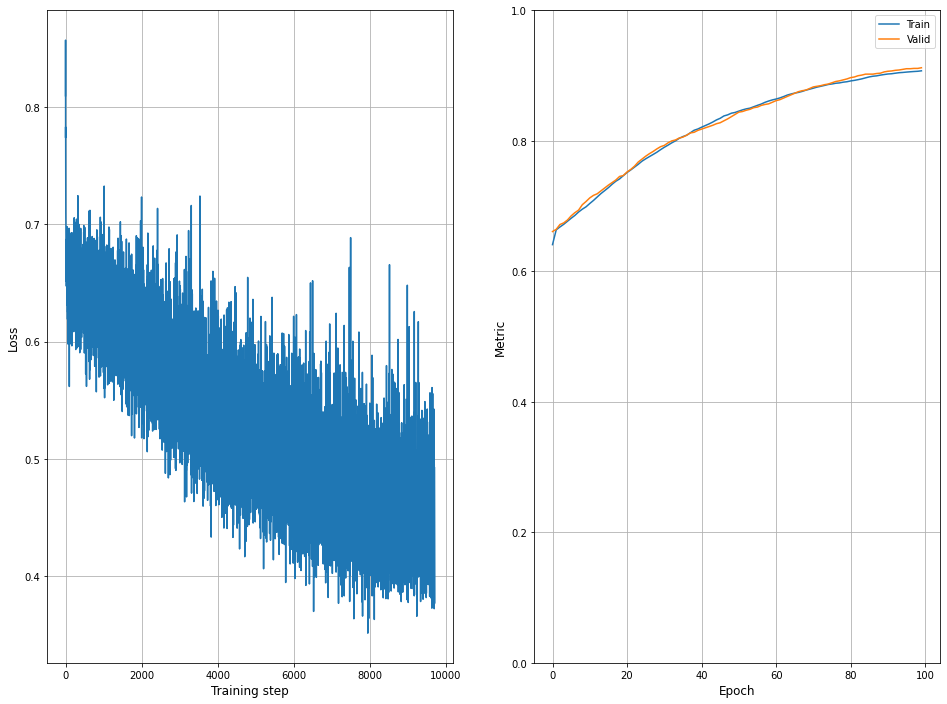

In [72]:
classifier.plot()